In [1]:
%load_ext autoreload
%autoreload 2

%load_ext watermark

from pathlib import Path
import time 
from pprint import pprint, pformat

import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
import numba as nb
from arch.bootstrap import IIDBootstrap, MovingBlockBootstrap, CircularBlockBootstrap

# import visual tools
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
import seaborn as sns

# import util libs
from tqdm import tqdm, tqdm_notebook
import warnings
warnings.filterwarnings("ignore")

#import sys
#sys.path.append("..")
#from src.tools.pystore_tools import *
#from src.tools.utils import *

%watermark -v -m -g
print()
%watermark --iversions

CPython 3.8.5
IPython 7.19.0

compiler   : GCC 7.3.0
system     : Linux
release    : 5.8.0-36-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 12
interpreter: 64bit
Git hash   :

matplotlib      3.3.2
statsmodels.api 0.12.0
numpy           1.19.2
seaborn         0.11.0
pandas          1.1.3
numba           0.51.2



In [2]:
sns_params = {
    'font.size':9.5,
    'font.weight':'medium',
    'figure.figsize':(10,7),
}

mpl.rcParams["figure.dpi"] = 300
mpl.rcParams["savefig.dpi"] = 100
plt.style.use('seaborn-talk')
#plt.style.use('bmh')
#plt.style.use('dark_background')
sns.set_context(sns_params)
savefig_kwds=dict(dpi=300, bbox_inches='tight', frameon=True, format='png')
nanex_colors = ("#f92b20", "#fe701b", "#facd1f", "#d6fd1c", "#65fe1b",
                "#1bfe42", "#1cfdb4", "#1fb9fa", "#1e71fb", "#261cfd")
nanex_cmap = mpl.colors.ListedColormap(nanex_colors,name='nanex_cmap')
plt.register_cmap('nanex_cmap', cmap=nanex_cmap)

In [3]:
def plot_autocorr(s, lags=50, figsize=(10,7), title=None): 
    fig = plt.figure(figsize=figsize)
    layout = 2, 2
    acf_ax = plt.subplot2grid(layout, (0, 0))
    abs_acf_ax = plt.subplot2grid(layout, (0, 1))
    pacf_ax = plt.subplot2grid(layout, (1, 0))
    squared_ax = plt.subplot2grid(layout, (1, 1))
    
    sm.graphics.tsa.plot_acf(s, fft=True, zero=False, lags=lags, ax=acf_ax,
                             title='Autocorrelation of Returns');
    
    sm.graphics.tsa.plot_acf(s.abs(), fft=True, zero=False,
                             lags=lags, ax=abs_acf_ax,
                             title='Autocorrelation of Absolute Returns');
    
    sm.graphics.tsa.plot_pacf(s, zero=False, lags=lags, ax=pacf_ax,
                              title='Partial Autocorrelation of Returns');
    
    sm.graphics.tsa.plot_acf(s**2, fft=True, zero=False,
                             lags=lags, ax=squared_ax,
                             title='Autocorrelation of Squared Returns');
    
    if title: fig.suptitle(title, fontweight='demi', fontsize=16)
    fig.tight_layout()
    fig.subplots_adjust(top=0.88)
    return

def plot_mean_dist(returns, sim_returns, ax):
    
    mean_return = returns.mean()
    
    ax.set_title(f'{returns.name} mean return: {mean_return:.4f}')
    sim_means = sim_returns.mean().squeeze()

    g = sns.distplot(sim_means, kde=False, ax=ax)
    g.axvline(mean_return, color='r')    
    return
    
def plot_std_dist(returns, sim_returns, ax):
    
    std = returns.std()
    
    ax.set_title(f'{returns.name} return std: {std:.4f}')
    sim_stds = sim_returns.std().squeeze()

    g = sns.distplot(sim_stds, kde=False, ax=ax)
    g.axvline(std, color='r')    
    return

def plot_min_dist(returns, sim_returns, ax):
    
    min_ = returns.min()
    
    ax.set_title(f'{returns.name} return min: {min_:.4f}')
    sim_mins = sim_returns.min().squeeze()

    g = sns.distplot(sim_mins, kde=False, ax=ax)
    g.axvline(min_, color='r')    
    return

def plot_max_dist(returns, sim_returns, ax):
    
    max_ = returns.max()
    
    ax.set_title(f'{returns.name} return max: {max_:.4f}')
    sim_maxs = sim_returns.max().squeeze()

    g = sns.distplot(sim_maxs, kde=False, ax=ax)
    g.axvline(max_, color='r')    
    return

def plot_autocorr_dist(returns, sim_returns, ax):
    
    autocorr = returns.autocorr()

    ax.set_title(f'{returns.name} return autocorr: {autocorr:.4f}')
    sim_autocorrs = sim_returns.apply(pd.Series.autocorr).squeeze()

    g = sns.distplot(sim_autocorrs, kde=False, ax=ax)
    g.axvline(autocorr, color='r') 
    return

def plot_stat_dist(returns, sim_returns, figsize=(10,7)):
    fig = plt.figure(figsize=figsize, constrained_layout=True)
    gs = fig.add_gridspec(3, 2)
    plot_mean_dist(returns, sim_returns, fig.add_subplot(gs[0,0]))
    plot_std_dist(returns, sim_returns, fig.add_subplot(gs[0,1]))
    plot_min_dist(returns, sim_returns, fig.add_subplot(gs[1,0])) 
    plot_max_dist(returns, sim_returns, fig.add_subplot(gs[1,1])) 
    plot_autocorr_dist(returns, sim_returns, fig.add_subplot(gs[2,:]))
    
    fig.suptitle(f'{returns.name} simulated stat distributions',
                 fontweight='demi', fontsize=16)
    fig.tight_layout()
    fig.subplots_adjust(top=0.88)
    return


In [8]:
def to_returns(s): return np.log(s/s.shift(1)).dropna()

def to_price_index(df, start=100):
    return (start * (np.exp(df.cumsum())))

def cdescribe(x, n_cols=None):
    if not n_cols:
        d = x.describe()
        d.loc['skew'] = x.skew()
        d.loc['kurtosis'] = x.kurtosis()
        return d
    else:
        x_ = x.sample(n_cols, axis=1)
        d = x_.describe()
        d.loc['skew'] = x_.skew()
        d.loc['kurtosis'] = x_.kurtosis()        
        return d
    
def CBB(s, blocksize, N_paths):
    sim_returns = []

    bs = CircularBlockBootstrap(blocksize, s)
    for i, data in enumerate(tqdm(bs.bootstrap(N_paths))):
        tmp = data[0][0].reset_index(drop=True)
        sim_returns.append(tmp)
    simulations = pd.concat(sim_returns, axis=1, ignore_index=True)
    return simulations     

def MBB(s, blocksize, N_paths):
    sim_returns = []

    bs = MovingBlockBootstrap(blocksize, s)
    for i, data in enumerate(tqdm(bs.bootstrap(N_paths))):
        tmp = data[0][0].reset_index(drop=True)
        sim_returns.append(tmp)
    simulations = pd.concat(sim_returns, axis=1, ignore_index=True)
    return simulations  

def IIDB(s, N_paths):
    sim_returns = []

    bs = IIDBootstrap(s)
    for i, data in enumerate(tqdm(bs.bootstrap(N_paths))):
        tmp = data[0][0].reset_index(drop=True)
        sim_returns.append(tmp)
    simulations = pd.concat(sim_returns, axis=1, ignore_index=True)
    return simulations    

def compare_stats(x, y, n_cols=None):
    pd.options.display.float_format = '{:,.4f}'.format
    data = (pd.concat([cdescribe(x), cdescribe(y, n_cols=n_cols)], axis=1))
    return data

def view_all(real, sims, n_cols=20, cmap=None):
    plt.set_cmap(cmap)
    display(compare_stats(real, sims, n_cols=20))
    plot_stat_dist(real, sims)
    plot_autocorr(real, title=f'{real.name} Real Returns')
    rand_col = np.random.randint(len(sims.columns), size=1)[0]
    plot_autocorr(sims[rand_col], 
                  title=f'Simulated Return Path {rand_col}')
    return
    
def plot_realizations(real, sims, start, 
                      n_plot_paths=50, figsize=(10,7), cmap=None):   
    plt.set_cmap(cmap)
    sim_prices = to_price_index(sims, start=start)

    fig, ax = plt.subplots(figsize=figsize)
    (sim_prices.sample(n_plot_paths, axis=1)
     .plot(legend=False, alpha=0.7, lw=1., ax=ax))
    (to_price_index(real.reset_index(drop=True), start=start)
     .plot(legend=True, ax=ax, lw=5, ls='--', color='k'))
    plt.title(f'{real.name} {n_plot_paths} simulated price paths')
    
def cprint(df, nrows=None, sample=False):
    """
    custom print function to view pandas and dask dataframes

    :param df: dataframe
    :param nrows: number of rows to return
    :param sample: bool, return random sample for view
    :return:
    """
    if not isinstance(df, pd.DataFrame):
        try:
            df = df.to_frame()
        except:
            raise ValueError('object cannot be coerced to df')

    if not nrows: nrows = 5
    print('-' * 79)
    print('dataframe information')
    print('-' * 79)
    if sample:
        print(df.sample(nrows))
    else:
        print(df.tail(nrows))
    print('-' * 50)
    print(df.info())
    print('-' * 79)
    print()

In [9]:
nq = pd.read_csv('NQ.csv', index_col=0)
gc = pd.read_csv('GC.csv', index_col=0)

In [10]:
nq_price = nq['C']
gc_price = gc['C']
nq_returns = to_returns(nq_price).dropna()
gc_returns = to_returns(gc_price).dropna()
nq_returns.name = "NQ - NASDAQ 100 Futures"
gc_returns.name = "GC - Gold Futures"

In [11]:
cprint(nq_returns)
cprint(nq_price)
cprint(gc_returns)
cprint(gc_price)

-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
                     NQ - NASDAQ 100 Futures
2019-12-31 13:35:00                -0.000029
2019-12-31 13:40:00                -0.000114
2019-12-31 13:45:00                 0.000257
2019-12-31 13:50:00                 0.000114
2019-12-31 13:55:00                 0.000257
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
Index: 70001 entries, 2019-01-01 15:05:00 to 2019-12-31 13:55:00
Data columns (total 1 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   NQ - NASDAQ 100 Futures  70001 non-null  float64
dtypes: float64(1)
memory usage: 1.1+ MB
None
-------------------------------------------------------------------------------

-------------------------------------------------------------------------

## Bootstrap

In [12]:
N_paths = 1000
block_size = 4000
nq_sim_cbb = CBB(nq_returns, blocksize=block_size, N_paths=N_paths)

1000it [00:01, 627.42it/s]


NQ - NASDAQ 100 Futures         678         576         466  \
count                 70,001.0000 70,001.0000 70,001.0000 70,001.0000   
mean                       0.0000      0.0000      0.0000      0.0000   
std                        0.0006      0.0006      0.0006      0.0006   
min                       -0.0172     -0.0172     -0.0125     -0.0172   
25%                       -0.0002     -0.0002     -0.0002     -0.0002   
50%                        0.0000      0.0000      0.0000      0.0000   
75%                        0.0002      0.0002      0.0002      0.0002   
max                        0.0127      0.0127      0.0105      0.0087   
skew                      -0.7702     -0.8378     -0.5671     -1.1815   
kurtosis                  39.0252     43.4387     29.5670     39.6069   

                 710         791         164         385         181  \
count    70,001.0000 70,001.0000 70,001.0000 70,001.0000 70,001.0000   
mean          0.0000      0.0000      0.0000      0.0000      0.0000   
std           0.0006      0.0006      0.0006      0.0006      0.0007   
min          -0.0172     -0.0172     -0.0172     -0.0172     -0.0172   
25%          -0.0002     -0.0002     -0.0002     -0.0002     -0.0002   
50%           0.0000      0.0000      0.0000      0.0000      0.0000   
75%           0.0003      0.0002      0.0002      0.0002      0.0003   
max           0.0127      0.0105      0.0127      0.0127      0.0127   
skew         -0.6571     -1.6303     -0.9732     -0.6434     -0.7228   
kurtosis     29.8651     50.1736     40.0495     29.8928     34.2628   

                 322  ...         509         588         991         842  \
count    70,001.0000  ... 70,001.0000 70,001.0000 70,001.0000 70,001.0000   
mean          0.0000  ...      0.0000      0.0000      0.0000      0.0000   
std           0.0006  ...      0.0007      0.0007      0.0006      0.0006   
min          -0.0172  ...     -0.0125     -0.0172     -0.0125     -0.0125   
25%          -0.0002  ...     -0.0002     -0.0003     -0.0002     -0.0002   
50%           0.0000  ...      0.0000      0.0000      0.0000      0.0000   
75%           0.0002  ...      0.0002      0.0003      0.0002      0.0002   
max           0.0105  ...      0.0127      0.0105      0.0127      0.0127   
skew         -1.5388  ...     -0.4074     -0.6764     -0.3770      0.0601   
kurtosis     59.4258  ...     26.3966     28.5588     26.3638     38.0721   

                 822         961         611         833         548  \
count    70,001.0000 70,001.0000 70,001.0000 70,001.0000 70,001.0000   
mean          0.0000      0.0000      0.0000      0.0000      0.0000   
std           0.0005      0.0006      0.0005      0.0006      0.0007   
min          -0.0125     -0.0172     -0.0172     -0.0172     -0.0172   
25%          -0.0002     -0.0002     -0.0002     -0.0002     -0.0002   
50%           0.0000      0.0000      0.0000      0.0000      0.0000   
75%           0.0002      0.0002      0.0002      0.0002      0.0002   
max           0.0127      0.0127      0.0105      0.0078      0.0127   
skew         -0.3331     -0.5882     -0.5510     -0.8477     -0.8155   
kurtosis     32.2738     34.3995     31.6570     30.6412     39.1142   

                 774  
count    70,001.0000  
mean          0.0000  
std           0.0005  
min          -0.0172  
25%          -0.0002  
50%           0.0000  
75%           0.0002  
max           0.0080  
skew         -1.3702  
kurtosis     50.8183  

[10 rows x 21 columns]

<Figure size 3000x2100 with 0 Axes>

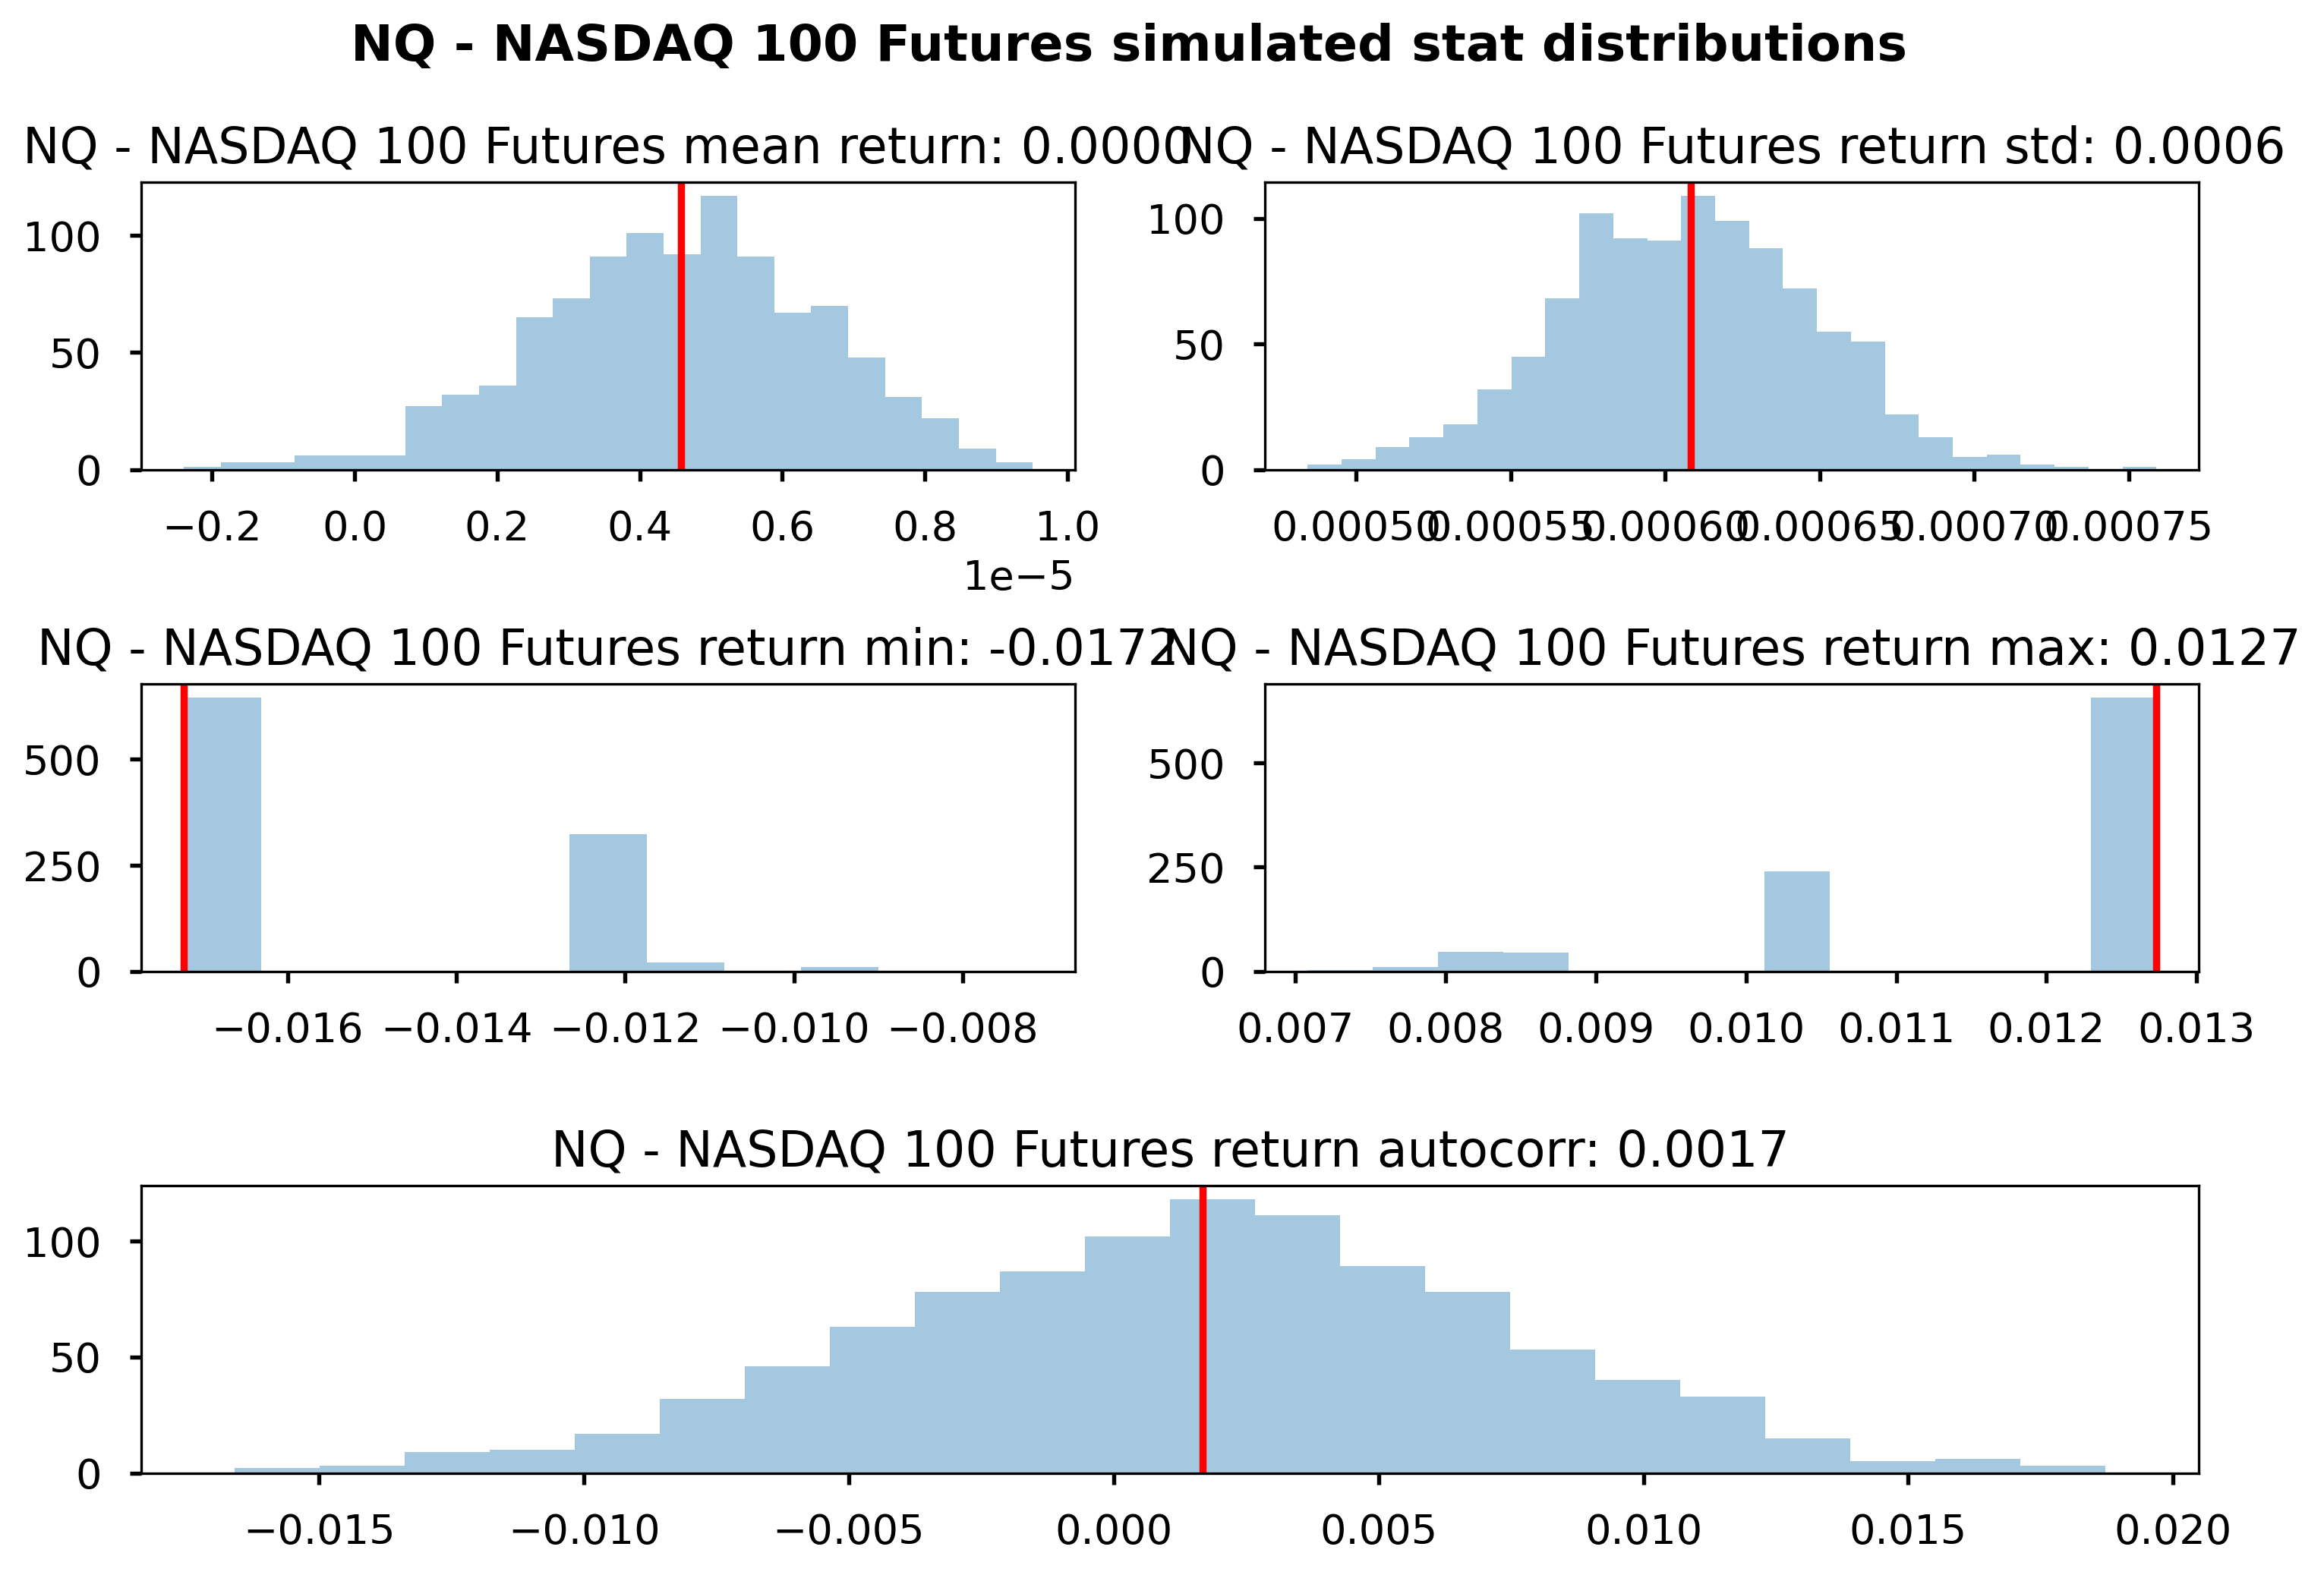

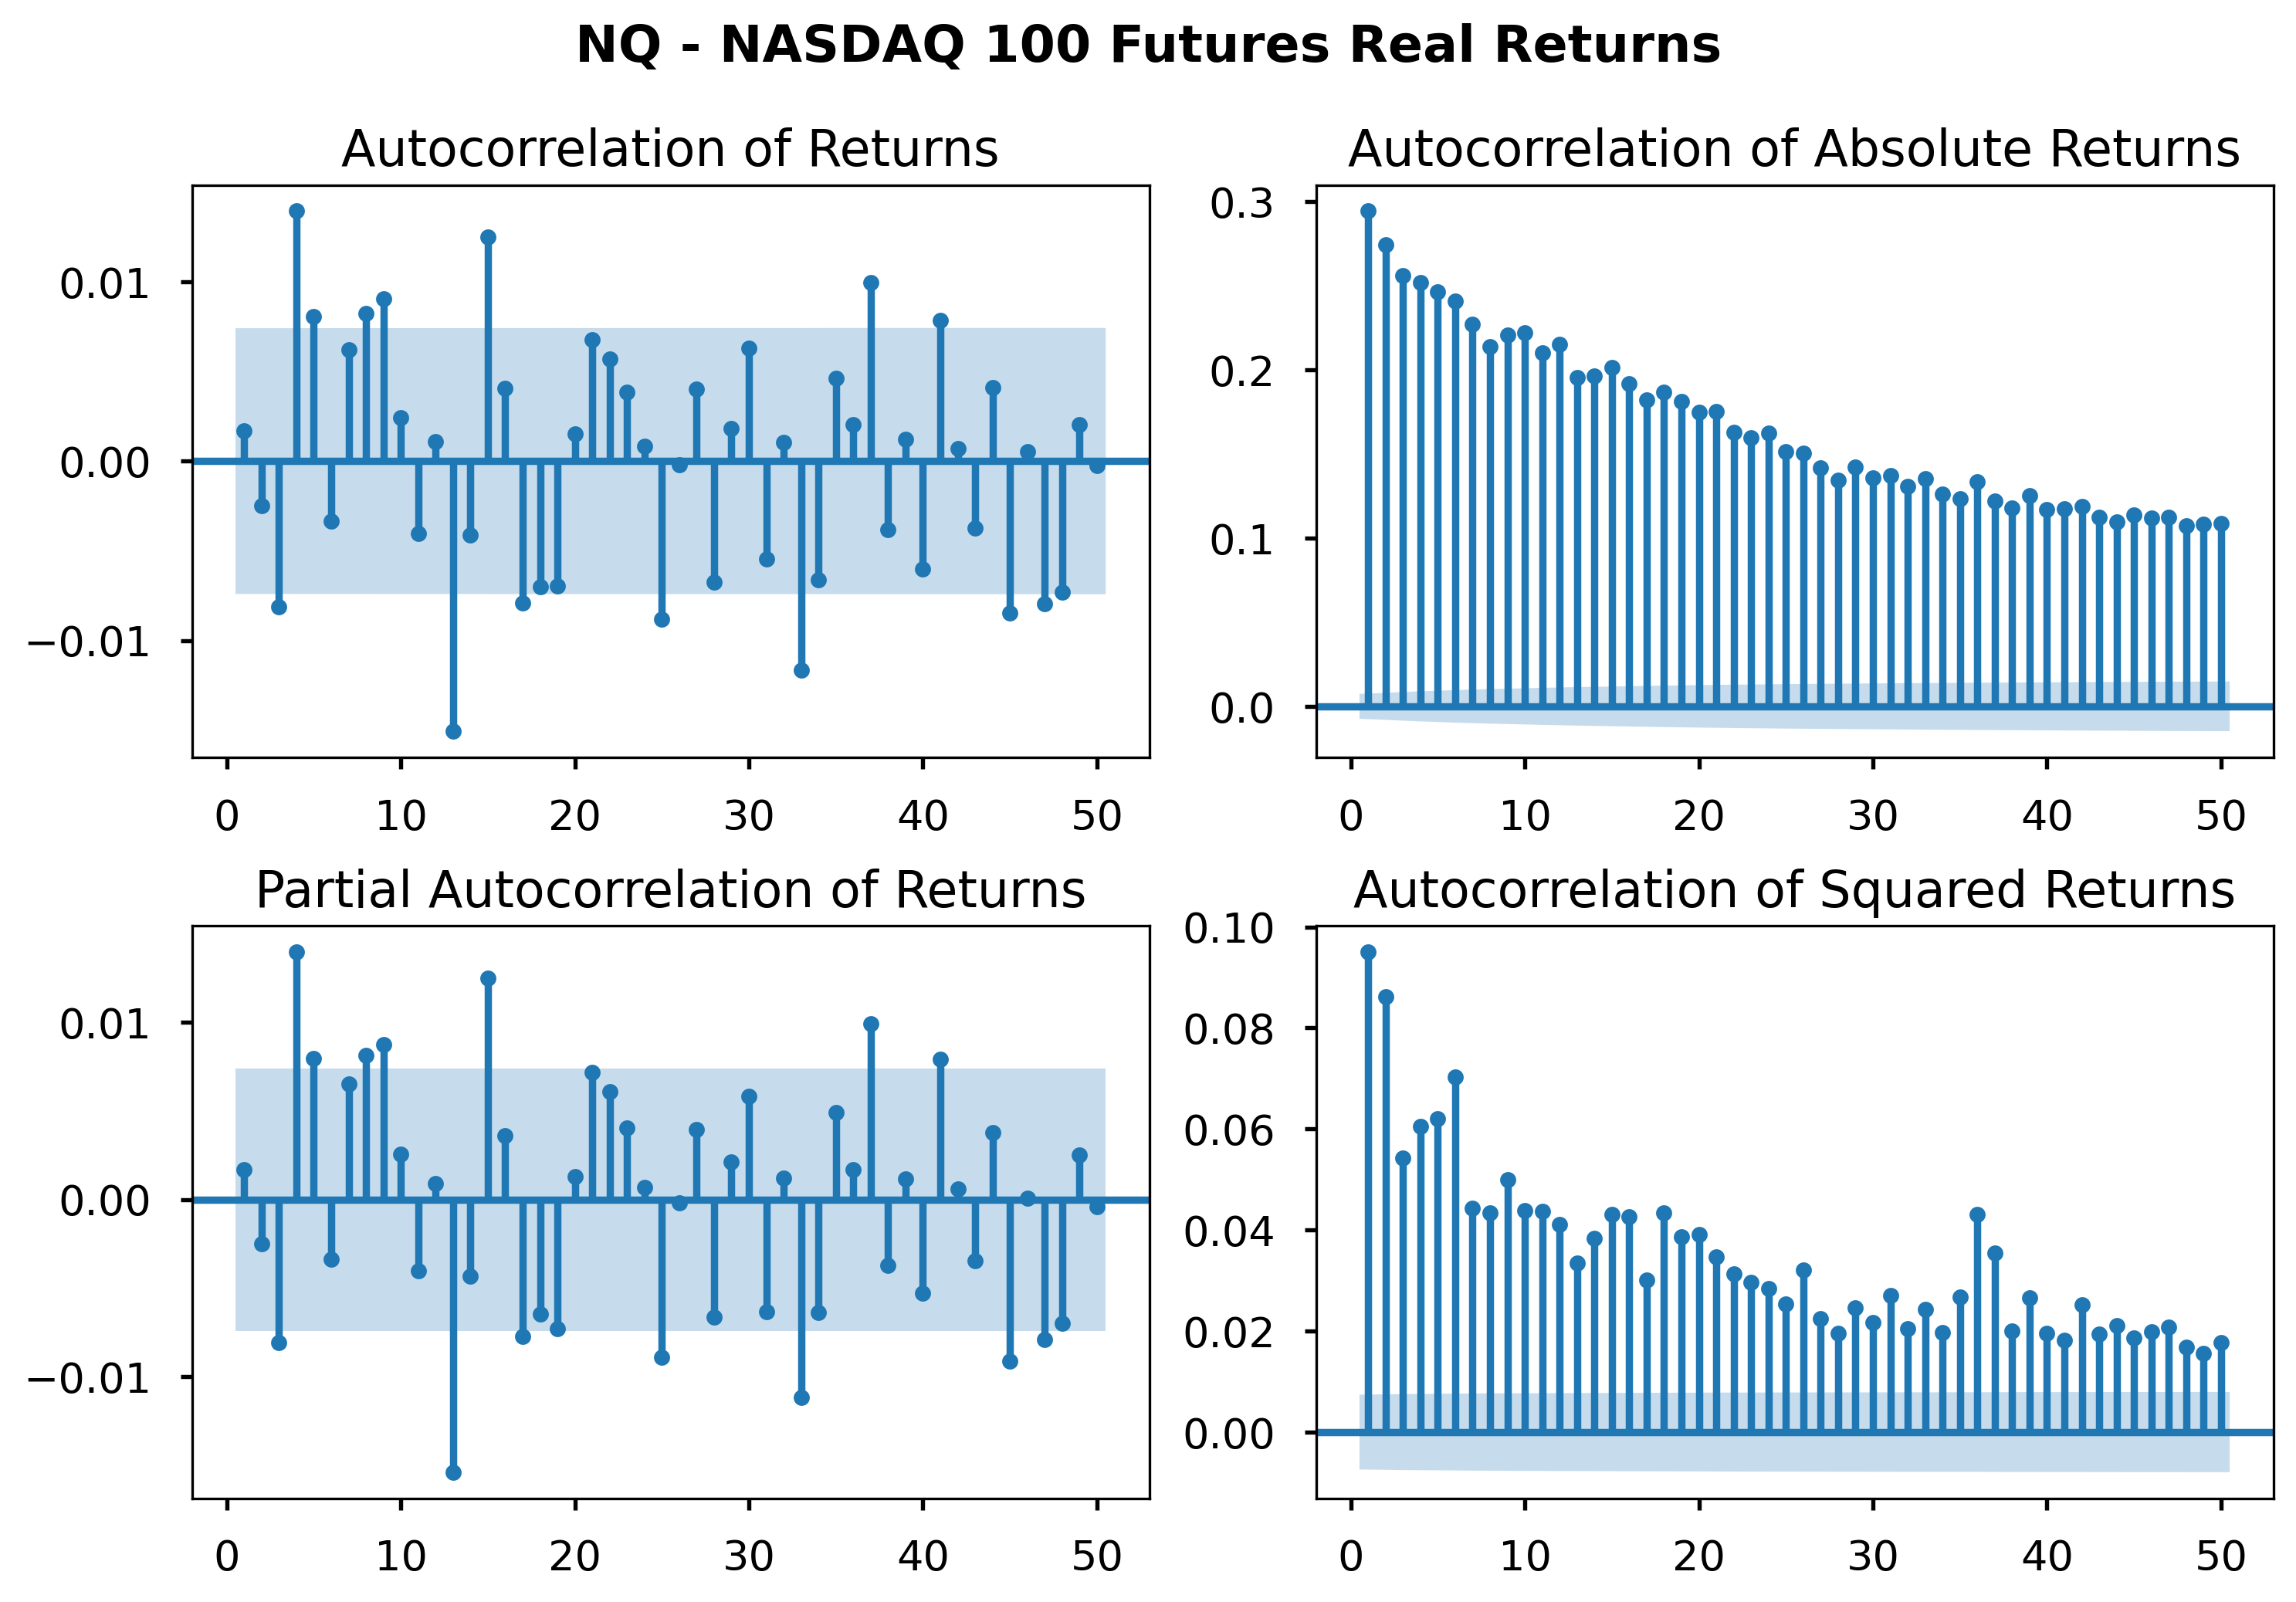

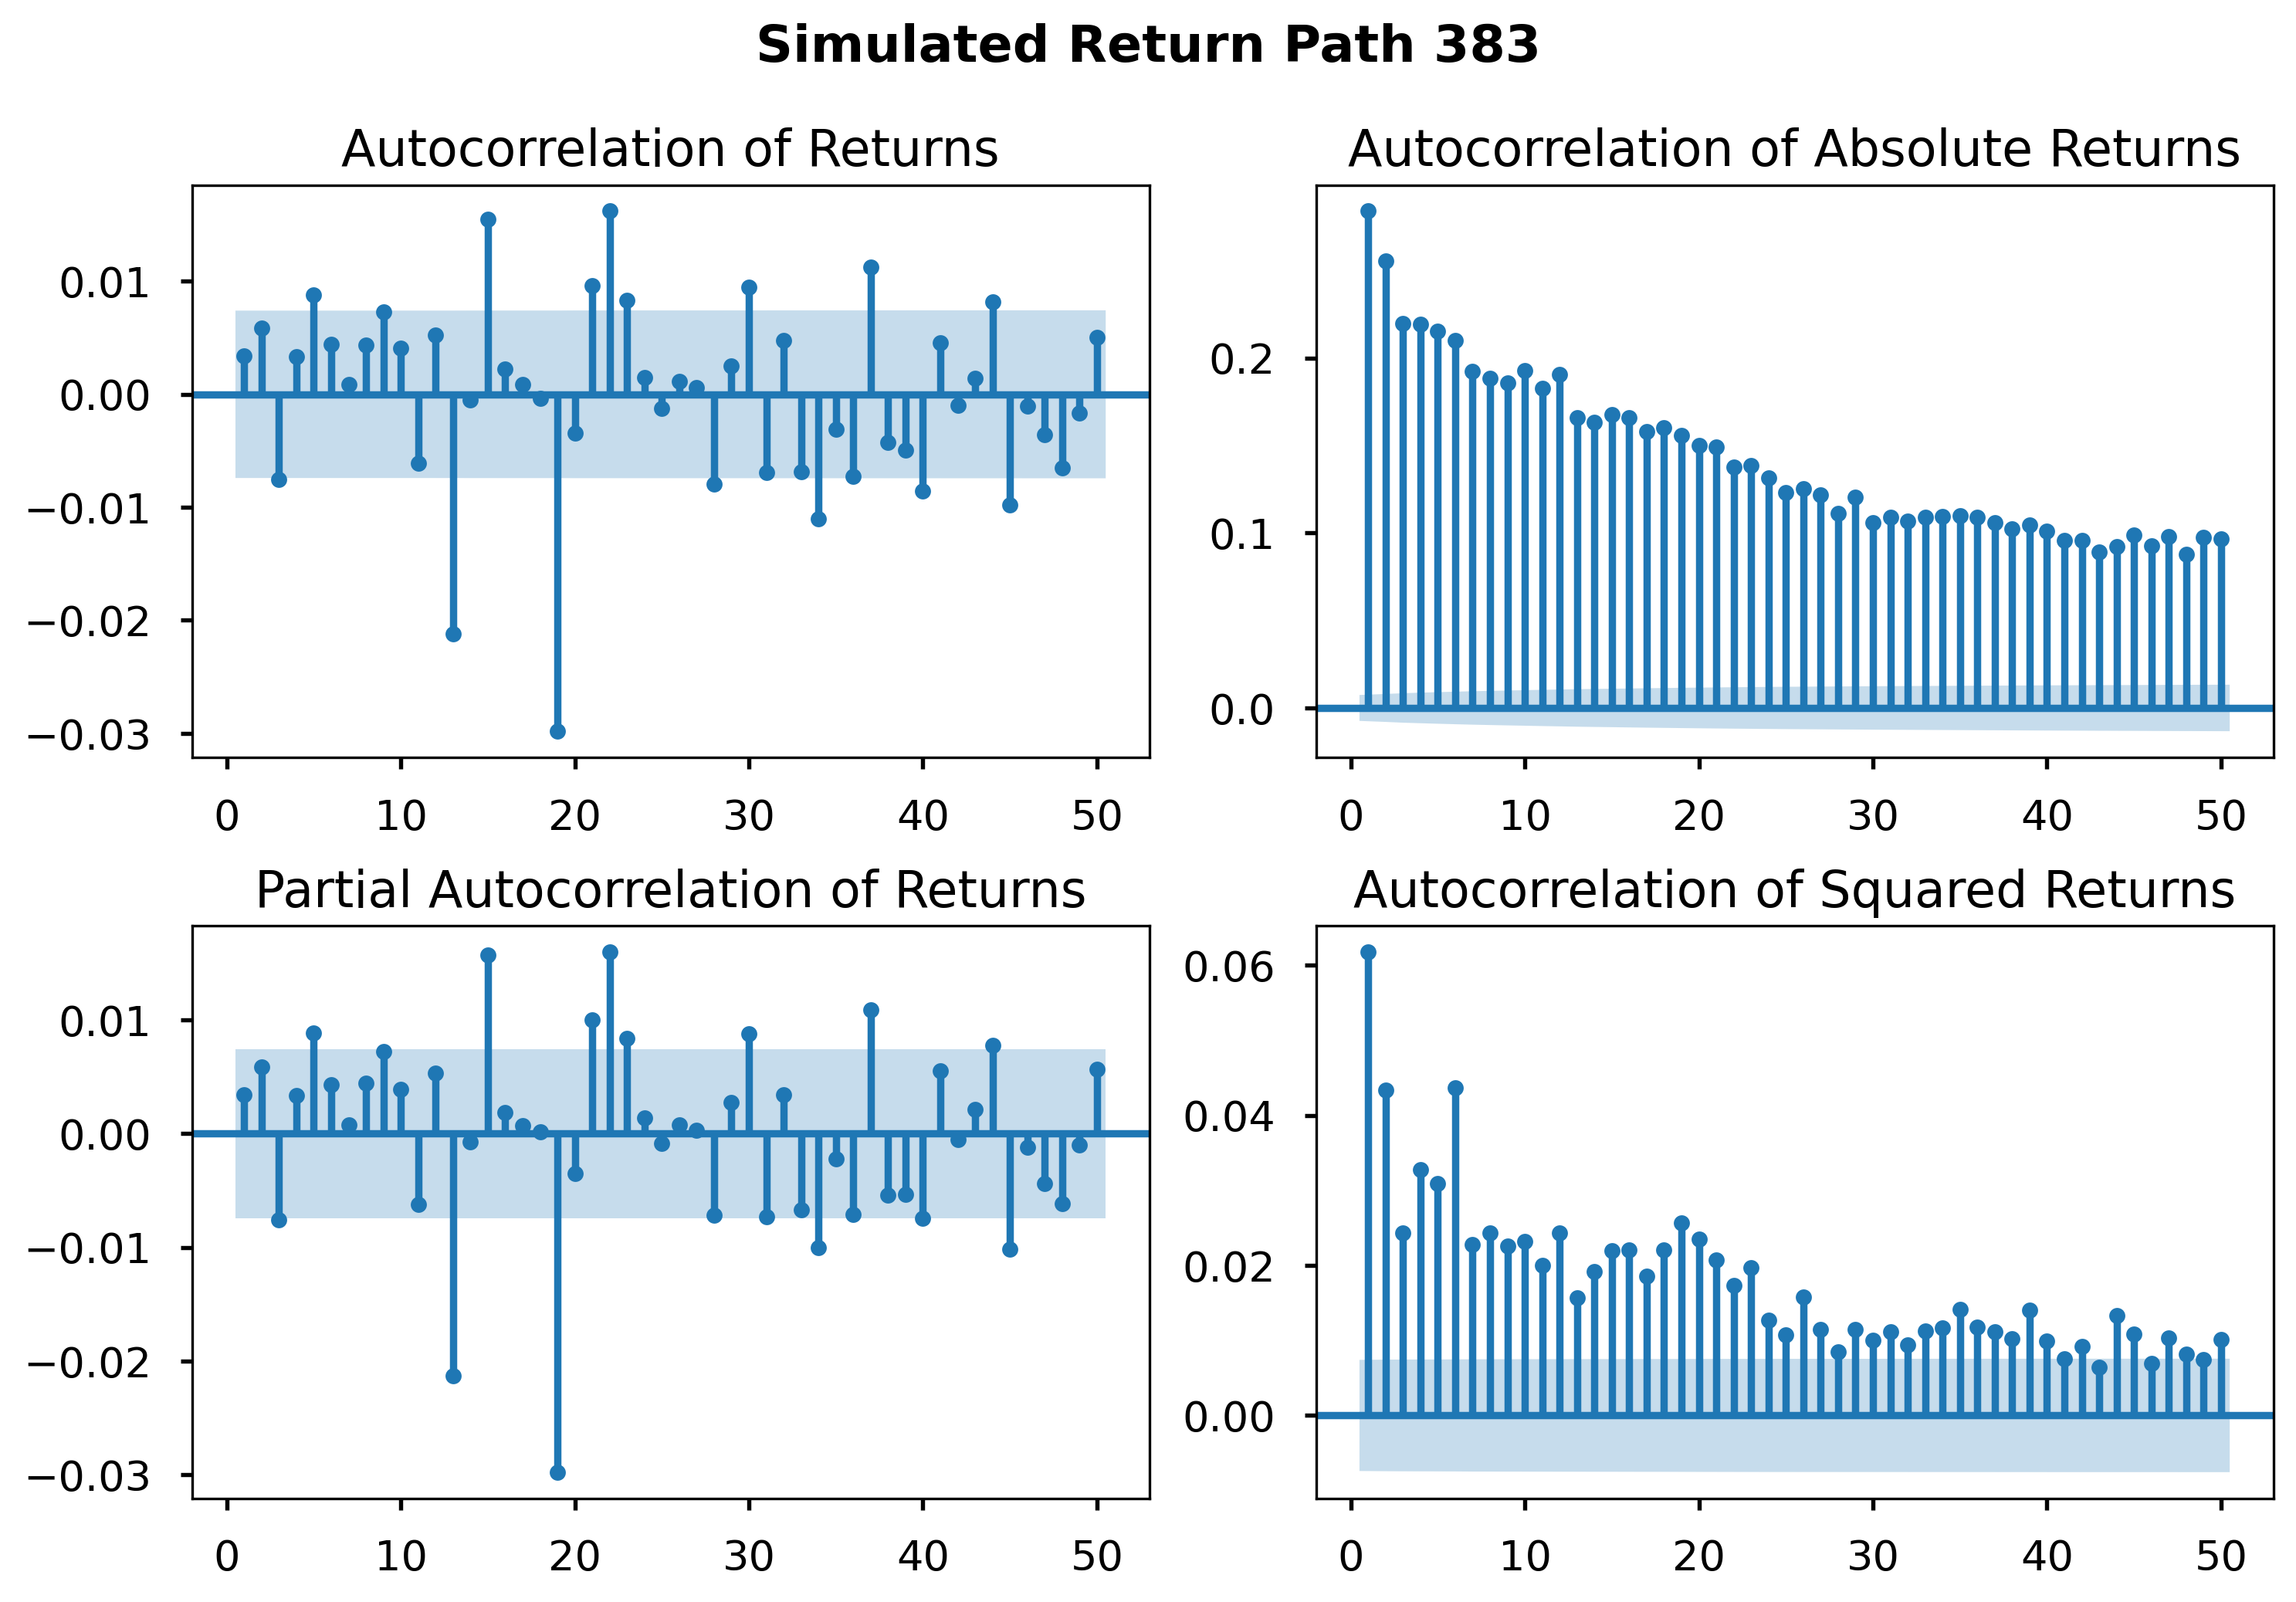

In [13]:
view_all(nq_returns, nq_sim_cbb, cmap=None)

0           1          2           3          4    \
2019-01-01 15:05:00  7,508.9505  7,498.9306 7,505.0105  7,503.1089 7,500.6869   
2019-01-01 15:10:00  7,520.8038  7,504.0103 7,503.5789  7,505.7394 7,500.6869   
2019-01-01 15:15:00  7,523.4647  7,500.8021 7,511.2140  7,506.2177 7,500.0000   
2019-01-01 15:20:00  7,518.6266  7,499.1979 7,513.8385  7,507.6526 7,499.7710   
2019-01-01 15:25:00  7,519.8362  7,495.1877 7,510.7368  7,507.1743 7,499.3131   
...                         ...         ...        ...         ...        ...   
2019-12-31 13:35:00 10,710.2745 11,770.0660 7,079.9821 11,279.2333 8,923.6426   
2019-12-31 13:40:00 10,720.5104 11,770.0660 7,080.6871 11,265.3228 8,929.5024   
2019-12-31 13:45:00 10,740.6292 11,772.8607 7,080.9221 11,272.0901 8,926.5725   
2019-12-31 13:50:00 10,739.9233 11,772.4615 7,075.7519 11,281.1132 8,926.2795   
2019-12-31 13:55:00 10,736.7466 11,767.2714 7,079.9821 11,282.2410 8,911.3370   

                           5           6           7           8    \
2019-01-01 15:05:00 7,499.1628  7,503.5668  7,497.8826  7,502.5826   
2019-01-01 15:10:00 7,497.7675  7,500.0000  7,498.1472  7,503.0521   
2019-01-01 15:15:00 7,497.4885  7,499.7622  7,500.0000  7,503.5217   
2019-01-01 15:20:00 7,493.0235  7,504.9935  7,500.7940  7,504.2260   
2019-01-01 15:25:00 7,496.3722  7,490.9641  7,501.3234  7,502.5826   
...                        ...         ...         ...         ...   
2019-12-31 13:35:00 9,824.5216 10,471.1298 11,101.6288 10,116.3555   
2019-12-31 13:40:00 9,826.6013 10,471.7642 11,103.2242 10,116.0178   
2019-12-31 13:45:00 9,825.7100 10,468.2752 11,103.2242 10,116.6933   
2019-12-31 13:50:00 9,822.1449 10,467.6408 11,104.8197 10,123.4483   
2019-12-31 13:55:00 9,823.9274 10,464.7861 11,106.4151 10,123.7861   

                            9    ...        990         991        992  \
2019-01-01 15:05:00  7,504.9669  ... 7,498.1276  7,500.0000 7,504.0690   
2019-01-01 15:10:00  7,508.0416  ... 7,498.5957  7,496.4797 7,504.9732   
2019-01-01 15:15:00  7,508.0416  ... 7,502.5745  7,489.1876 7,502.2605   
2019-01-01 15:20:00  7,508.0416  ... 7,502.1064  7,492.4565 7,500.6782   
2019-01-01 15:25:00  7,506.6225  ... 7,503.5107  7,490.9478 7,499.7739   
...                         ...  ...        ...         ...        ...   
2019-12-31 13:35:00 11,095.7344  ... 9,973.4456 10,456.2258 8,798.7143   
2019-12-31 13:40:00 11,093.5195  ... 9,973.1189 10,462.1409 8,789.9725   
2019-12-31 13:45:00 11,090.5664  ... 9,977.6933 10,447.8750 8,794.7407   
2019-12-31 13:50:00 11,096.1035  ... 9,981.9409 10,450.6586 8,792.6215   
2019-12-31 13:55:00 11,101.6407  ... 9,979.6537 10,452.0504 8,787.5884   

                           993         994         995        996         997  \
2019-01-01 15:05:00 7,503.1682  7,502.1950  7,500.8641 7,500.4874  7,499.7756   
2019-01-01 15:10:00 7,499.1359  7,498.5367  7,500.2160 7,502.1935  7,499.7756   
2019-01-01 15:15:00 7,506.9124  7,497.3172  7,499.7840 7,501.7060  7,496.8587   
2019-01-01 15:20:00 7,496.8318  7,497.3172  7,498.9199 7,502.6809  7,495.7369   
2019-01-01 15:25:00 7,496.2558  7,495.8539  7,498.4879 7,502.9246  7,493.7175   
...                        ...         ...         ...        ...         ...   
2019-12-31 13:35:00 9,478.2119 13,517.5005 13,018.8168 6,340.4519 10,735.2984   
2019-12-31 13:40:00 9,470.6363 13,563.6815 13,019.6561 6,340.6332 10,738.8761   
2019-12-31 13:45:00 9,463.0608 13,520.5123 13,019.2365 6,340.9956 10,737.4450   
2019-12-31 13:50:00 9,466.0910 13,487.3824 13,007.9048 6,341.1769 10,736.7295   
2019-12-31 13:55:00 9,467.6061 13,465.7977 13,002.0291 6,341.1769 10,729.5740   

                            998        999  
2019-01-01 15:05:00  7,498.2646 7,500.7093  
2019-01-01 15:10:00  7,500.2479 7,499.5271  
2019-01-01 15:15:00  7,493.0583 7,498.5813  
2019-01-01 15:20:00  7,489.8354 7,500.4729  
2019-01-01 15:25:00  7,490.3312 7,497.6356  
...                         ...        ...  
2019-12-31 13:35:00 10,306.6529 8,192

<Figure size 3000x2100 with 0 Axes>

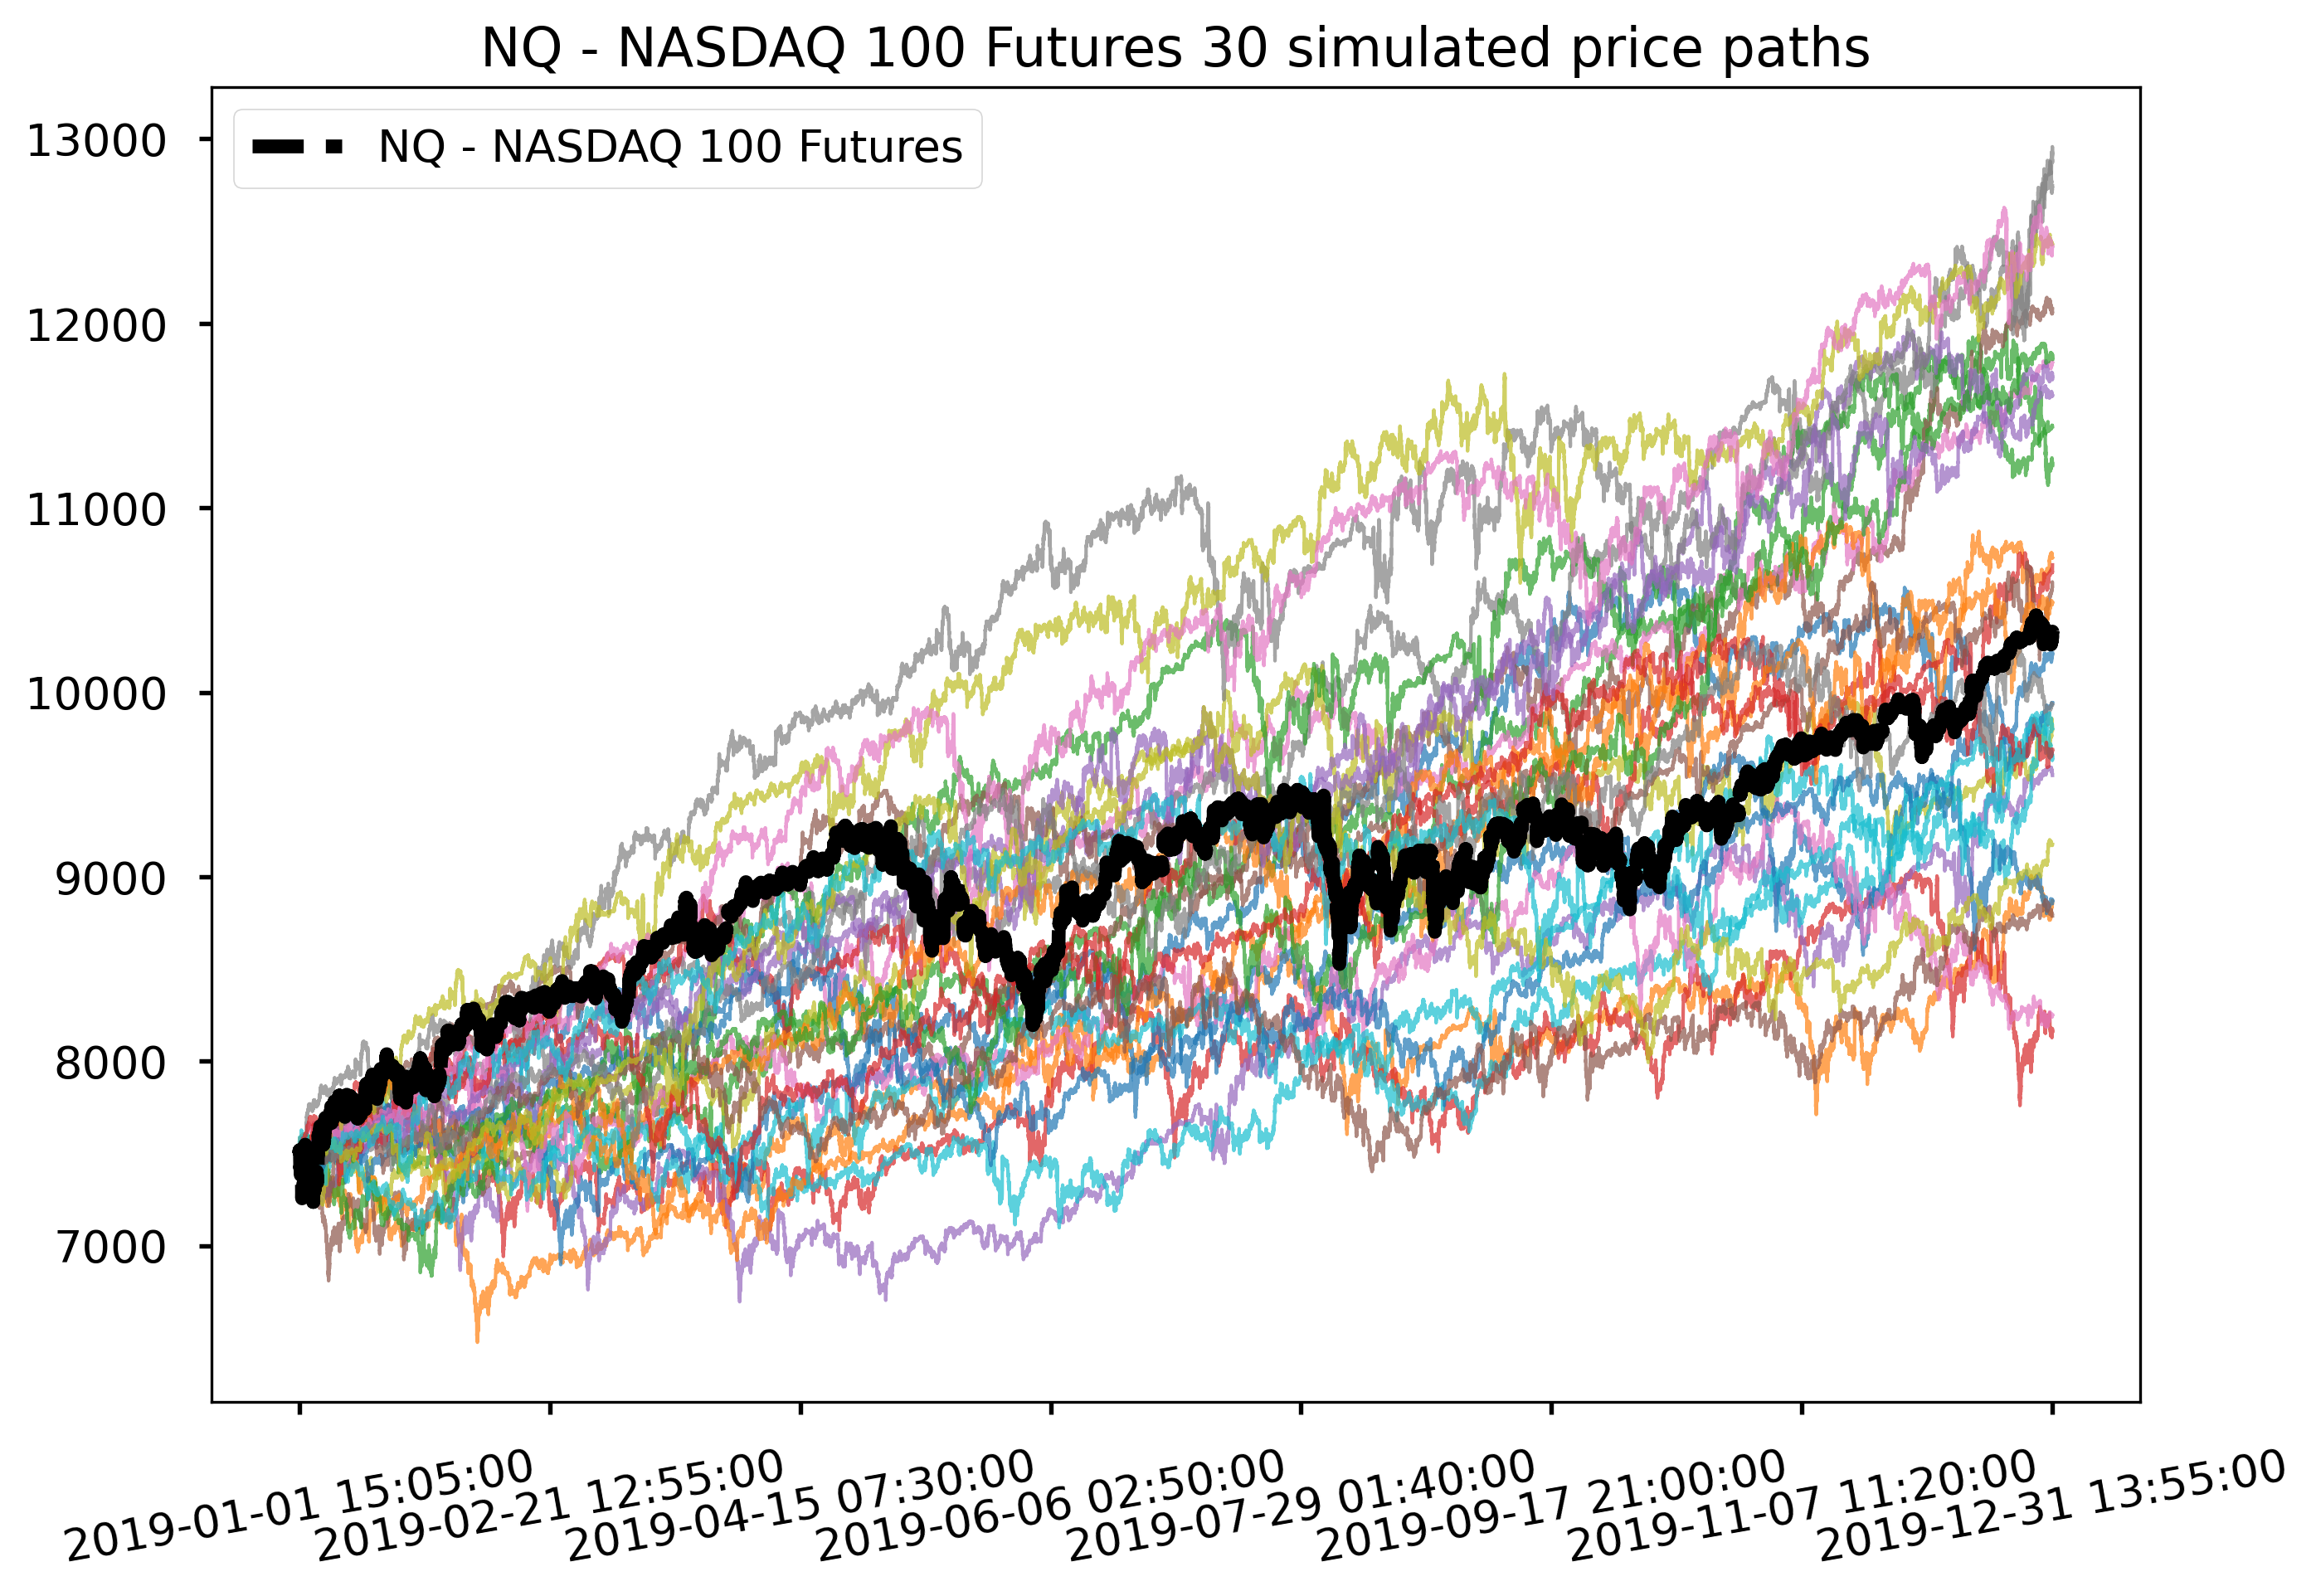

In [14]:
def plot_prices(real, sims, start, price_index,
                      n_plot_paths=50, figsize=(10,7), cmap=None):   
    plt.set_cmap(cmap)
    sim_prices = to_price_index(sims, start=start)
    sim_prices.index = price_index
    display(sim_prices)
    fig, ax = plt.subplots(figsize=figsize)
    (sim_prices.sample(n_plot_paths, axis=1)
     .plot(legend=False, alpha=0.7, lw=1., ax=ax))
    real_prices = to_price_index(real.reset_index(drop=True), start=start)
    real_prices.index = price_index
    real_prices.plot(legend=True, ax=ax, lw=4, ls='--', color='k')
    plt.title(f'{real.name} {n_plot_paths} simulated price paths')
    plt.xticks(rotation=10)

plot_prices(nq_returns, nq_sim_cbb, start=7500, price_index=nq.index[1:], n_plot_paths=30, cmap='nanex_cmap')

In [15]:
N_paths = 1000
block_size = 100
gc_sim_cbb = CBB(gc_returns, blocksize=block_size, N_paths=N_paths)

1000it [00:01, 582.70it/s]


GC - Gold Futures         162         252         786         546  \
count           70,805.0000 70,805.0000 70,805.0000 70,805.0000 70,805.0000   
mean                 0.0000      0.0000      0.0000      0.0000      0.0000   
std                  0.0005      0.0004      0.0005      0.0005      0.0004   
min                 -0.0139     -0.0076     -0.0098     -0.0139     -0.0139   
25%                 -0.0002     -0.0002     -0.0002     -0.0002     -0.0002   
50%                  0.0000      0.0000      0.0000      0.0000      0.0000   
75%                  0.0002      0.0002      0.0002      0.0002      0.0002   
max                  0.0125      0.0125      0.0125      0.0125      0.0106   
skew                 0.2376      0.7384      0.5880     -0.2196     -0.5749   
kurtosis            56.1125     40.1265     54.5427     51.9187     43.5066   

                 769         519         745         492         838  ...  \
count    70,805.0000 70,805.0000 70,805.0000 70,805.0000 70,805.0000  ...   
mean          0.0000      0.0000      0.0000      0.0000      0.0000  ...   
std           0.0004      0.0005      0.0005      0.0005      0.0005  ...   
min          -0.0139     -0.0098     -0.0139     -0.0139     -0.0139  ...   
25%          -0.0002     -0.0002     -0.0002     -0.0002     -0.0002  ...   
50%           0.0000      0.0000      0.0000      0.0000      0.0000  ...   
75%           0.0002      0.0002      0.0002      0.0002      0.0002  ...   
max           0.0089      0.0125      0.0108      0.0125      0.0108  ...   
skew         -0.2968      1.5609      1.0361      0.0229     -1.7171  ...   
kurtosis     42.4503     63.5660     69.7002     68.9646     82.0766  ...   

                 911         951         751         594         425  \
count    70,805.0000 70,805.0000 70,805.0000 70,805.0000 70,805.0000   
mean          0.0000      0.0000      0.0000      0.0000      0.0000   
std           0.0004      0.0004      0.0004      0.0005      0.0005   
min          -0.0058     -0.0098     -0.0076     -0.0076     -0.0139   
25%          -0.0002     -0.0002     -0.0002     -0.0002     -0.0002   
50%           0.0000      0.0000      0.0000      0.0000      0.0000   
75%           0.0002      0.0002      0.0002      0.0002      0.0002   
max           0.0108      0.0125      0.0108      0.0125      0.0125   
skew          0.7685      0.0804      0.1922      0.9768      0.4853   
kurtosis     34.0513     45.3399     34.8154     51.9817     58.4540   

                 490         597         501          54         642  
count    70,805.0000 70,805.0000 70,805.0000 70,805.0000 70,805.0000  
mean          0.0000      0.0000      0.0000      0.0000      0.0000  
std           0.0005      0.0005      0.0005      0.0005      0.0005  
min          -0.0139     -0.0076     -0.0098     -0.0139     -0.0098  
25%          -0.0002     -0.0002     -0.0002     -0.0002     -0.0002  
50%           0.0000      0.0000      0.0000      0.0000      0.0000  
75%           0.0002      0.0002      0.0002      0.0002      0.0002  
max           0.0125      0.0108      0.0125      0.0125      0.0108  
skew          1.2614      1.2969      0.5429     -0.2244      0.2190  
kurtosis     70.5238     52.2019     55.0183     70.0545     39.3350  

[10 rows x 21 columns]

<Figure size 3000x2100 with 0 Axes>

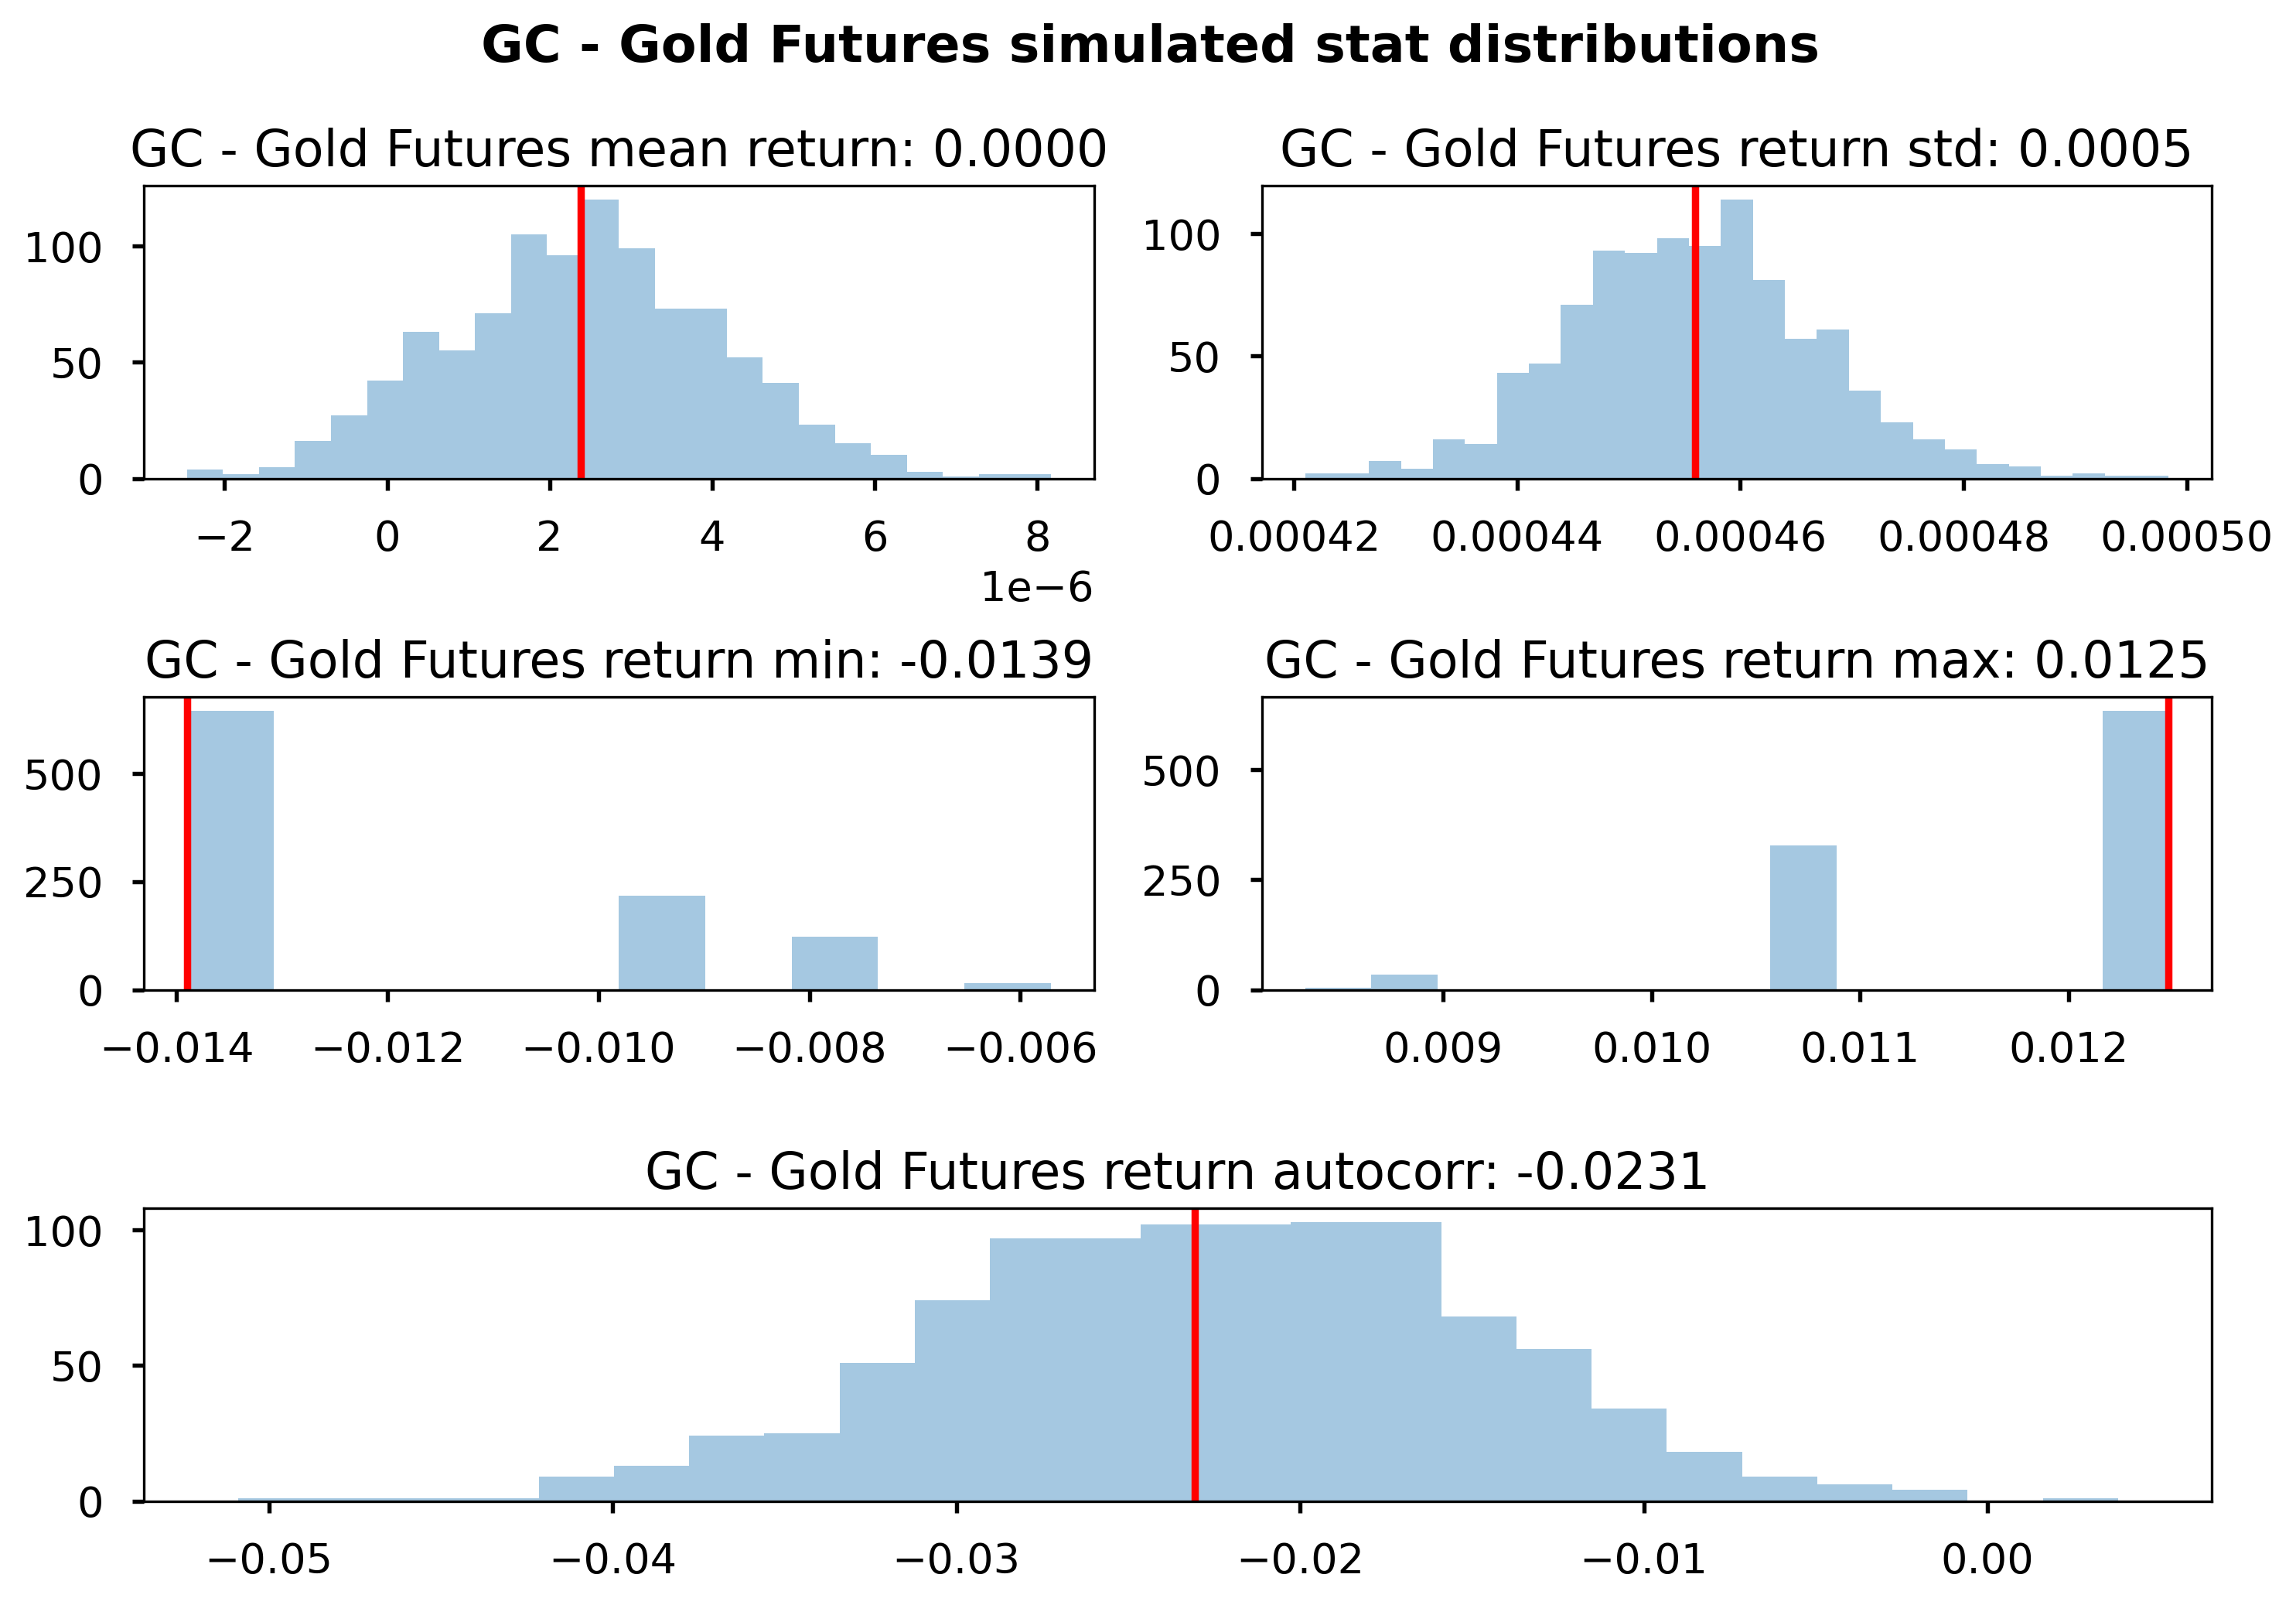

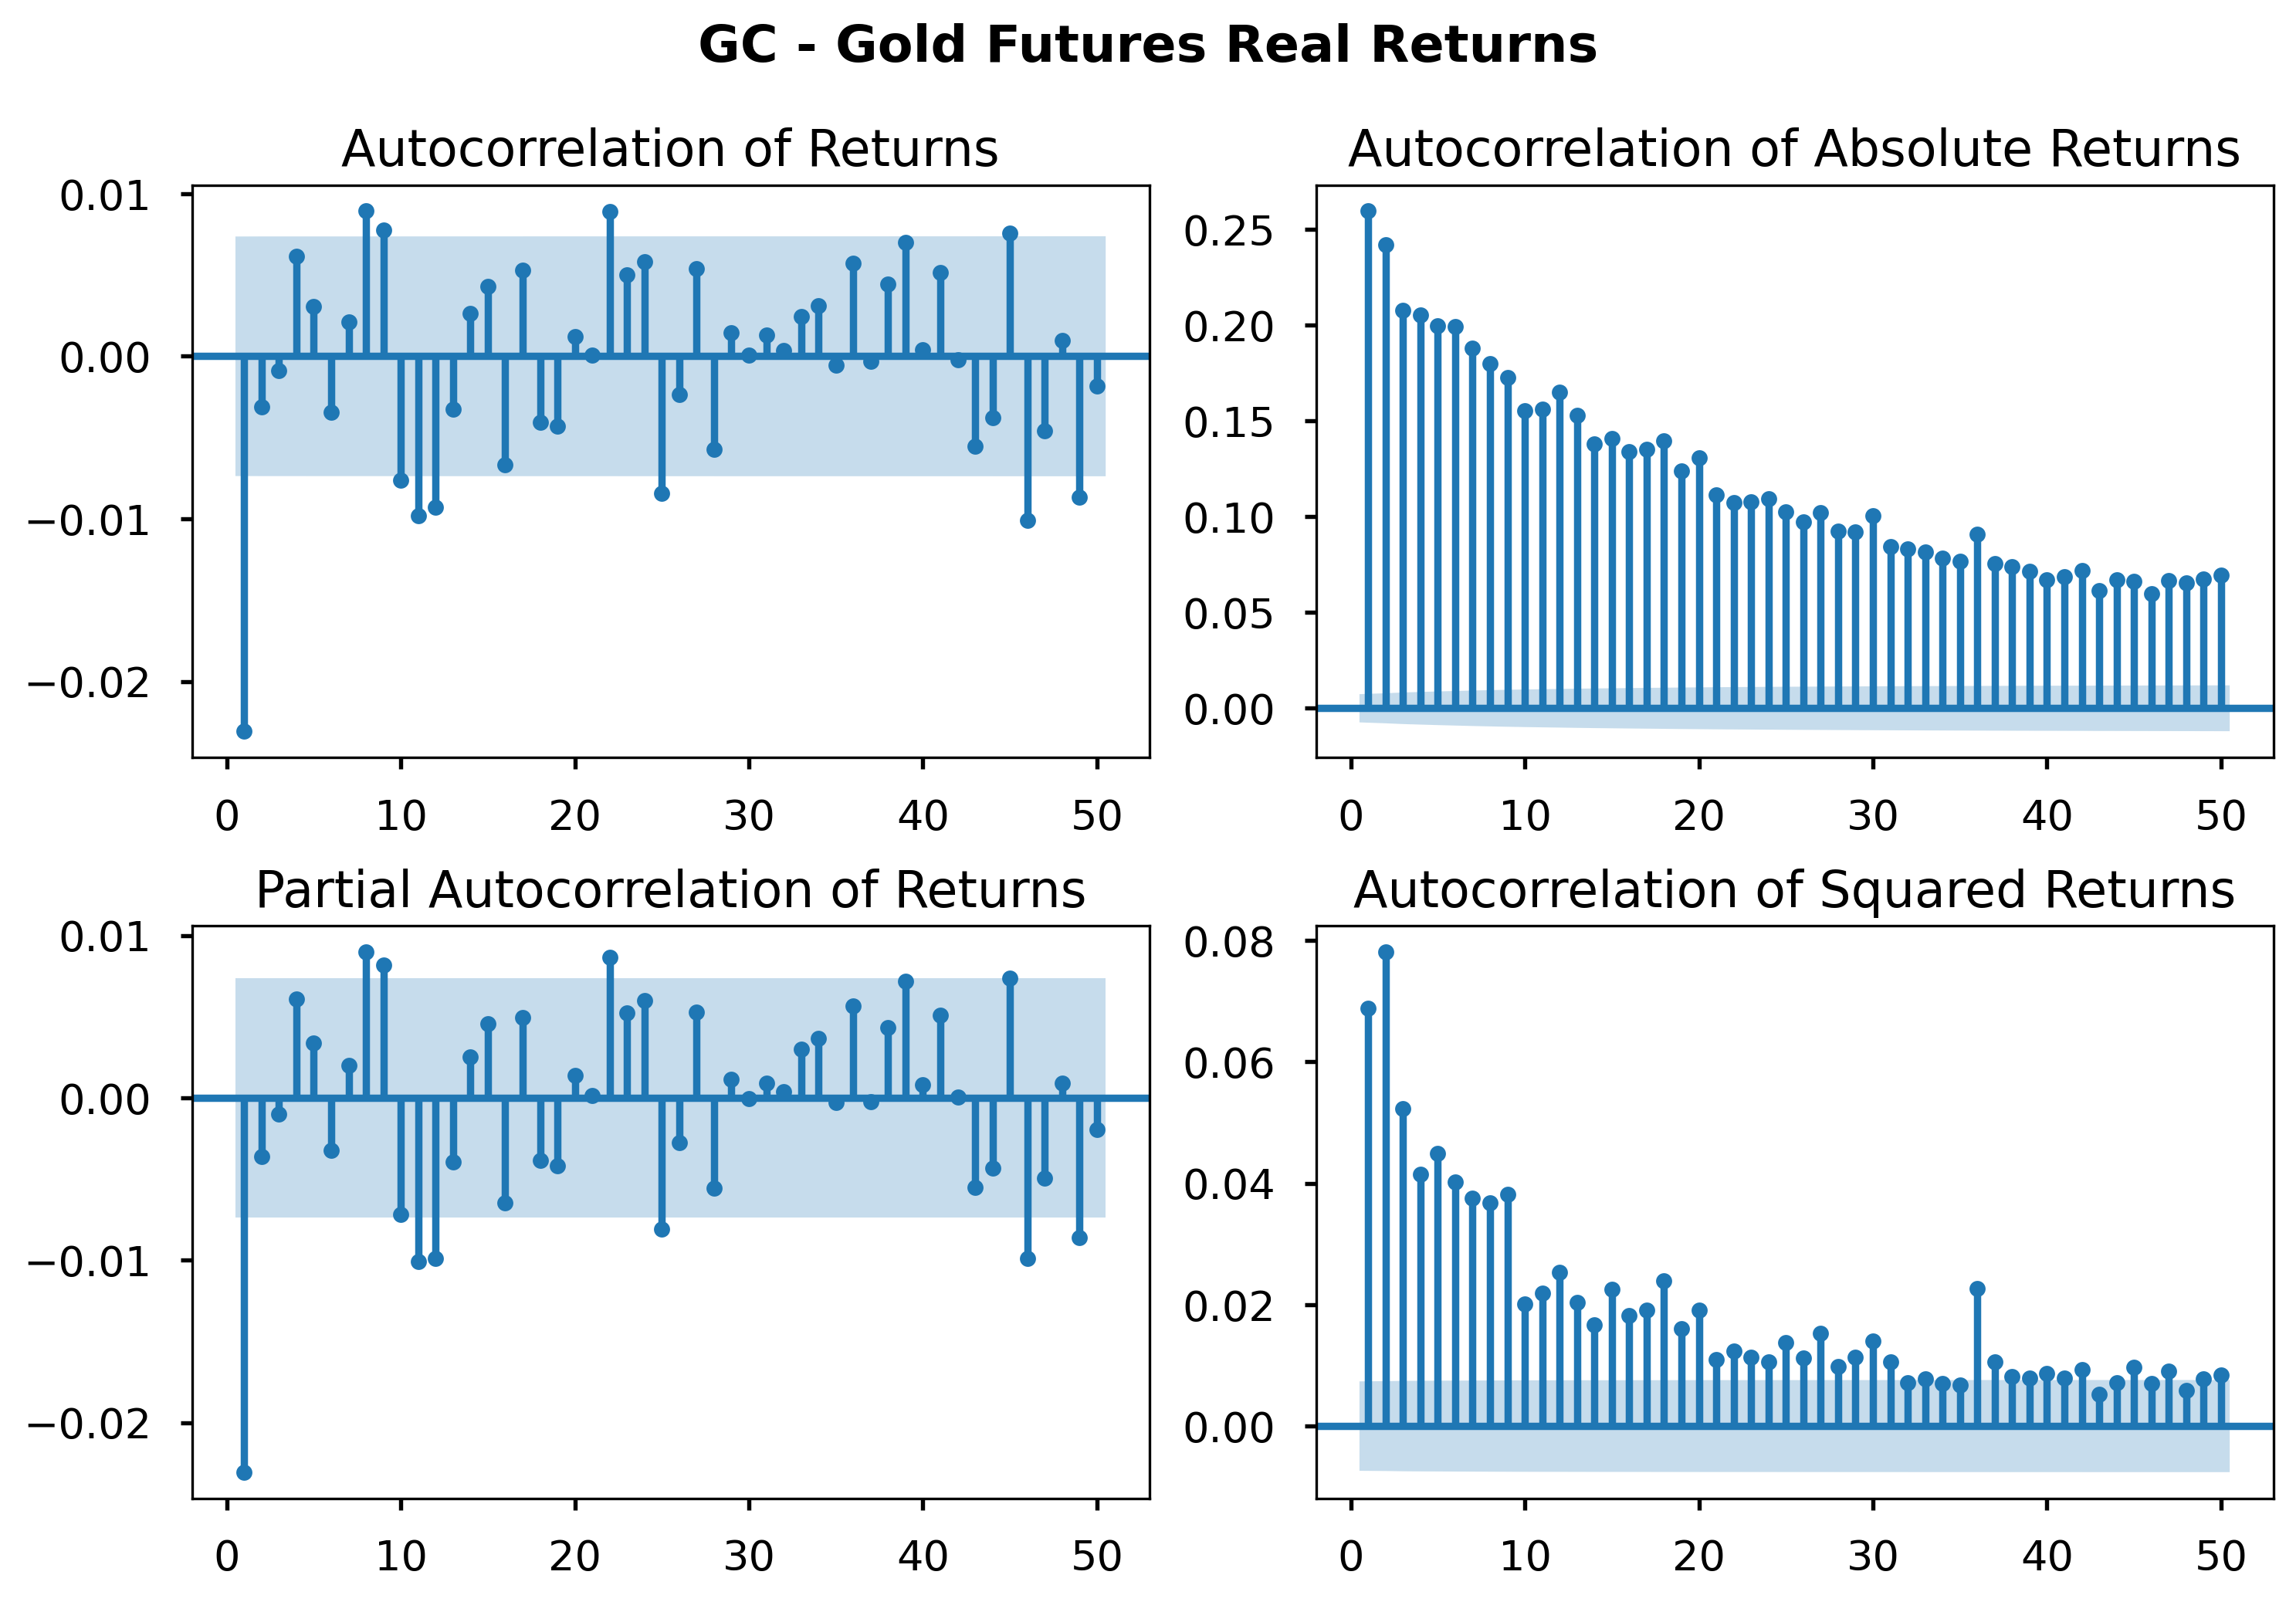

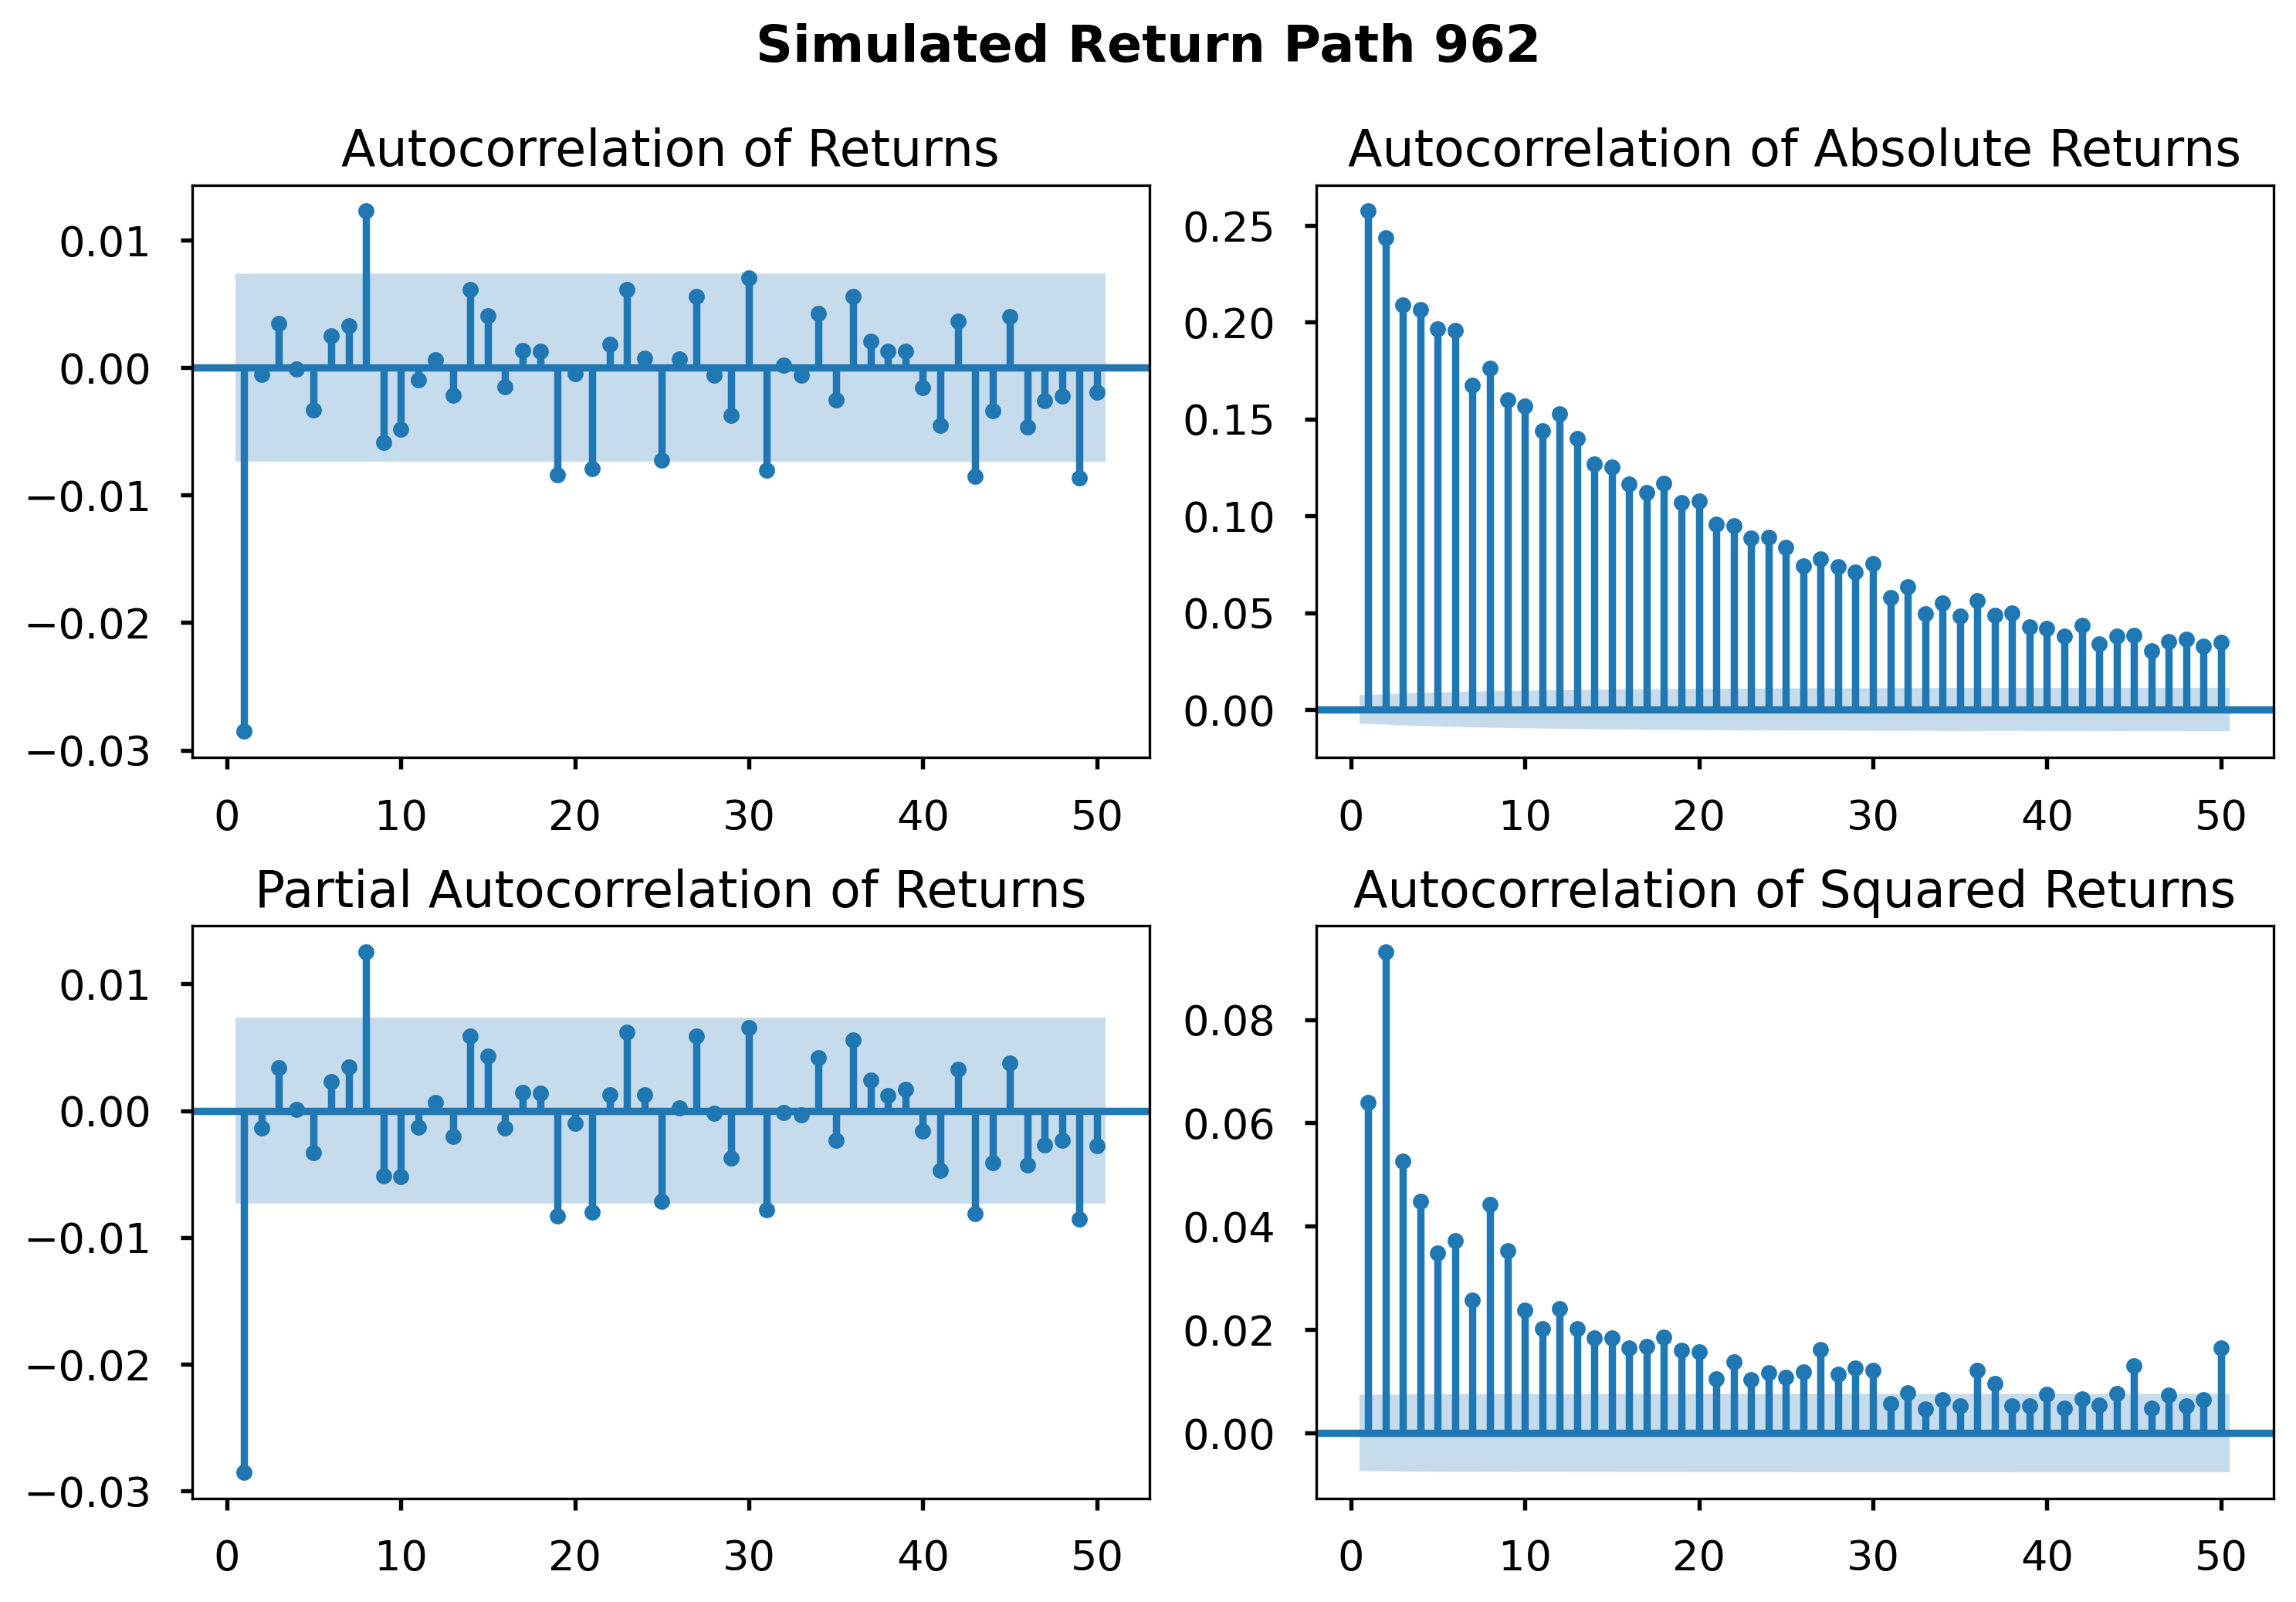

In [16]:
view_all(gc_returns, gc_sim_cbb, cmap=None)

1000it [00:01, 832.64it/s]


NQ - NASDAQ 100 Futures         126         858         410  \
count                 70,001.0000 70,001.0000 70,001.0000 70,001.0000   
mean                       0.0000      0.0000      0.0000     -0.0000   
std                        0.0006      0.0006      0.0006      0.0006   
min                       -0.0172     -0.0125     -0.0172     -0.0172   
25%                       -0.0002     -0.0002     -0.0002     -0.0002   
50%                        0.0000      0.0000      0.0000      0.0000   
75%                        0.0002      0.0002      0.0002      0.0002   
max                        0.0127      0.0105      0.0127      0.0127   
skew                      -0.7702     -0.7037     -0.4154     -0.9833   
kurtosis                  39.0252     27.4726     48.6054     44.9666   

                 823         534         816         659         564  \
count    70,001.0000 70,001.0000 70,001.0000 70,001.0000 70,001.0000   
mean          0.0000      0.0000      0.0000      0.0000     -0.0000   
std           0.0006      0.0006      0.0006      0.0006      0.0006   
min          -0.0172     -0.0172     -0.0172     -0.0125     -0.0125   
25%          -0.0002     -0.0002     -0.0002     -0.0002     -0.0002   
50%           0.0000      0.0000      0.0000      0.0000      0.0000   
75%           0.0002      0.0002      0.0002      0.0002      0.0002   
max           0.0127      0.0127      0.0127      0.0127      0.0087   
skew         -0.7965     -0.6960     -1.0789     -0.1906     -1.4405   
kurtosis     52.3915     41.7314     51.6925     27.8687     37.1939   

                 971  ...         796         605         910         995  \
count    70,001.0000  ... 70,001.0000 70,001.0000 70,001.0000 70,001.0000   
mean          0.0000  ...      0.0000      0.0000      0.0000      0.0000   
std           0.0006  ...      0.0006      0.0006      0.0006      0.0006   
min          -0.0125  ...     -0.0172     -0.0172     -0.0172     -0.0125   
25%          -0.0002  ...     -0.0002     -0.0002     -0.0002     -0.0002   
50%           0.0000  ...      0.0000      0.0000      0.0000      0.0000   
75%           0.0002  ...      0.0002      0.0002      0.0002      0.0002   
max           0.0127  ...      0.0127      0.0087      0.0105      0.0105   
skew         -0.5011  ...     -1.3023     -0.7890     -0.5866     -0.3956   
kurtosis     29.3798  ...     48.2675     32.9217     32.3593     28.4127   

                 810         613         473         680         880  \
count    70,001.0000 70,001.0000 70,001.0000 70,001.0000 70,001.0000   
mean          0.0000     -0.0000      0.0000      0.0000      0.0000   
std           0.0006      0.0006      0.0006      0.0006      0.0006   
min          -0.0172     -0.0172     -0.0172     -0.0172     -0.0172   
25%          -0.0002     -0.0002     -0.0002     -0.0002     -0.0002   
50%           0.0000      0.0000      0.0000      0.0000      0.0000   
75%           0.0002      0.0002      0.0002      0.0002      0.0002   
max           0.0127      0.0105      0.0127      0.0105      0.0127   
skew         -1.2435     -1.0513     -0.6876     -1.3281     -1.3254   
kurtosis     56.4575     38.3110     52.4506     44.6011     55.6516   

                  23  
count    70,001.0000  
mean          0.0000  
std           0.0006  
min          -0.0172  
25%          -0.0002  
50%           0.0000  
75%           0.0002  
max           0.0127  
skew         -0.6714  
kurtosis     39.2293  

[10 rows x 21 columns]

<Figure size 3000x2100 with 0 Axes>

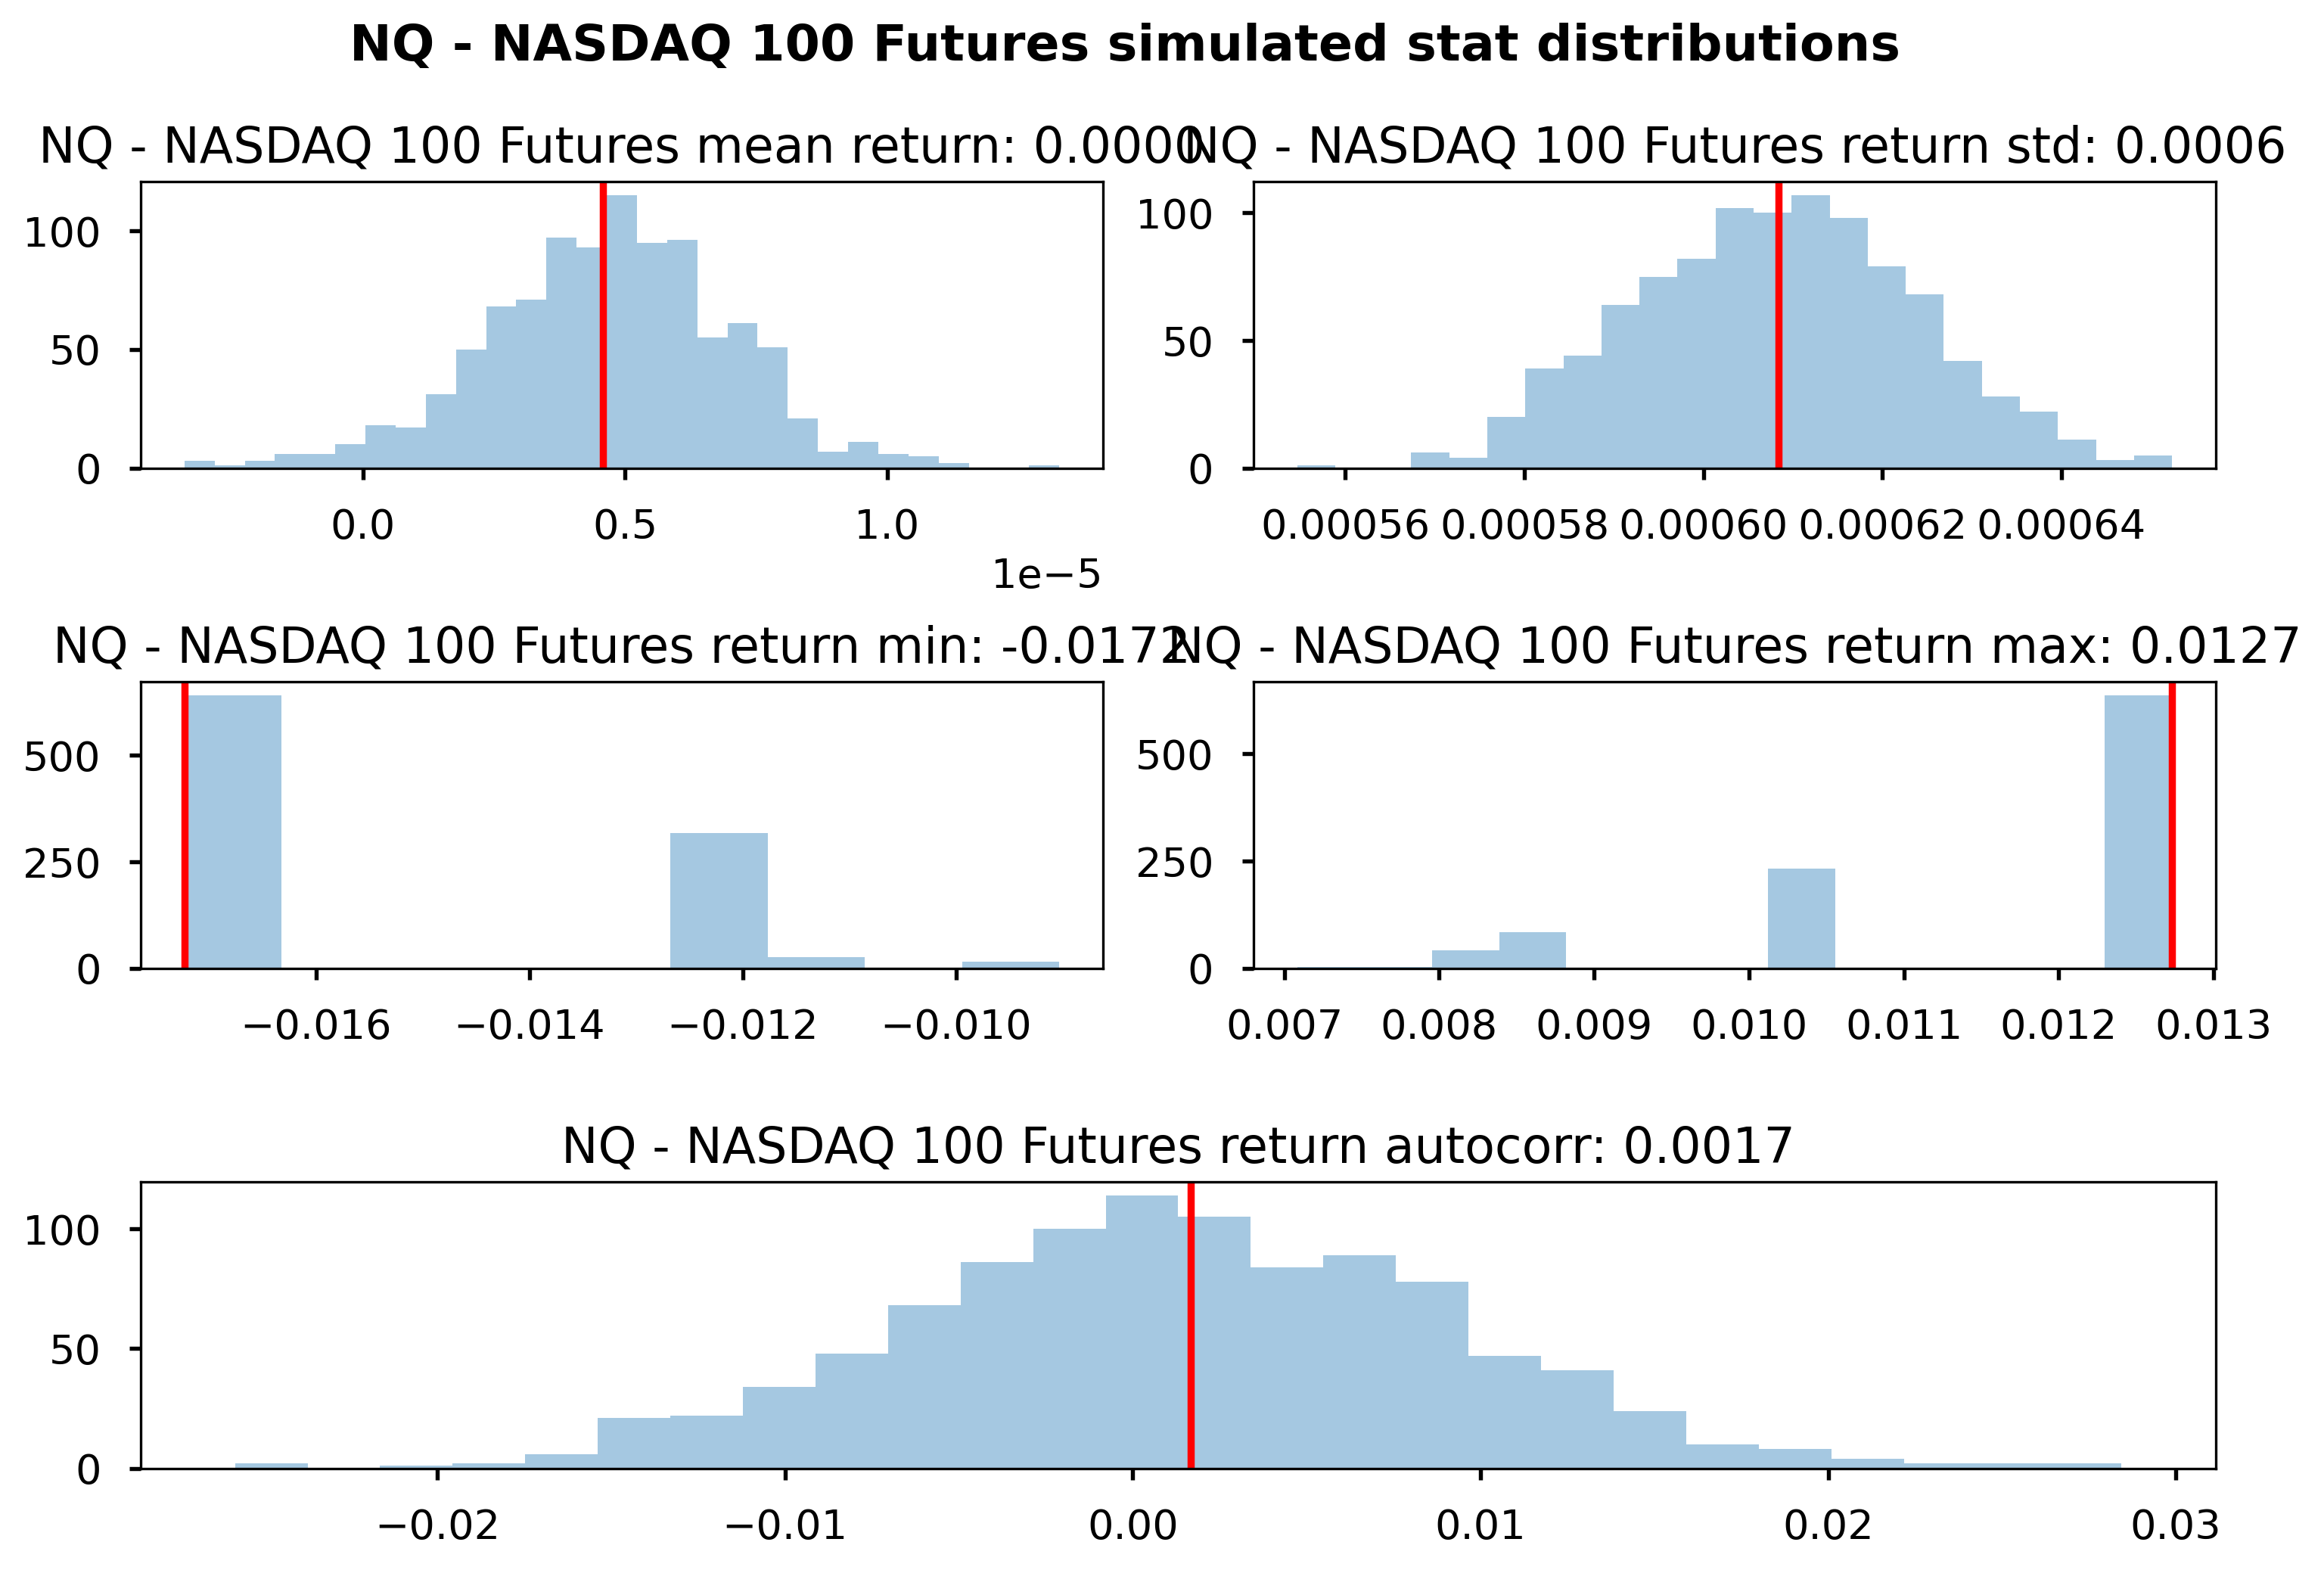

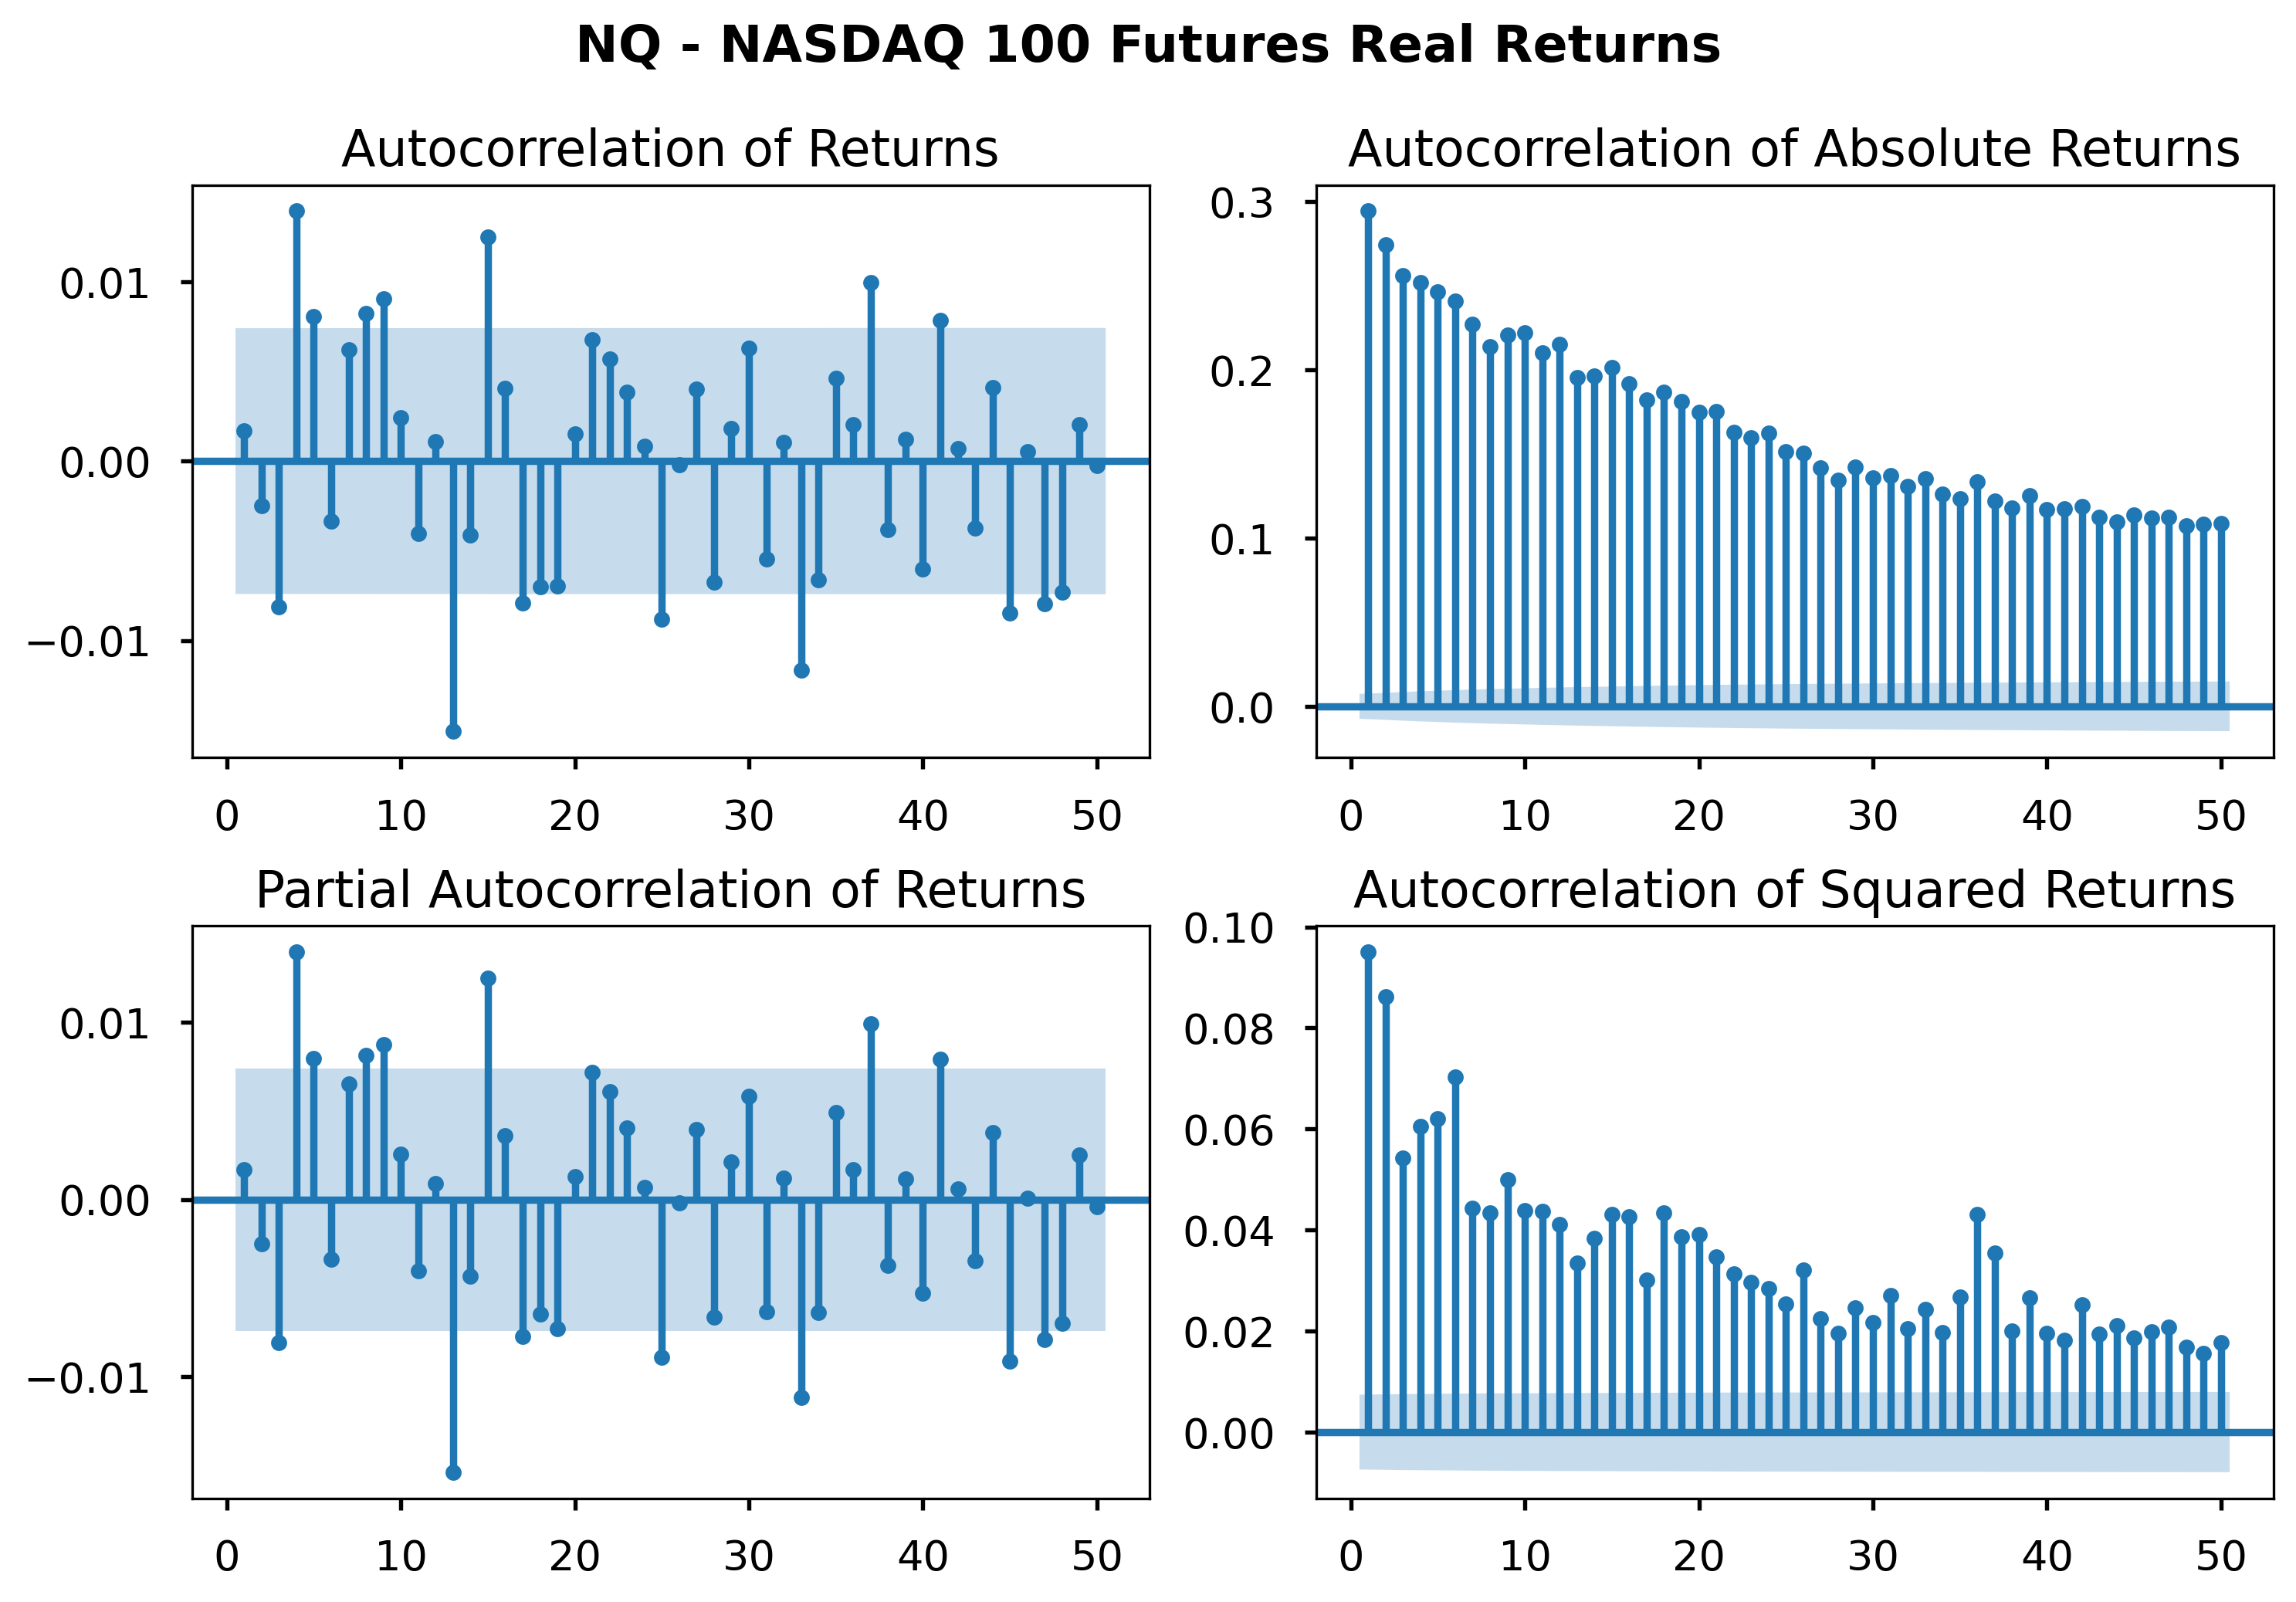

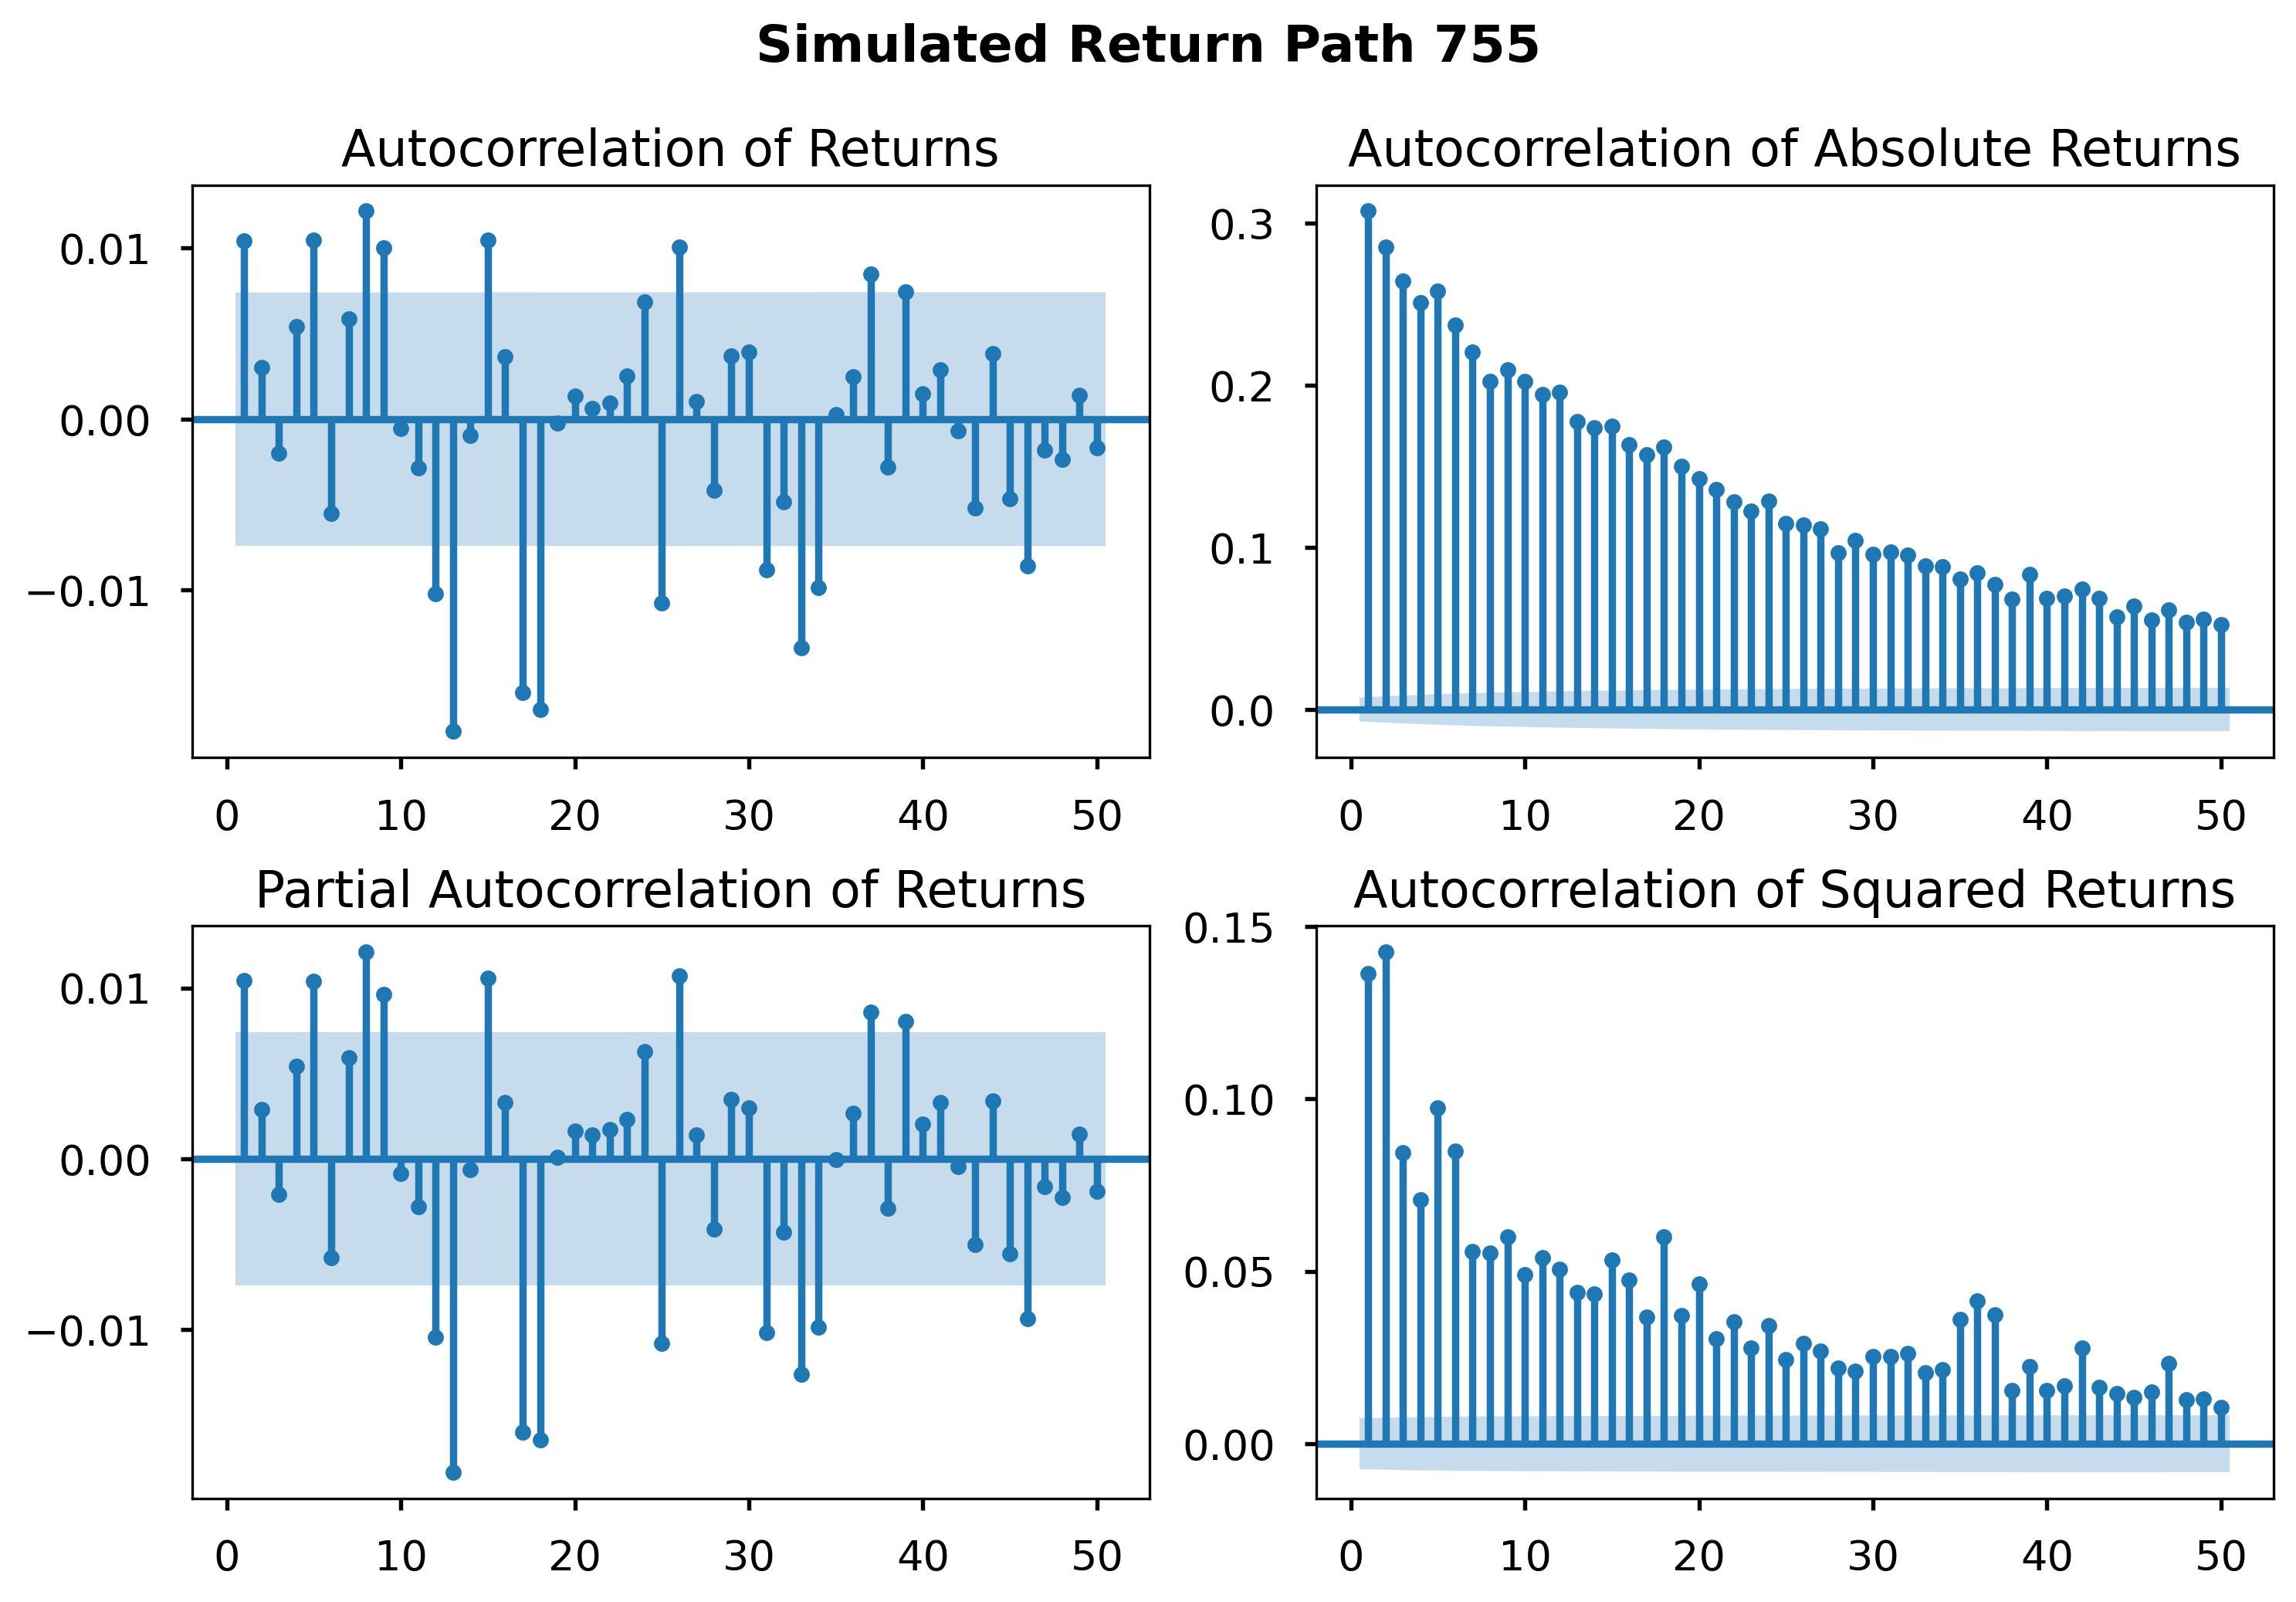

In [17]:
N_paths = 1000
block_size = 100
nq_sim_mbb = MBB(nq_returns, blocksize=block_size, N_paths=N_paths)
view_all(nq_returns, nq_sim_mbb, cmap=None)

In [18]:
N_paths = 1000
block_size = 100
nq_sim_iid = IIDB(nq_returns, N_paths=N_paths)

1000it [00:02, 360.21it/s]


NQ - NASDAQ 100 Futures         181         303         276  \
count                 70,001.0000 70,001.0000 70,001.0000 70,001.0000   
mean                       0.0000      0.0000      0.0000      0.0000   
std                        0.0006      0.0006      0.0006      0.0006   
min                       -0.0172     -0.0172     -0.0125     -0.0172   
25%                       -0.0002     -0.0002     -0.0002     -0.0002   
50%                        0.0000      0.0000      0.0000      0.0000   
75%                        0.0002      0.0002      0.0002      0.0002   
max                        0.0127      0.0127      0.0127      0.0083   
skew                      -0.7702     -0.5863     -0.2188     -1.3134   
kurtosis                  39.0252     45.0100     25.5607     45.0384   

                 246         697          79          89         431  \
count    70,001.0000 70,001.0000 70,001.0000 70,001.0000 70,001.0000   
mean          0.0000      0.0000      0.0000      0.0000     -0.0000   
std           0.0006      0.0006      0.0006      0.0006      0.0006   
min          -0.0109     -0.0125     -0.0172     -0.0125     -0.0125   
25%          -0.0002     -0.0002     -0.0002     -0.0002     -0.0002   
50%           0.0000      0.0000      0.0000      0.0000      0.0000   
75%           0.0002      0.0002      0.0002      0.0002      0.0002   
max           0.0127      0.0127      0.0105      0.0127      0.0127   
skew         -0.5796     -0.3391     -1.2744     -0.6651     -0.4069   
kurtosis     26.1835     26.6063     43.2266     33.6007     29.1088   

                 565  ...         874         146         600         338  \
count    70,001.0000  ... 70,001.0000 70,001.0000 70,001.0000 70,001.0000   
mean          0.0000  ...      0.0000      0.0000      0.0000      0.0000   
std           0.0006  ...      0.0006      0.0006      0.0006      0.0006   
min          -0.0125  ...     -0.0125     -0.0172     -0.0172     -0.0172   
25%          -0.0002  ...     -0.0002     -0.0002     -0.0002     -0.0002   
50%           0.0000  ...      0.0000      0.0000      0.0000      0.0000   
75%           0.0002  ...      0.0002      0.0002      0.0002      0.0002   
max           0.0105  ...      0.0105      0.0127      0.0105      0.0127   
skew         -1.3732  ...     -0.4881     -0.7240     -0.4564     -1.2673   
kurtosis     38.7558  ...     30.9721     50.1095     30.8269     46.4461   

                 621         131          36         944         373  \
count    70,001.0000 70,001.0000 70,001.0000 70,001.0000 70,001.0000   
mean          0.0000      0.0000      0.0000      0.0000      0.0000   
std           0.0006      0.0006      0.0006      0.0006      0.0006   
min          -0.0125     -0.0172     -0.0125     -0.0125     -0.0109   
25%          -0.0002     -0.0002     -0.0002     -0.0002     -0.0002   
50%           0.0000      0.0000      0.0000      0.0000      0.0000   
75%           0.0002      0.0002      0.0002      0.0002      0.0002   
max           0.0127      0.0127      0.0127      0.0105      0.0087   
skew         -0.4818     -1.0969     -0.6558     -0.4616     -0.6634   
kurtosis     34.2783     37.0719     35.6410     25.9107     24.1129   

                 137  
count    70,001.0000  
mean          0.0000  
std           0.0006  
min          -0.0172  
25%          -0.0002  
50%           0.0000  
75%           0.0002  
max           0.0105  
skew         -1.1964  
kurtosis     52.5429  

[10 rows x 21 columns]

<Figure size 3000x2100 with 0 Axes>

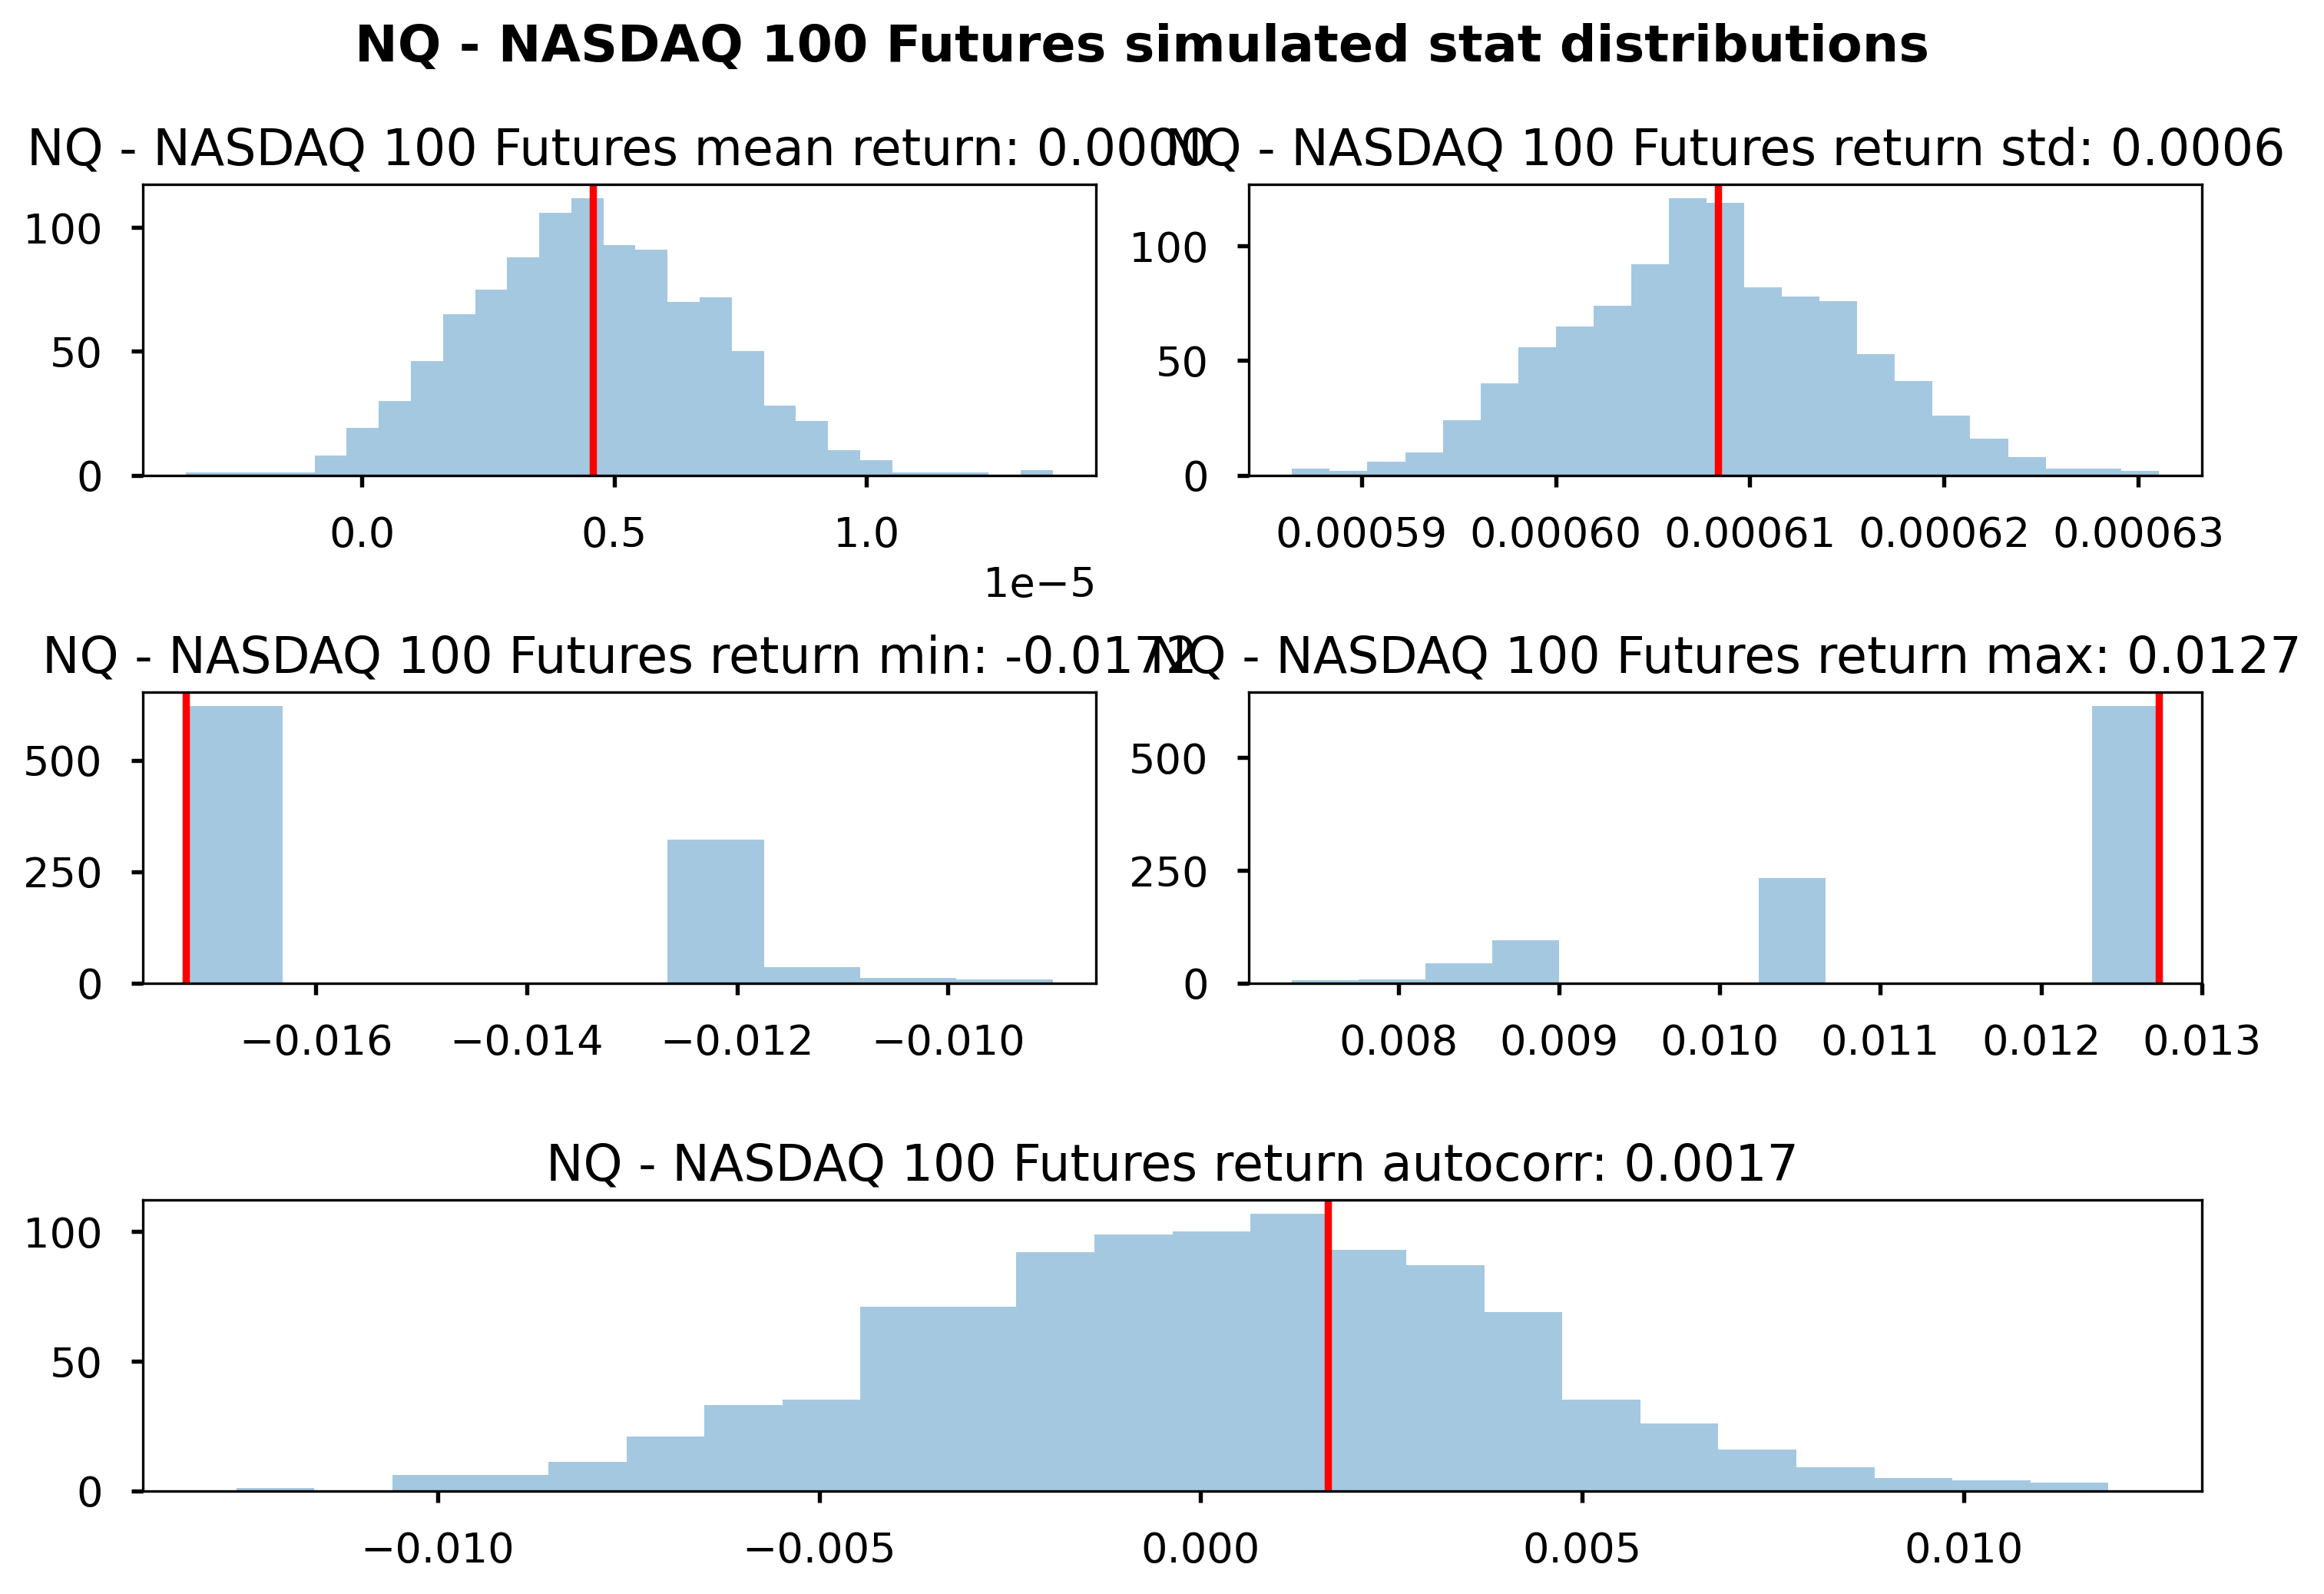

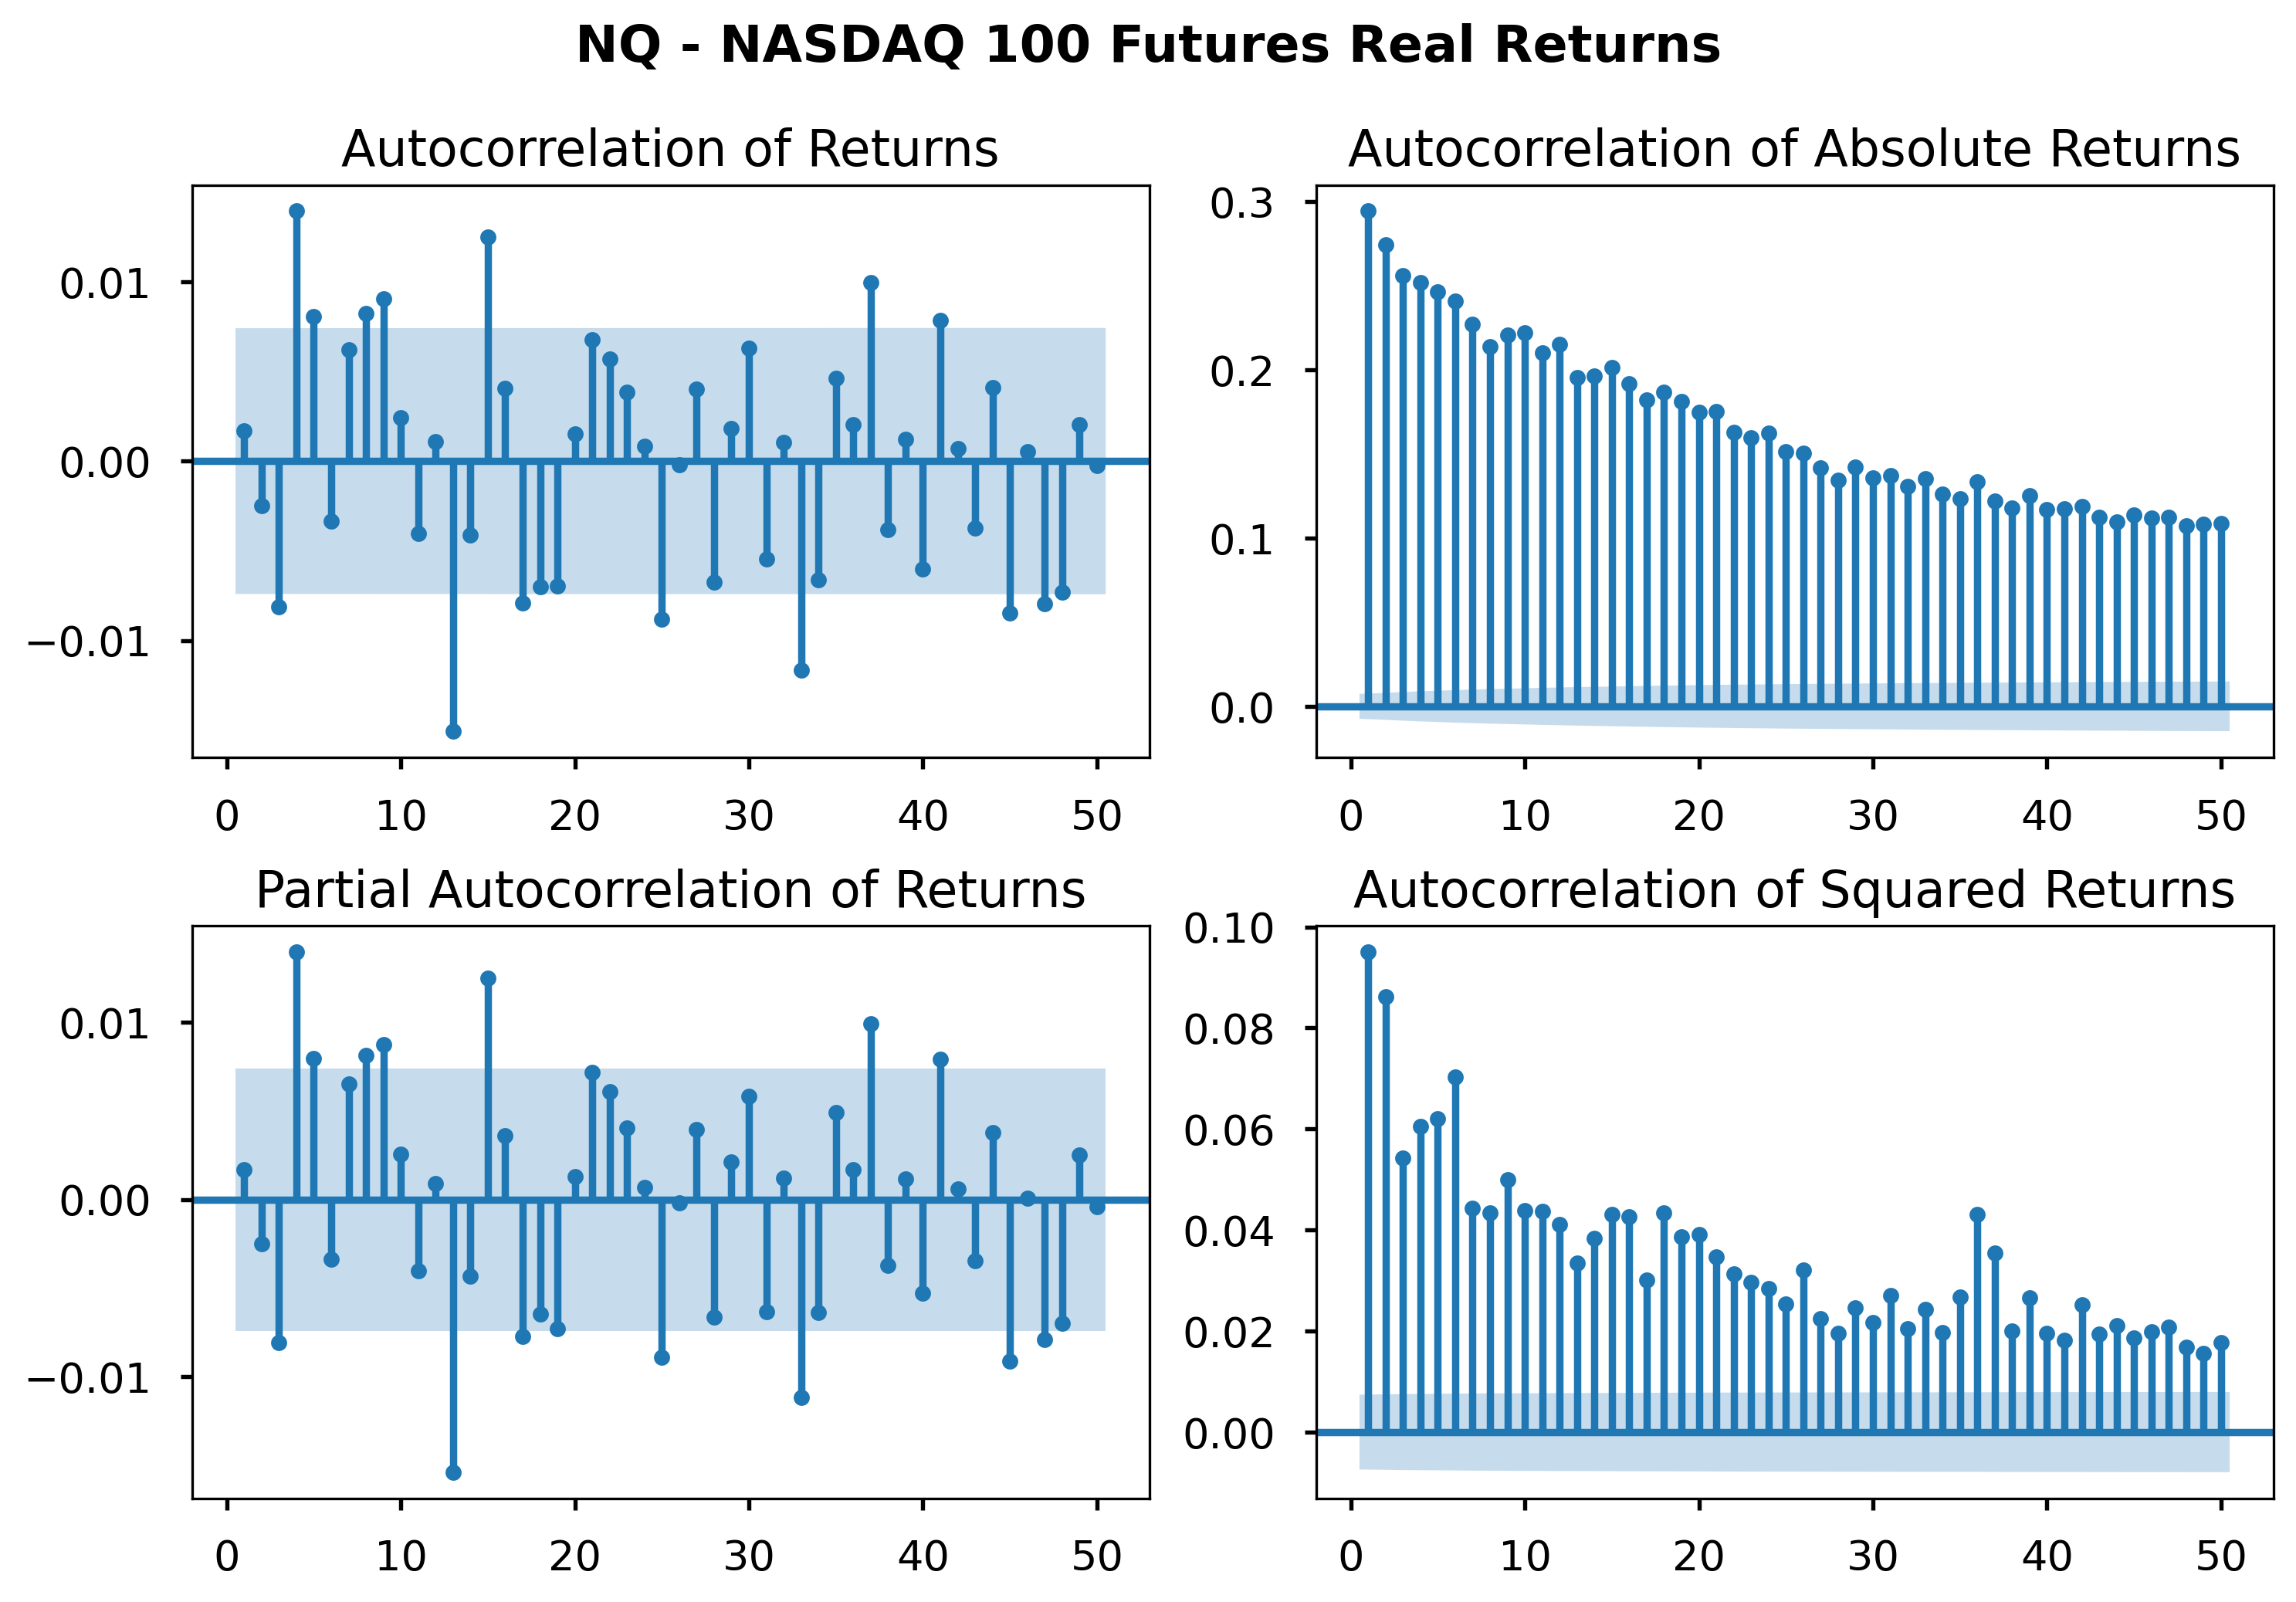

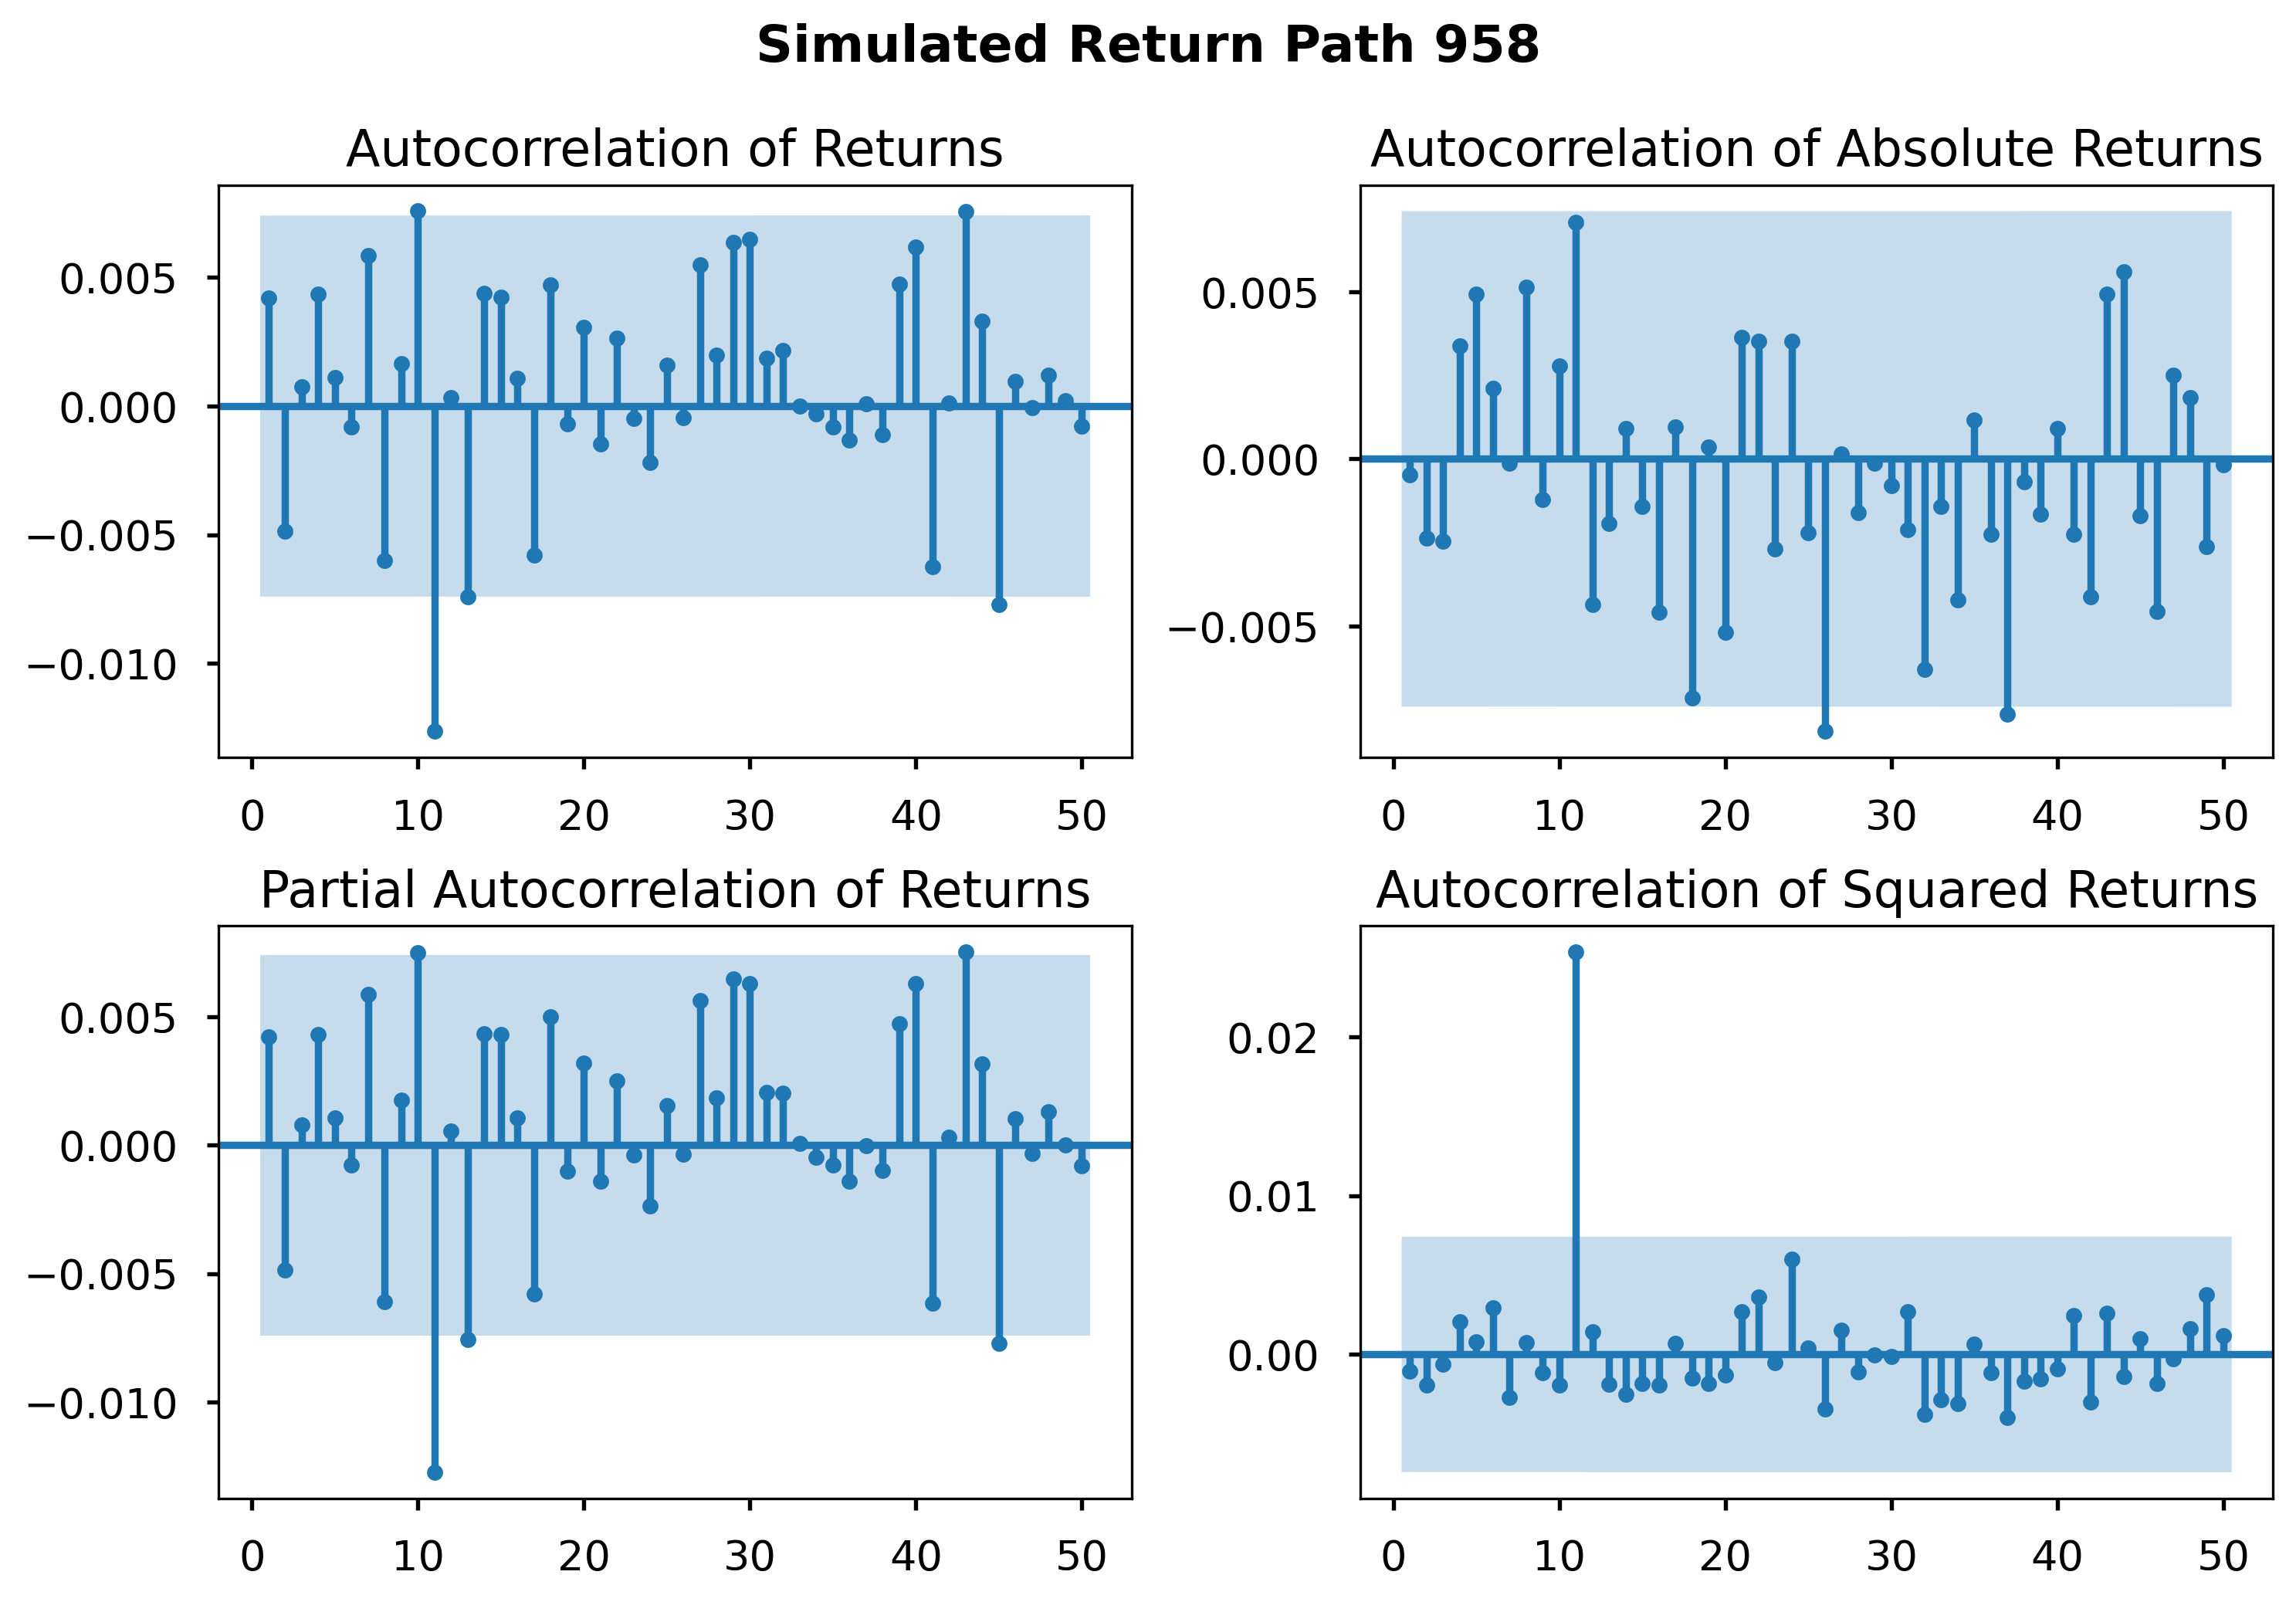

In [19]:
view_all(nq_returns, nq_sim_iid, cmap=None)

0          1          2           3           4    \
2019-01-01 15:05:00  7,500.0000 7,498.7944 7,495.1224  7,502.9129  7,498.0579   
2019-01-01 15:10:00  7,499.7725 7,487.6497 7,492.4114  7,494.4023  7,500.9270   
2019-01-01 15:15:00  7,499.0877 7,491.0080 7,493.7762  7,499.6865  7,500.6625   
2019-01-01 15:20:00  7,498.1875 7,482.9872 7,496.3698  7,498.9798  7,499.4713   
2019-01-01 15:25:00  7,495.9132 7,482.7731 7,494.9818  7,503.5062  7,500.3982   
...                         ...        ...        ...         ...         ...   
2019-12-31 13:35:00 11,178.1994 9,602.9063 9,386.6158 10,211.1006 11,535.3290   
2019-12-31 13:40:00 11,178.5675 9,601.7004 9,387.2258 10,211.7584 11,537.9274   
2019-12-31 13:45:00 11,178.5675 9,601.7004 9,381.6029 10,214.2123 11,541.0634   
2019-12-31 13:50:00 11,189.2647 9,604.6005 9,383.1890 10,215.2885 11,552.3273   
2019-12-31 13:55:00 11,189.2647 9,610.9296 9,386.5520 10,210.1838 11,554.6631   

                           5           6          7           8           9    \
2019-01-01 15:05:00 7,500.2703  7,495.4776 7,492.6654  7,500.0000  7,499.5269   
2019-01-01 15:10:00 7,502.1375  7,488.5461 7,492.2105  7,500.2285  7,498.1909   
2019-01-01 15:15:00 7,502.1375  7,484.8924 7,487.9280  7,500.7340  7,498.1909   
2019-01-01 15:20:00 7,506.1560  7,482.0179 7,491.1961  7,502.5388  7,501.8429   
2019-01-01 15:25:00 7,506.6471  7,483.9697 7,492.0661  7,487.8808  7,499.9565   
...                        ...         ...        ...         ...         ...   
2019-12-31 13:35:00 9,330.7374 11,714.5124 8,644.6465 14,971.3731 11,240.5143   
2019-12-31 13:40:00 9,326.0396 11,716.2843 8,646.1857 14,966.0388 11,239.0322   
2019-12-31 13:45:00 9,326.0396 11,714.8671 8,645.6003 14,953.8016 11,236.4610   
2019-12-31 13:50:00 9,323.9231 11,714.8671 8,645.6003 14,947.1233 11,232.5264   
2019-12-31 13:55:00 9,321.5245 11,727.1852 8,645.8956 14,952.7579 11,225.1209   

                     ...        990         991        992        993  \
2019-01-01 15:05:00  ... 7,501.4832  7,500.2782 7,500.2591 7,499.7471   
2019-01-01 15:10:00  ... 7,501.7518  7,501.7723 7,497.7027 7,499.4961   
2019-01-01 15:15:00  ... 7,498.5768  7,502.6668 7,496.0877 7,499.2510   
2019-01-01 15:20:00  ... 7,499.0422  7,506.0627 7,496.5332 7,495.9017   
2019-01-01 15:25:00  ... 7,498.5589  7,506.0627 7,500.2457 7,499.7531   
...                  ...        ...         ...        ...        ...   
2019-12-31 13:35:00  ... 9,296.0813 10,244.4945 8,565.2933 8,122.8626   
2019-12-31 13:40:00  ... 9,293.9585 10,246.5383 8,561.9639 8,122.8626   
2019-12-31 13:45:00  ... 9,281.7539 10,234.3436 8,563.0583 8,123.8297   
2019-12-31 13:50:00  ... 9,287.6606 10,226.6706 8,558.0664 8,123.8297   
2019-12-31 13:55:00  ... 9,287.3668 10,224.8378 8,559.6696 8,126.4029   

                            994        995        996        997         998  \
2019-01-01 15:05:00  7,500.9986 7,499.3288 7,502.4743 7,497.0019  7,495.9670   
2019-01-01 15:10:00  7,500.9986 7,507.7496 7,501.2011 7,495.1589  7,495.4732   
2019-01-01 15:15:00  7,508.0175 7,507.0773 7,503.7017 7,493.3056  7,495.7178   
2019-01-01 15:20:00  7,509.5997 7,506.5570 7,500.7869 7,493.0622  7,495.7178   
2019-01-01 15:25:00  7,510.3221 7,503.2637 7,501.7388 7,486.7765  7,495.2224   
...                         ...        ...        ...        ...         ...   
2019-12-31 13:35:00 11,337.5483 9,343.7477 9,199.5613 8,916.7663 10,603.3152   
2019-12-31 13:40:00 11,343.4865 9,344.5498 9,207.4488 8,920.7515 10,603.3152   
2019-12-31 13:45:00 11,343.1203 9,343.3322 9,208.3226 8,921.0489 10,604.2573   
2019-12-31 13:50:00 11,346.7408 9,341.9880 9,208.6204 8,915.9007 10,608.6782   
2019-12-31 13:55:00 11,351.4205 9,341.3928 9,207.7211 8,914.7068 10,609.9173   

                           999  
2019-01-01 15:05:00 7,498.7802  
2019-01-01 15:10:00 7,499.5185  
2019-01-01 15:15:00 7,504.4880  
2019-01-01 15:20:00 7,504.2620  
2019-01-01 15:25:00 7,490.3352  
...                        ...  
2019-12-31 13

<Figure size 3000x2100 with 0 Axes>

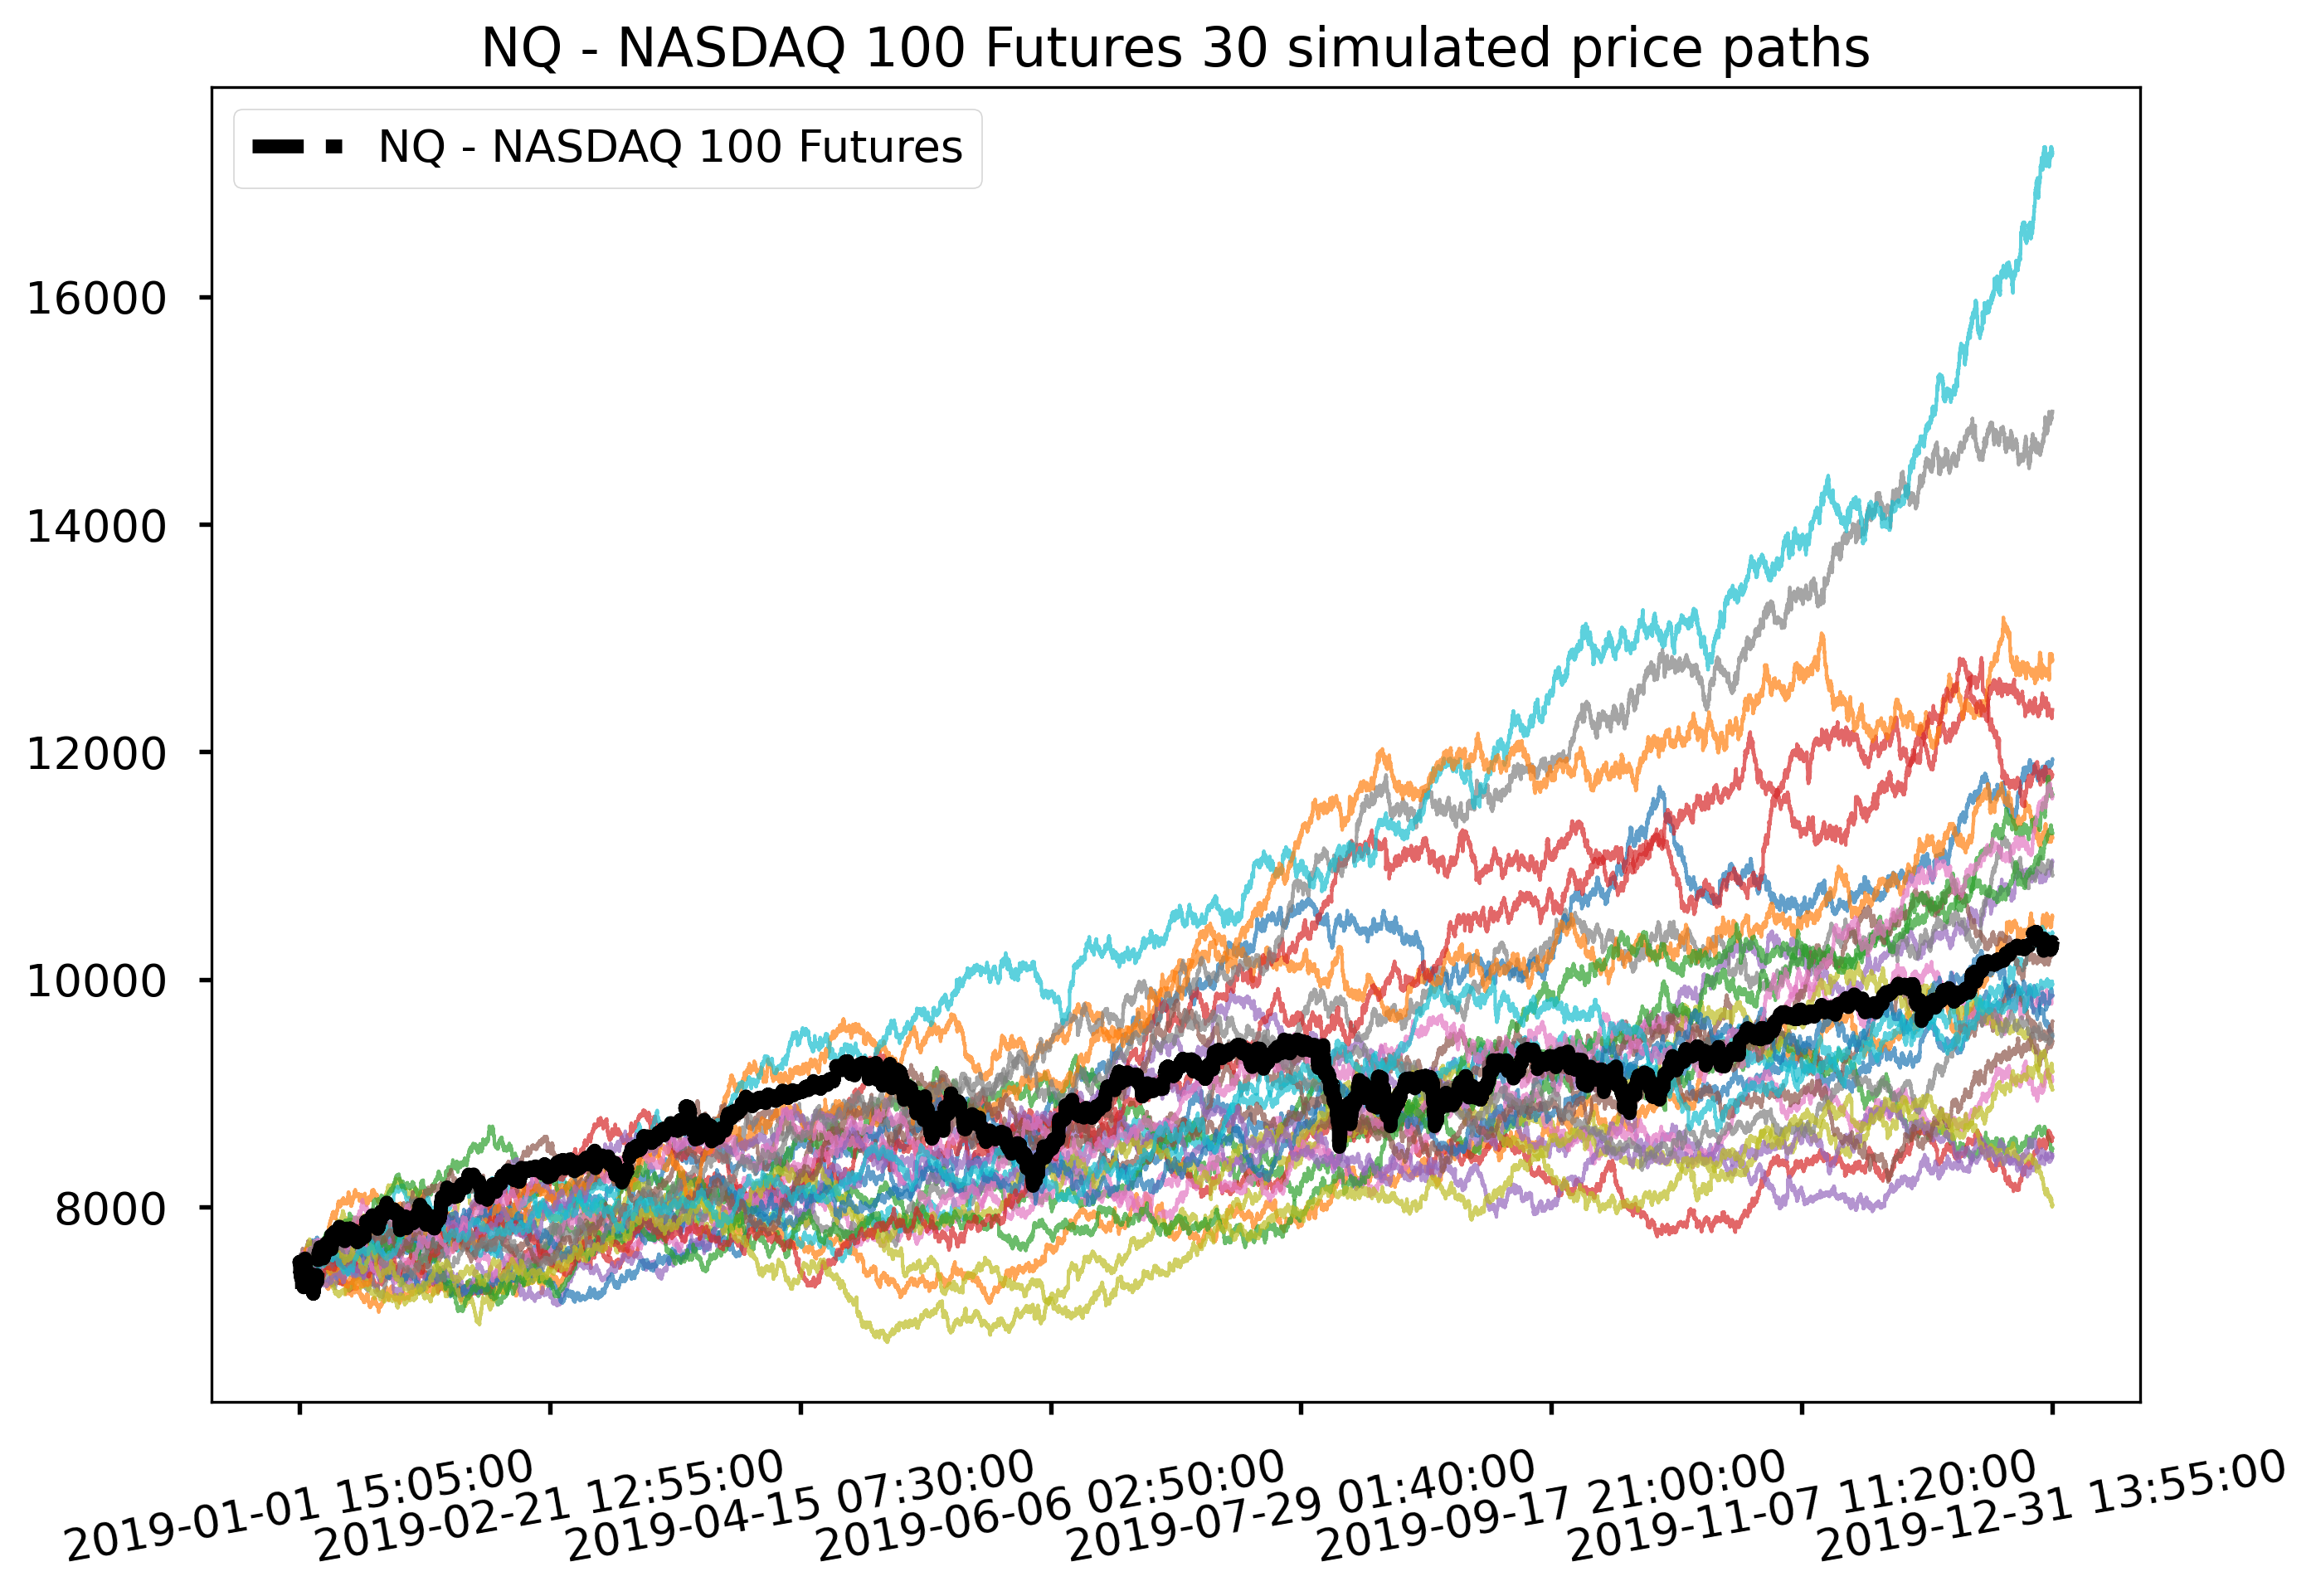

In [20]:
plot_prices(nq_returns, nq_sim_iid, start=7500, price_index=nq.index[1:], n_plot_paths=30, cmap='nanex_cmap')

1000it [00:02, 356.04it/s]


GC - Gold Futures         611         326         289         441  \
count           70,805.0000 70,805.0000 70,805.0000 70,805.0000 70,805.0000   
mean                 0.0000      0.0000      0.0000      0.0000      0.0000   
std                  0.0005      0.0005      0.0005      0.0004      0.0005   
min                 -0.0139     -0.0139     -0.0139     -0.0076     -0.0098   
25%                 -0.0002     -0.0002     -0.0002     -0.0002     -0.0002   
50%                  0.0000      0.0000      0.0000      0.0000      0.0000   
75%                  0.0002      0.0002      0.0002      0.0002      0.0002   
max                  0.0125      0.0125      0.0125      0.0125      0.0125   
skew                 0.2376      0.5333      0.0067      0.9369      0.3583   
kurtosis            56.1125     58.2686     71.1590     44.3308     38.0490   

                 970          38         649         867         648  ...  \
count    70,805.0000 70,805.0000 70,805.0000 70,805.0000 70,805.0000  ...   
mean          0.0000      0.0000      0.0000      0.0000      0.0000  ...   
std           0.0005      0.0005      0.0005      0.0005      0.0005  ...   
min          -0.0098     -0.0139     -0.0098     -0.0139     -0.0098  ...   
25%          -0.0002     -0.0002     -0.0002     -0.0002     -0.0002  ...   
50%           0.0000      0.0000      0.0000      0.0000      0.0000  ...   
75%           0.0002      0.0002      0.0002      0.0002      0.0002  ...   
max           0.0125      0.0125      0.0106      0.0125      0.0106  ...   
skew          0.7093      0.0354     -0.0169     -1.2213      0.2766  ...   
kurtosis     51.1812     48.2067     44.4197     83.0743     42.4268  ...   

                  99         859         301         861          81  \
count    70,805.0000 70,805.0000 70,805.0000 70,805.0000 70,805.0000   
mean          0.0000      0.0000      0.0000      0.0000      0.0000   
std           0.0005      0.0004      0.0005      0.0005      0.0005   
min          -0.0139     -0.0076     -0.0098     -0.0139     -0.0098   
25%          -0.0002     -0.0002     -0.0002     -0.0002     -0.0002   
50%           0.0000      0.0000      0.0000      0.0000      0.0000   
75%           0.0002      0.0002      0.0002      0.0002      0.0002   
max           0.0125      0.0125      0.0125      0.0125      0.0125   
skew         -0.0503     -0.1530      1.0626      1.2864      0.8576   
kurtosis     78.3096     27.2788     50.4300     76.6454     46.8551   

                 753         340          13         832         876  
count    70,805.0000 70,805.0000 70,805.0000 70,805.0000 70,805.0000  
mean          0.0000      0.0000      0.0000      0.0000      0.0000  
std           0.0005      0.0005      0.0004      0.0005      0.0005  
min          -0.0098     -0.0139     -0.0059     -0.0139     -0.0139  
25%          -0.0002     -0.0002     -0.0002     -0.0002     -0.0002  
50%           0.0000      0.0000      0.0000      0.0000      0.0000  
75%           0.0002      0.0002      0.0002      0.0002      0.0002  
max           0.0108      0.0125      0.0125      0.0108      0.0125  
skew          0.7947      0.6532      0.7968     -0.3743      0.7220  
kurtosis     54.7411     61.4812     38.9303     59.1558     61.8532  

[10 rows x 21 columns]

<Figure size 3000x2100 with 0 Axes>

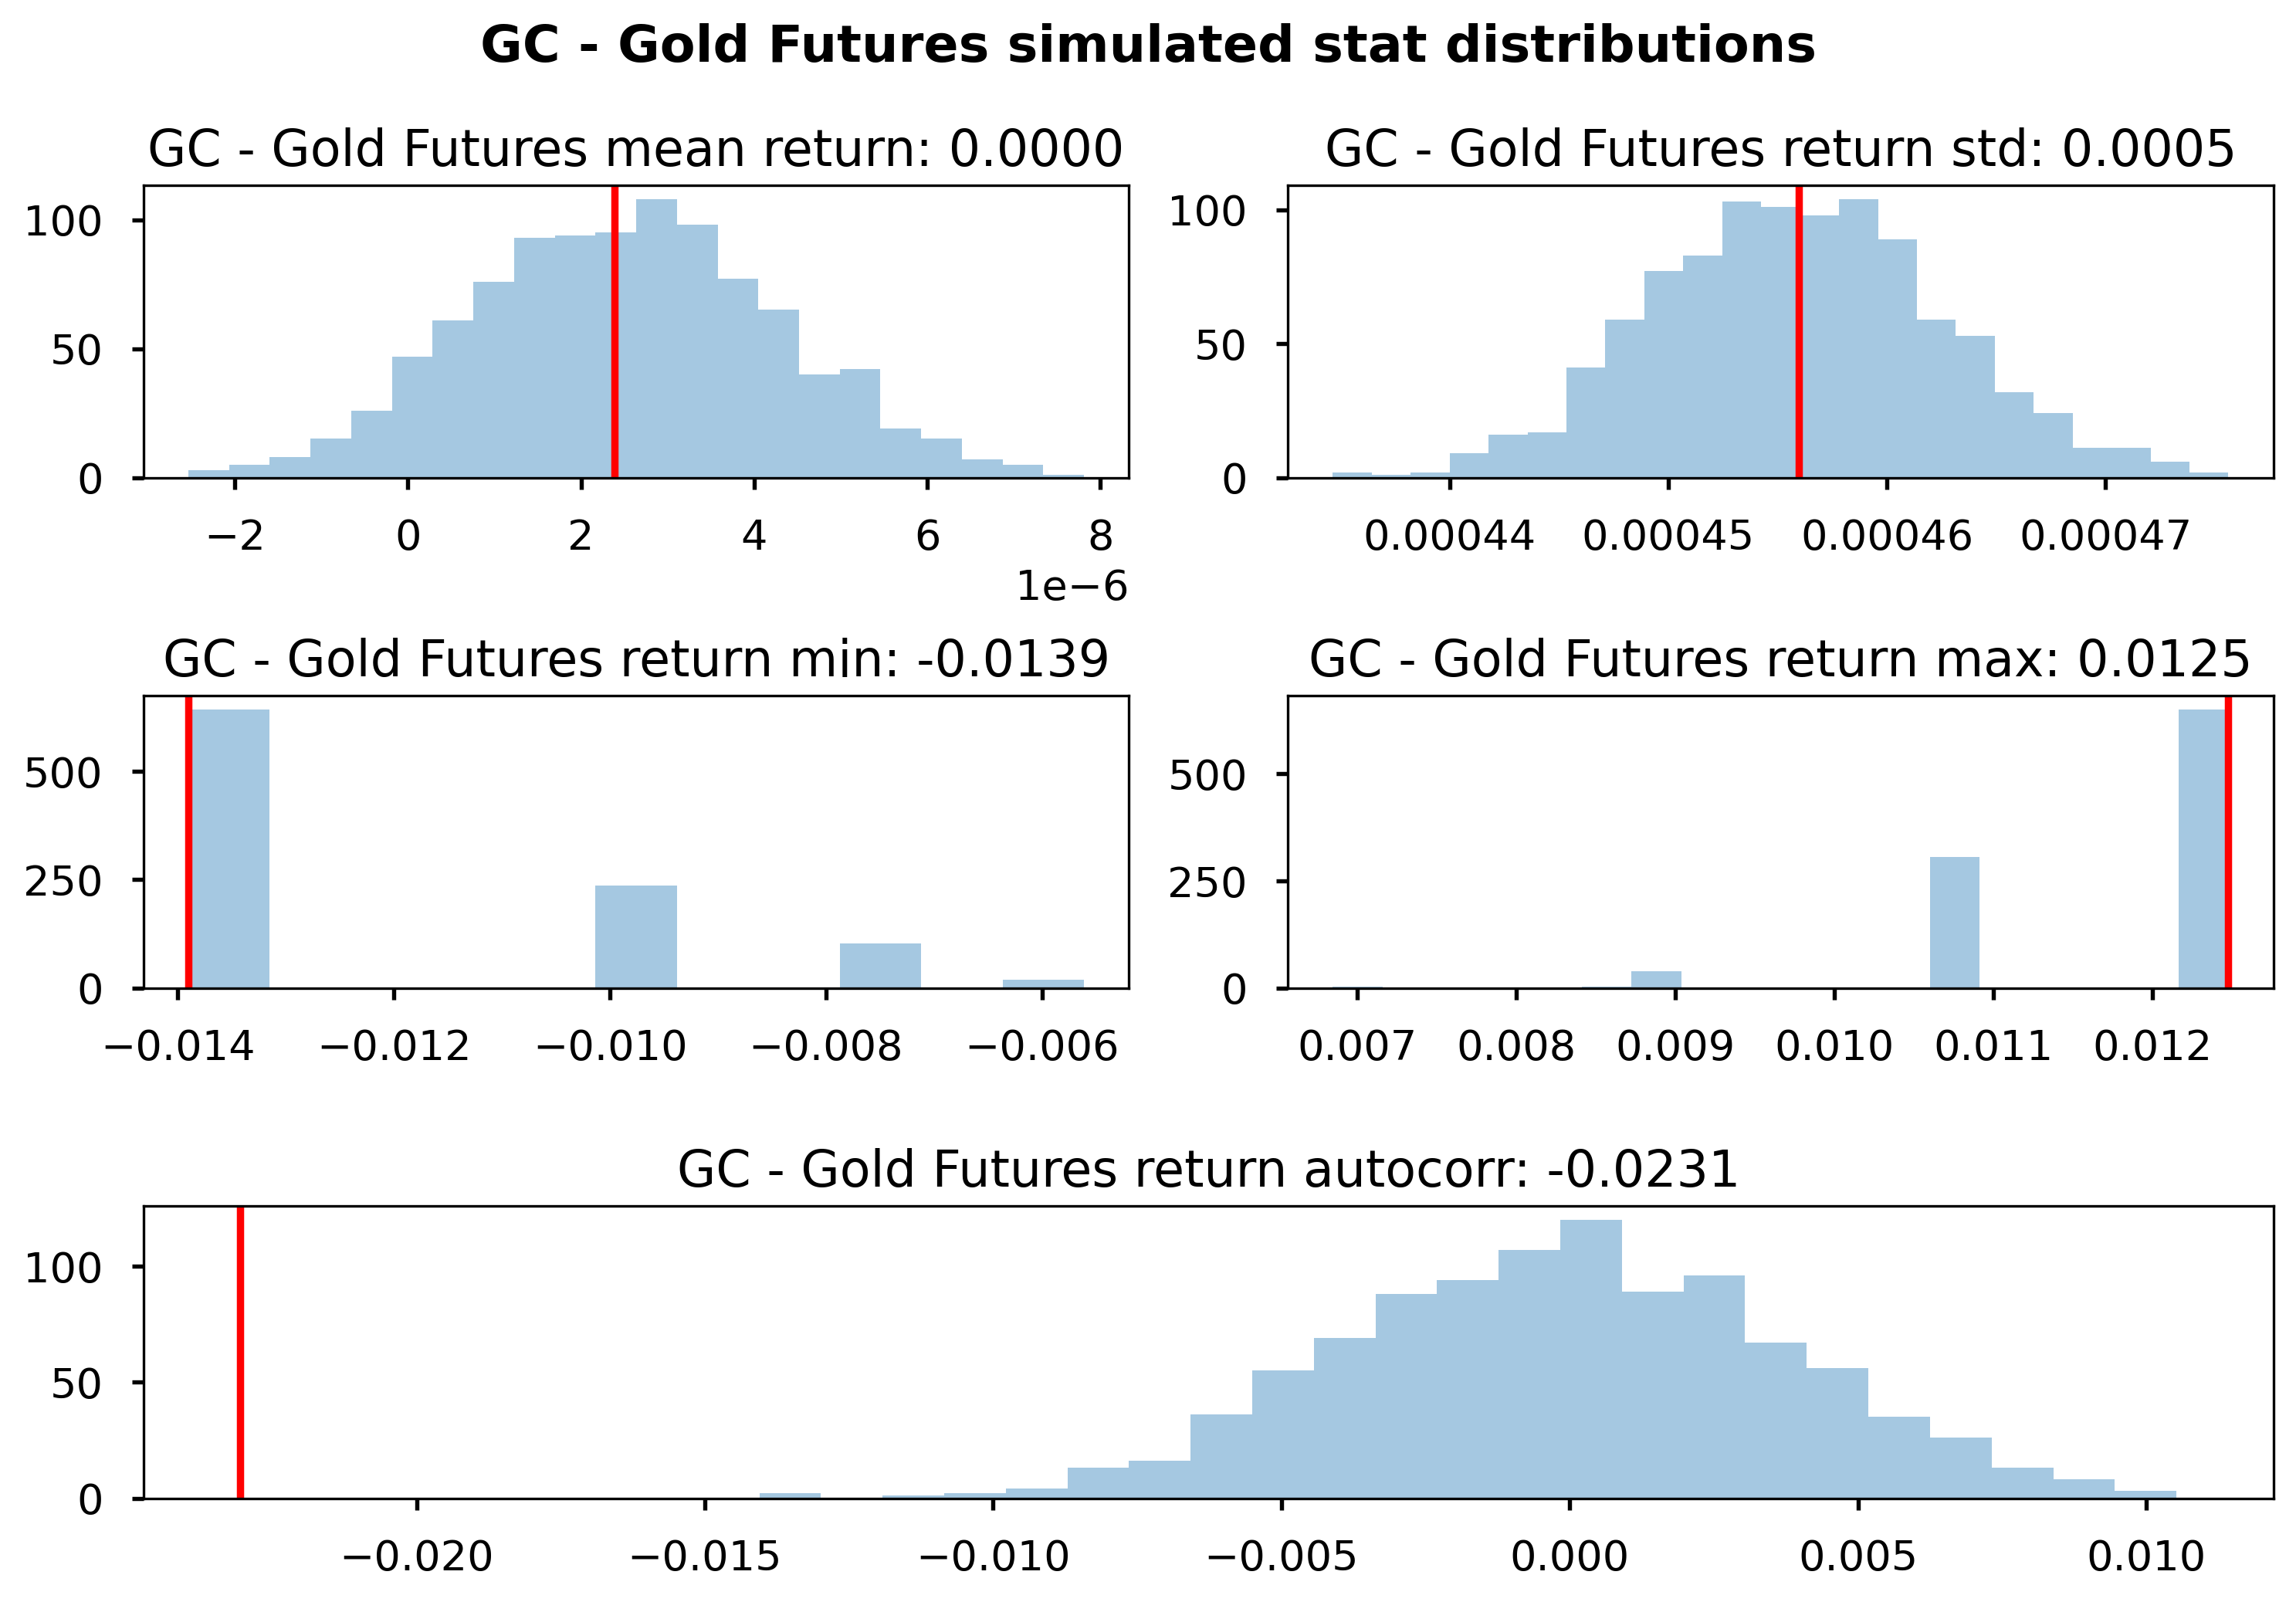

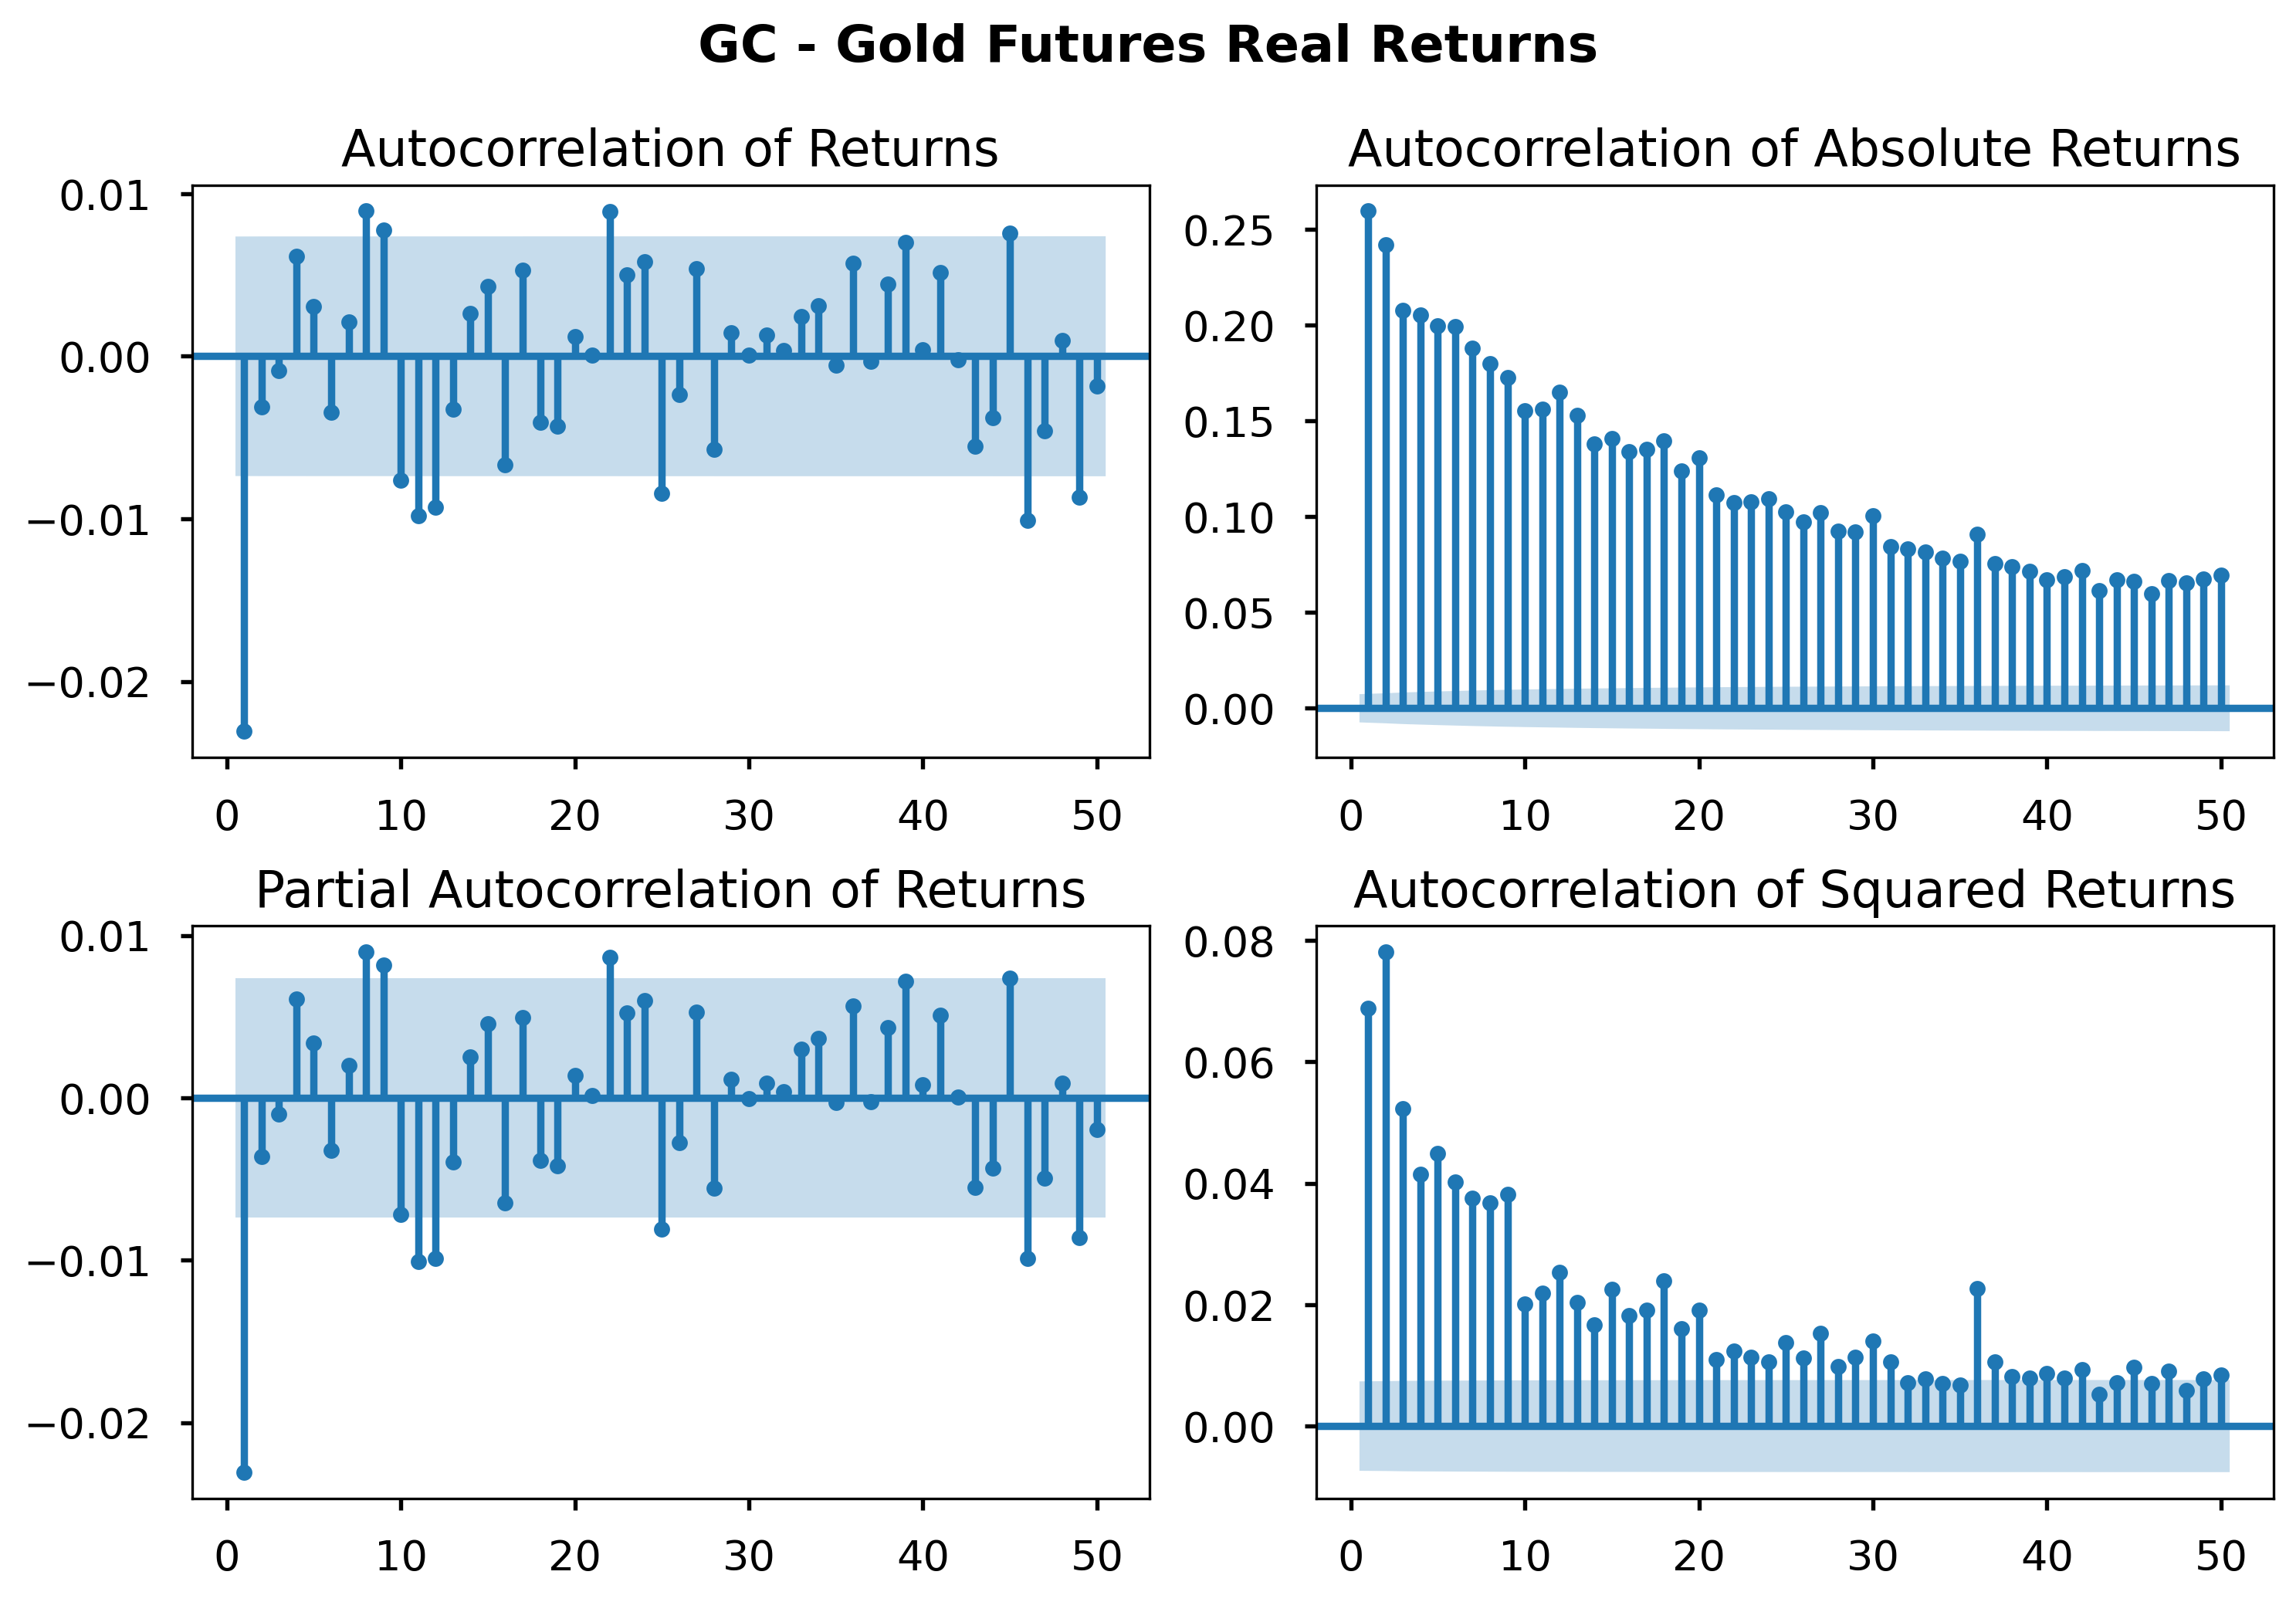

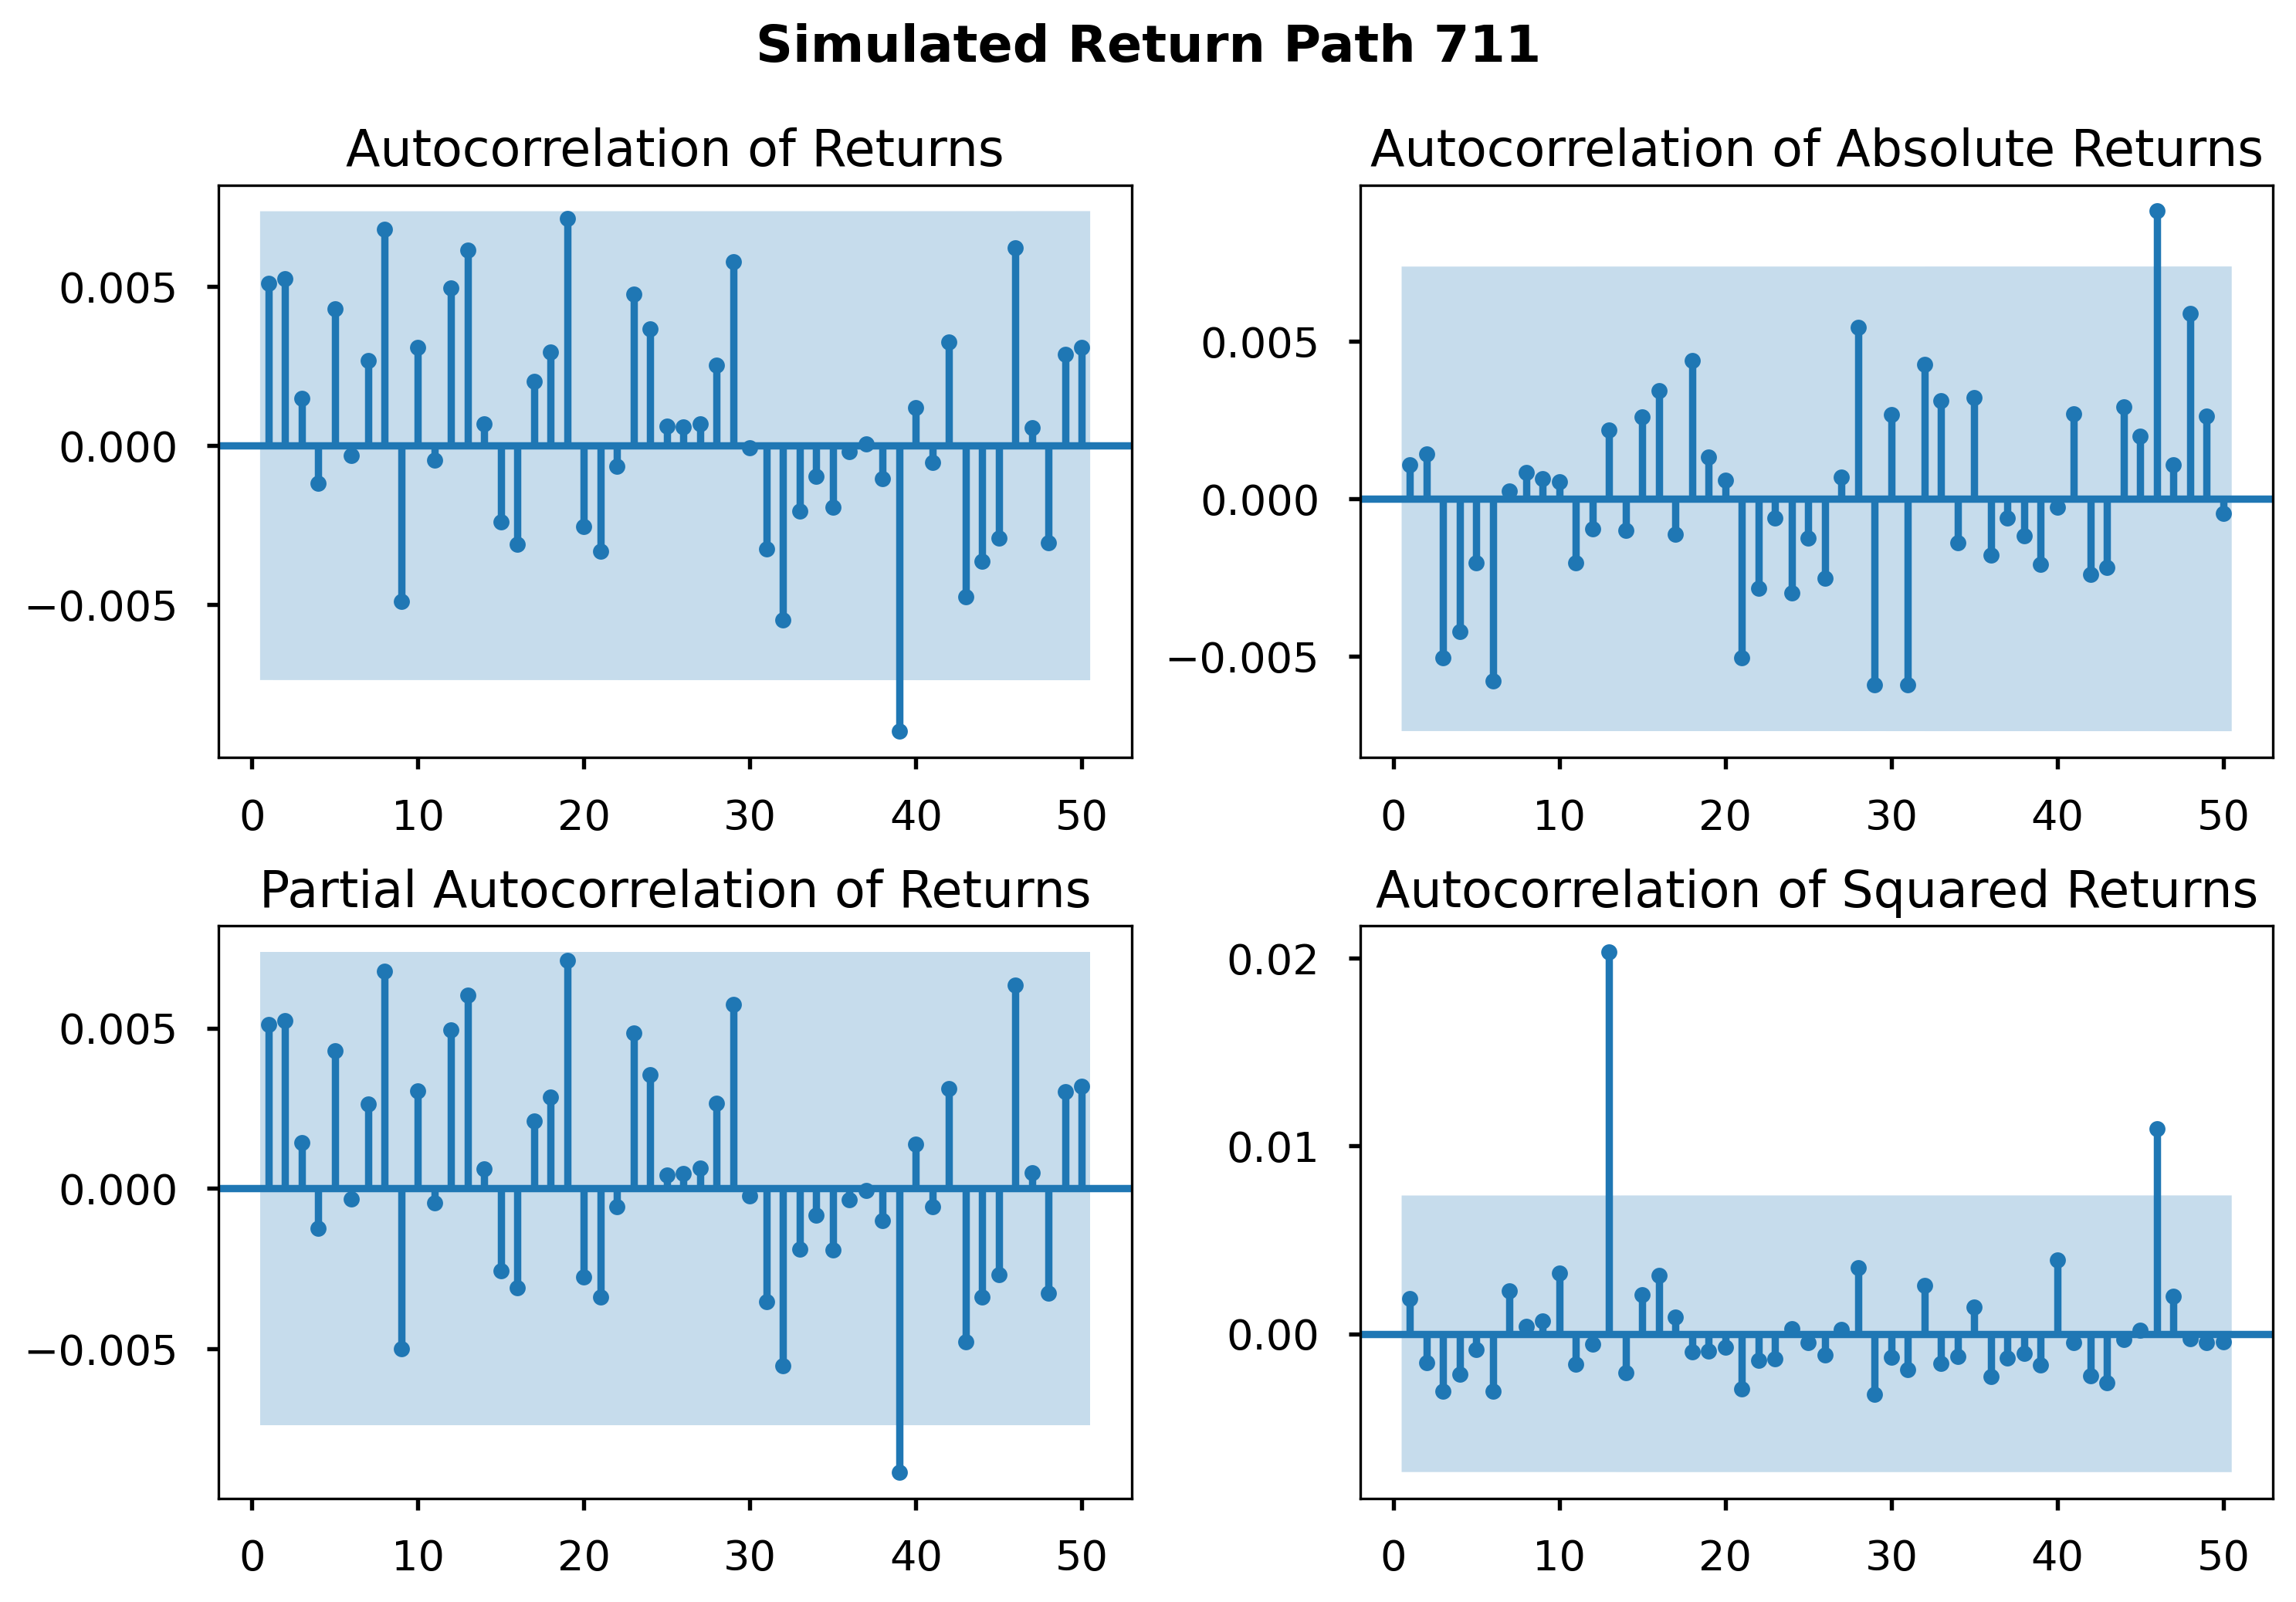

In [21]:
N_paths = 1000
block_size = 100
gc_sim_iid = IIDB(gc_returns, N_paths=N_paths)
view_all(gc_returns, gc_sim_iid, cmap=None)

0          1          2          3          4    \
2019-01-01 15:05:00 1,199.5310 1,200.1600 1,200.7125 1,200.3415 1,200.1829   
2019-01-01 15:10:00 1,199.3662 1,200.1600 1,200.7125 1,200.2503 1,200.7316   
2019-01-01 15:15:00 1,199.5535 1,200.0664 1,200.2470 1,200.1658 1,200.4569   
2019-01-01 15:20:00 1,199.5535 1,200.1594 1,200.5610 1,200.1658 1,200.5355   
2019-01-01 15:25:00 1,199.6449 1,200.2500 1,200.5610 1,200.0863 1,201.5209   
...                        ...        ...        ...        ...        ...   
2019-12-31 13:35:00 1,471.4793 1,215.8806 1,714.9146 1,365.1747 1,724.0263   
2019-12-31 13:40:00 1,471.6732 1,215.7195 1,715.7086 1,364.2232 1,724.1432   
2019-12-31 13:45:00 1,472.2679 1,215.8761 1,715.1405 1,363.6900 1,724.6779   
2019-12-31 13:50:00 1,472.3655 1,215.7814 1,714.9190 1,363.9031 1,724.4238   
2019-12-31 13:55:00 1,472.2681 1,215.1887 1,714.6894 1,364.0050 1,725.2236   

                           5          6          7          8          9    \
2019-01-01 15:05:00 1,200.0943 1,200.0921 1,200.5162 1,199.9093 1,200.8895   
2019-01-01 15:10:00 1,199.9105 1,200.0921 1,200.1513 1,200.0705 1,201.2038   
2019-01-01 15:15:00 1,199.8174 1,200.3673 1,200.1513 1,200.3492 1,200.0954   
2019-01-01 15:20:00 1,199.9814 1,199.3521 1,199.8080 1,199.8657 1,200.0954   
2019-01-01 15:25:00 1,200.0610 1,200.4586 1,199.7284 1,199.9585 1,200.0156   
...                        ...        ...        ...        ...        ...   
2019-12-31 13:35:00 1,482.5251 1,529.5553 1,410.3485 1,454.6709 1,282.9777   
2019-12-31 13:40:00 1,482.5251 1,529.4530 1,410.5703 1,454.5580 1,282.5495   
2019-12-31 13:45:00 1,482.8436 1,529.4530 1,410.3558 1,455.4788 1,282.0405   
2019-12-31 13:50:00 1,483.3068 1,529.4530 1,410.4629 1,454.8855 1,282.0405   
2019-12-31 13:55:00 1,483.7037 1,529.1466 1,408.5651 1,455.2101 1,281.4624   

                     ...        990        991        992        993  \
2019-01-01 15:05:00  ... 1,200.0810 1,199.6865 1,200.9046 1,199.9208   
2019-01-01 15:10:00  ... 1,199.8029 1,199.6865 1,201.0917 1,199.7397   
2019-01-01 15:15:00  ... 1,199.6210 1,198.6662 1,202.1357 1,199.4596   
2019-01-01 15:20:00  ... 1,199.9651 1,198.6662 1,202.2920 1,199.0635   
2019-01-01 15:25:00  ... 1,200.0447 1,198.8298 1,202.8541 1,199.1551   
...                  ...        ...        ...        ...        ...   
2019-12-31 13:35:00  ... 1,767.6889 1,418.7774 1,480.9434 1,286.7112   
2019-12-31 13:40:00  ... 1,764.9341 1,418.7774 1,481.2893 1,287.3507   
2019-12-31 13:45:00  ... 1,765.0651 1,419.6485 1,483.1667 1,286.9899   
2019-12-31 13:50:00  ... 1,764.8111 1,419.2250 1,483.3655 1,287.6218   
2019-12-31 13:55:00  ... 1,764.3972 1,419.7649 1,483.2532 1,287.4231   

                           994        995        996        997        998  \
2019-01-01 15:05:00 1,199.0271 1,199.8138 1,200.0933 1,200.0793 1,199.9149   
2019-01-01 15:10:00 1,199.4505 1,199.7206 1,200.0124 1,199.8080 1,200.1525   
2019-01-01 15:15:00 1,199.3725 1,200.3581 1,200.0124 1,199.8080 1,200.4314   
2019-01-01 15:20:00 1,200.0173 1,200.0892 1,199.4449 1,199.7149 1,200.4314   
2019-01-01 15:25:00 1,200.2583 1,200.1696 1,199.4449 1,198.8797 1,200.1090   
...                        ...        ...        ...        ...        ...   
2019-12-31 13:35:00 1,647.8886 1,440.6106 1,252.7887 1,177.8102 1,447.7328   
2019-12-31 13:40:00 1,648.2632 1,440.9032 1,252.9545 1,177.7296 1,448.2981   
2019-12-31 13:45:00 1,648.5894 1,441.0127 1,252.6694 1,178.3480 1,448.1857   
2019-12-31 13:50:00 1,647.8105 1,440.6316 1,252.9492 1,178.5242 1,448.4705   
2019-12-31 13:55:00 1,647.4834 1,441.0614 1,253.0396 1,178.7753 1,449.0118   

                           999  
2019-01-01 15:05:00 1,199.9086  
2019-01-01 15:10:00 1,200.0810  
2019-01-01 15:15:00 1,200.1617  
2019-01-01 15:20:00 1,199.5674  
2019-01-01 15:25:00 1,199.2490  
...                        ...  
2019-12-31 13:35:00 1,193.7990  
2019-12-31 13:40:00 1,193.6399  
2019-12-31 13:45:00 1,193.6399  
2019-12-31 13:50:00 1

<Figure size 3000x2100 with 0 Axes>

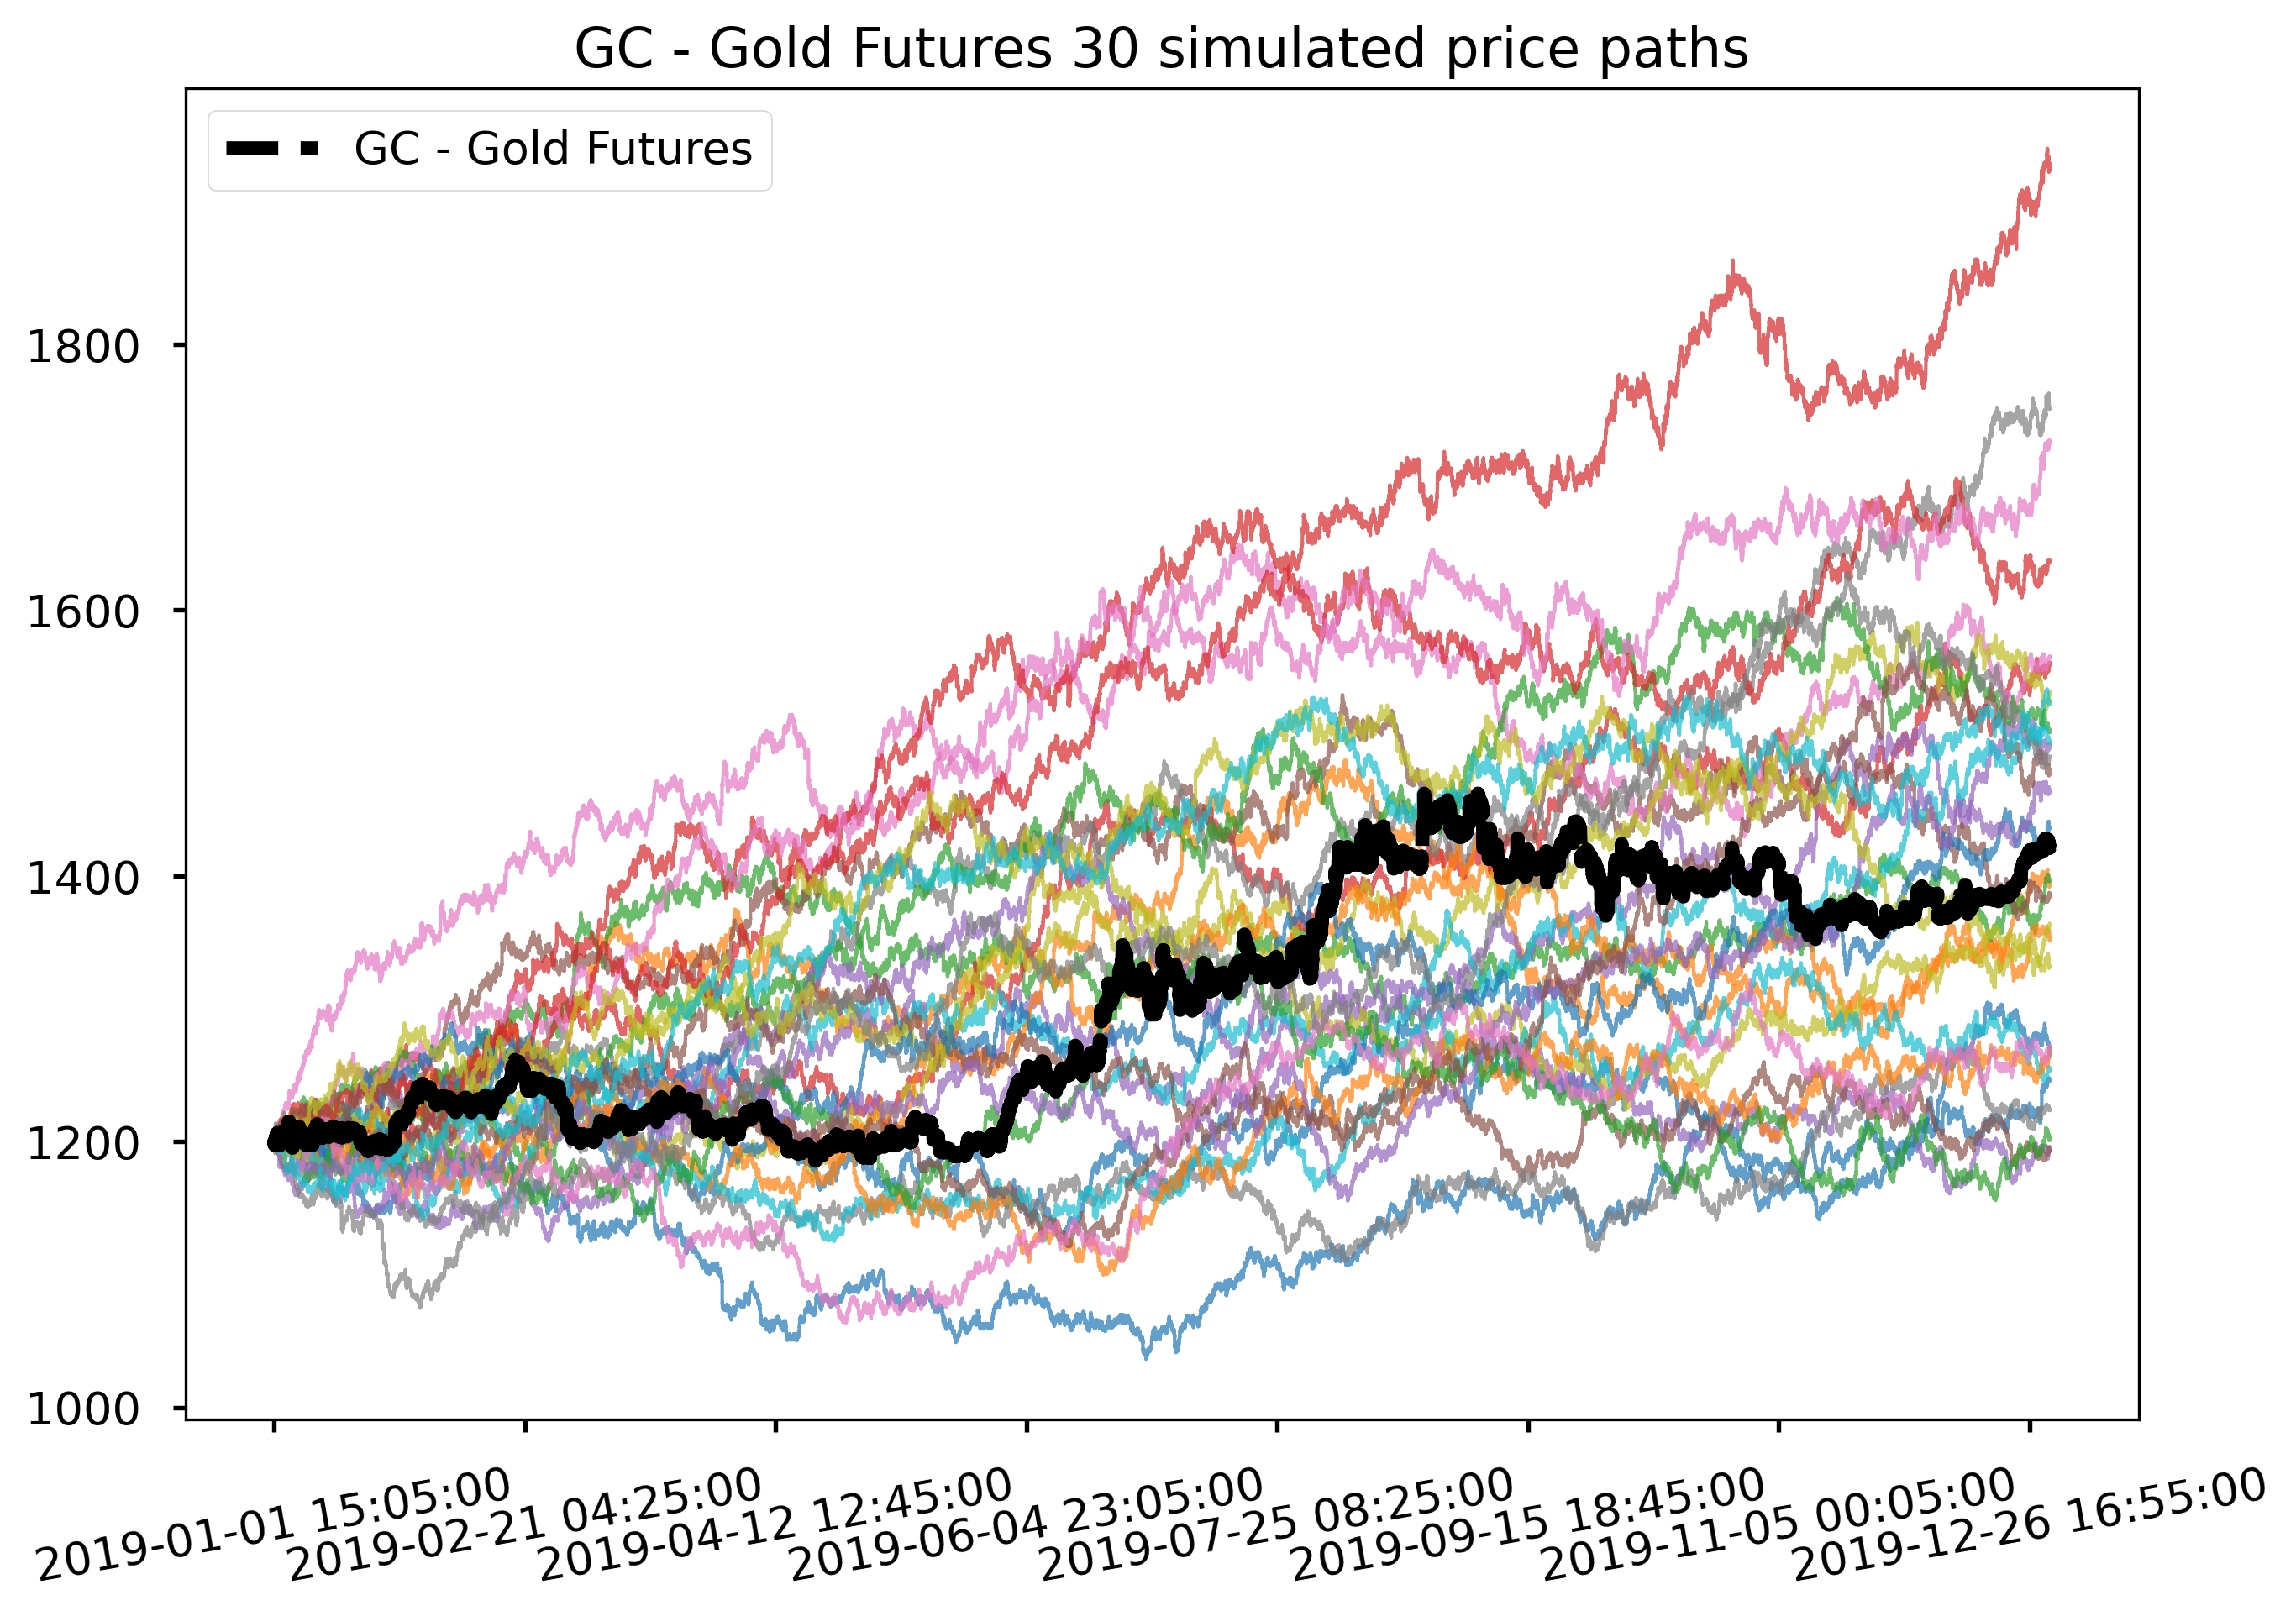

In [22]:
plot_prices(gc_returns, gc_sim_iid, start=1200, price_index=gc.index[1:], n_plot_paths=30, cmap='nanex_cmap')

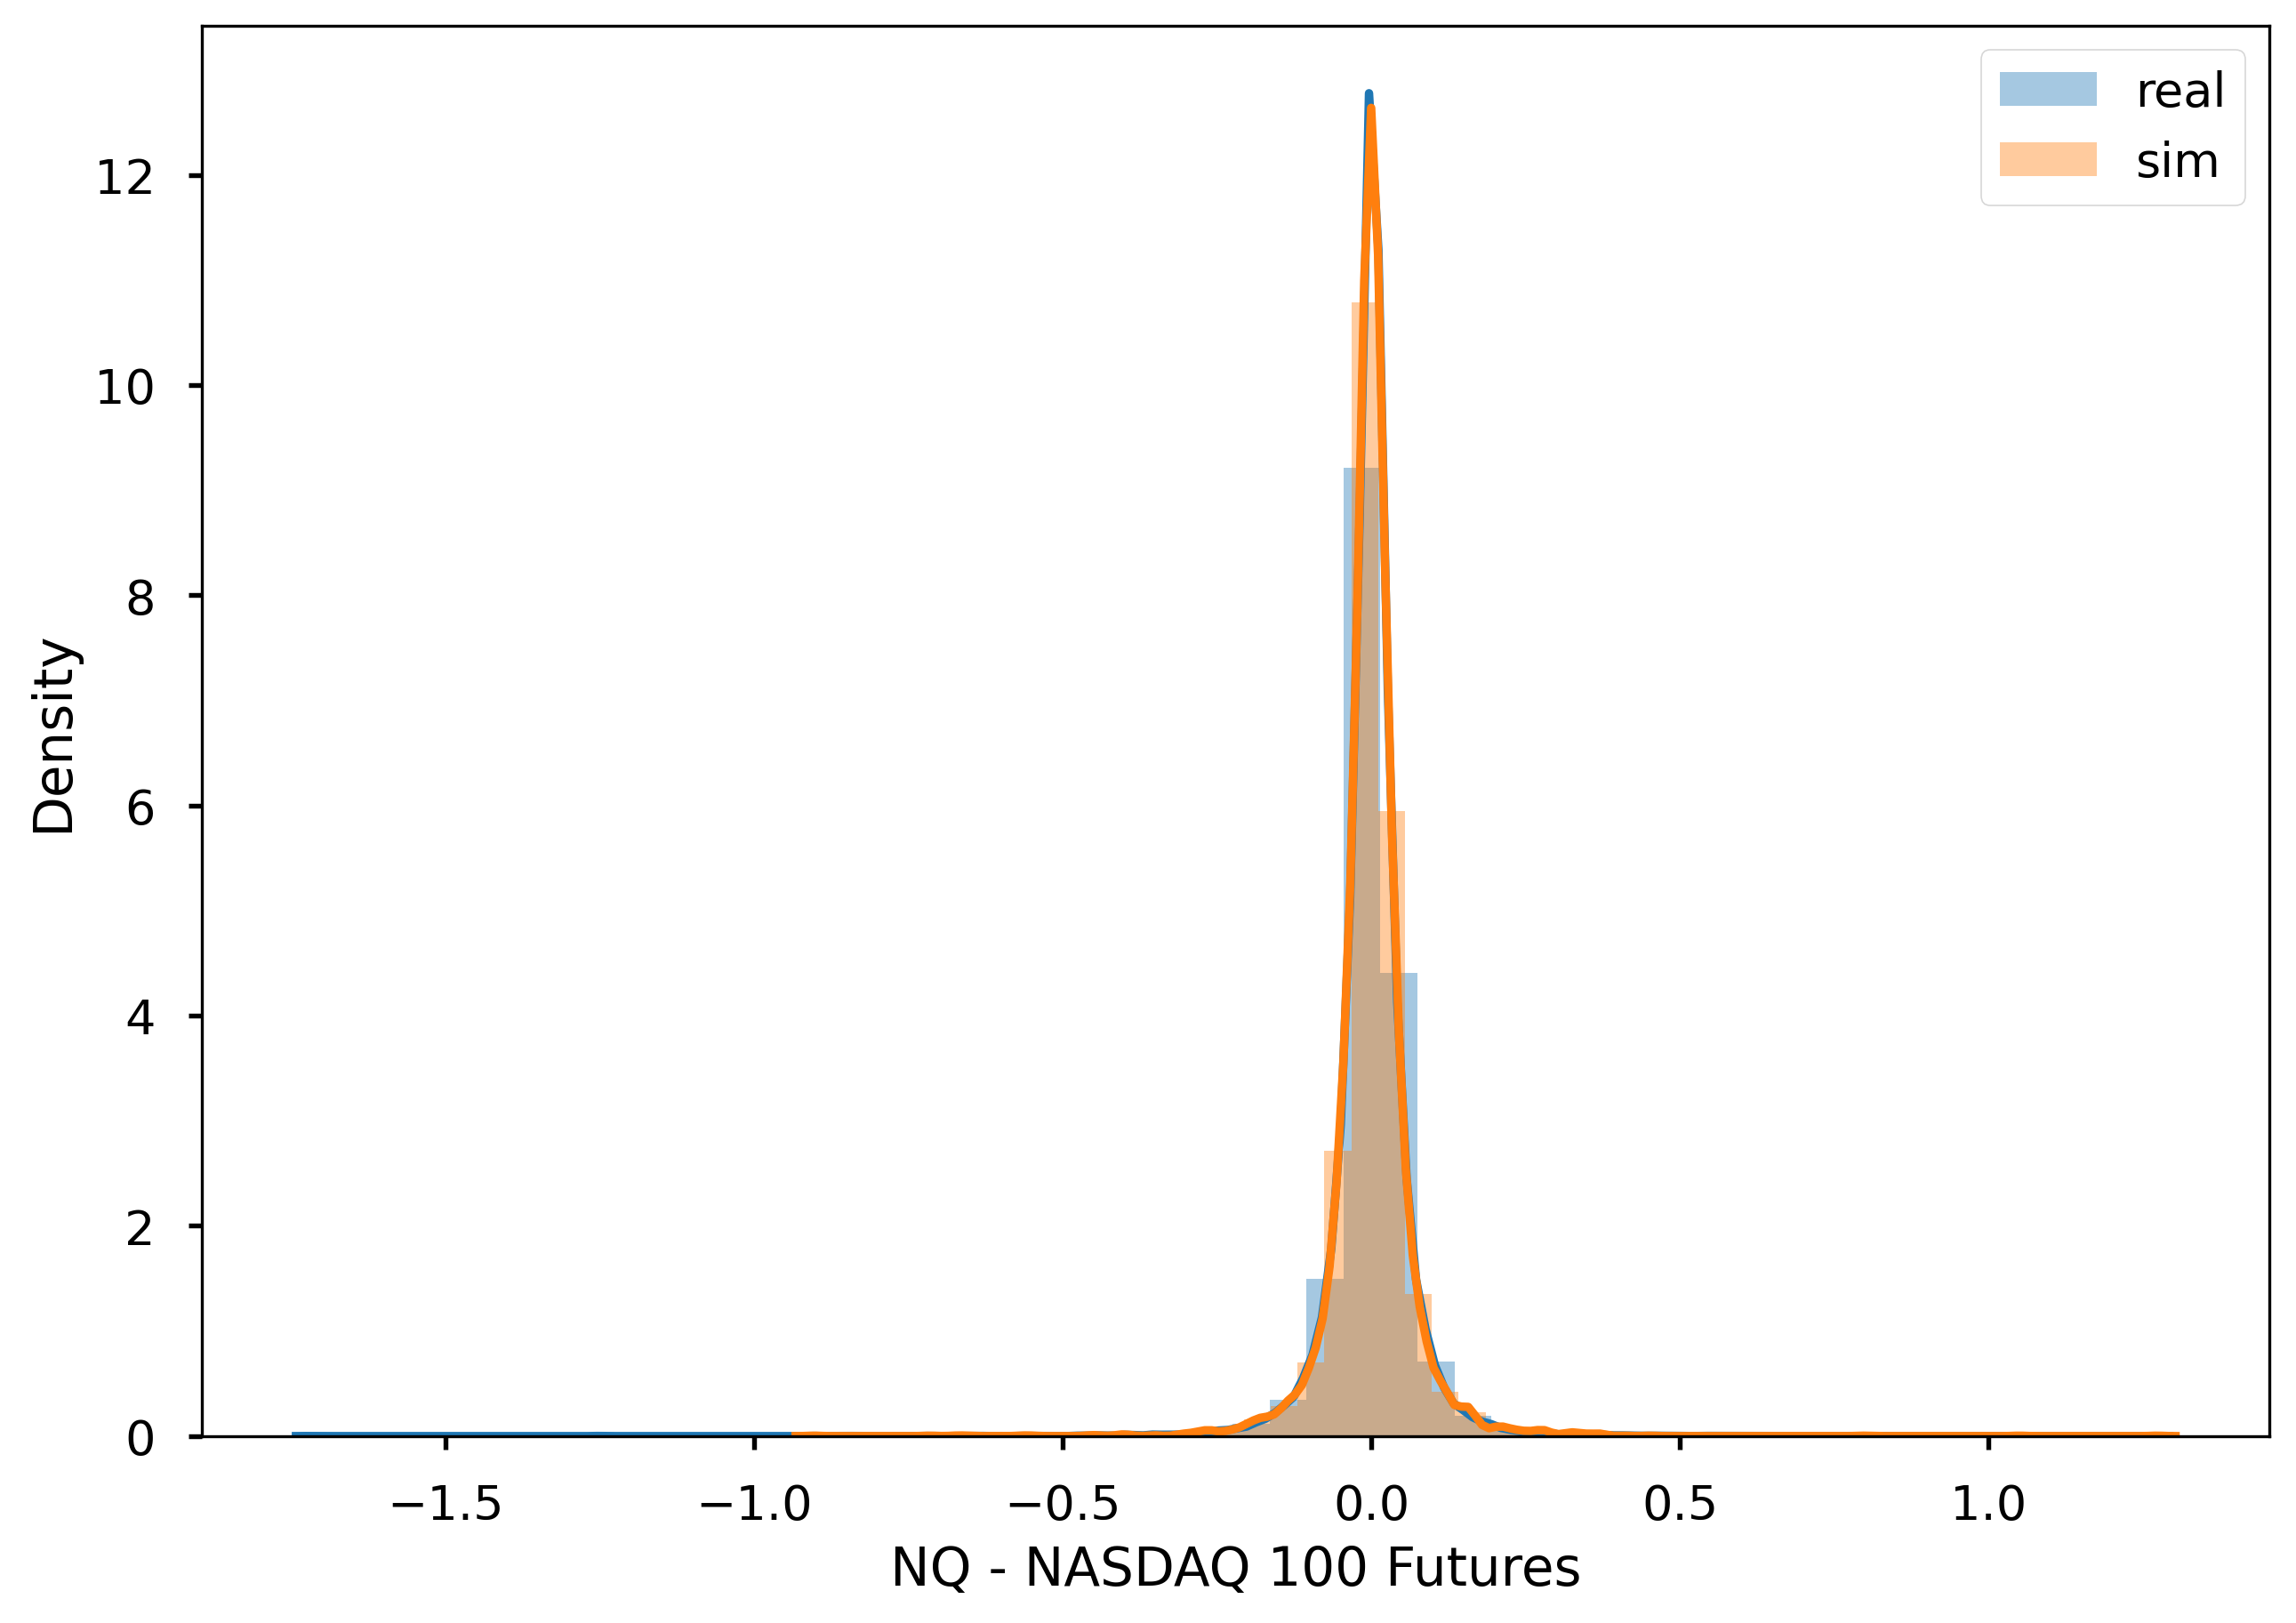

In [23]:
fig, ax = plt.subplots()
sns.distplot(nq_returns*100, ax=ax, label="real")
sns.distplot(nq_sim_cbb[:10]*100, ax=ax, label="sim")
ax.legend()

In [24]:
nq_returns.max()

0.01273197381504488